# Remove then add experiment

In this experiment, I will assume a high-predicted fact is true and another high-predicted fact is false. I will then remove all mentions of both facts from the knowledge graph and then slowly reintroduce them back to the KG. To do this, I will have to follow what Miro does in the Wikipedia experiments. On every time step, I will see the change in ranking and see how this bi-lateral conflict affects the ranking as both of the supporting facts for each fact are reintroduced to the KG. 

Steps:
1. Get the original top predictions for a particular fact. Lets do tail prediction for this example. 
2. Get the top ranking entities for the tail prediction. 
3. Remove all mentions of the facts that mention the entities from the KG. 
    - Should we remove all afacts or just tail or head facts? 
    
    


    
 



## Step 1

Get the original top predictions for a fact. Lets use FB15K237. 



In [1]:
# https://stackoverflow.com/questions/33862420/ipython-notebook-how-to-reload-all-modules-in-a-specific-python-file
%load_ext autoreload

In [2]:
import pandas as pd
import numpy as np
import os


In [3]:
print(os.getcwd())

/scratch/jfg388/misinformation/knowledge-graph


In [4]:
import json

fb15k237_label_mapping_file = open('entity2wikidata.json')

fb15k237_label_map = json.load(fb15k237_label_mapping_file)

In [5]:
# # useful way to access several Kelpie,KG utilities without writing explicit import statements
%run kelpie_explanation_helpers.py

In [6]:
from kelpie_explanation_helpers import trainComplExKelpie, Dataset, load_dataset

dataset_name = "FB15k-237"
model_directory = os.getcwd() + '/Kelpie/stored_models'

dataset = Dataset(dataset_name)
testing_set = load_dataset(os.path.join(f'Kelpie/data/{dataset_name}', 'test.txt'))
training_set = load_dataset(os.path.join(f'Kelpie/data/{dataset_name}', 'train.txt'))

# train complex, since this is the original dataset with no pertubations, we can us ethe one provided by the kelpie authors
original_trained_complex = trainComplExKelpie(
                                os.path.join(model_directory, 'ComplEx_'+dataset_name+'.pt'),
                                dataset_name, load_existing_model=True, dataset=dataset)

In [7]:
dummy_dataset = Dataset("FB15k-237")

dr_triples = dummy_dataset.get_triples_for_entity(dummy_dataset.train_samples[0][0])

print(dr_triples)

[array([0, 0, 1]), array([526,  29,   0]), array([3780,   29,    0]), array([  0,  69, 708]), array([  0, 139,  90]), array([6993,   15,    0]), array([   0,    0, 6163]), array([  0,  73, 302]), array([1754,   29,    0]), array([13249,   133,     0]), array([  0,  62, 420]), array([4744,   13,    0]), array([101,  13,   0]), array([1201,   13,    0]), array([   0,   72, 2722]), array([971,  13,   0]), array([   0,   73, 1059]), array([   0,   69, 1718]), array([4688,  224,    0]), array([2977,   13,    0]), array([434, 161,   0]), array([   0,   73, 1914]), array([  0, 219,  90]), array([8202,   78,    0]), array([3124,   13,    0]), array([  0, 206,  90]), array([1718,  157,    0]), array([3986,   66,    0]), array([8913,   13,    0]), array([236,  37,   0]), array([2769,   29,    0]), array([2733,   29,    0]), array([7415,  168,    0]), array([   0,  122, 6745]), array([4404,   29,    0]), array([  0,  23, 209]), array([615,  29,   0]), array([2115,   13,    0]), array([  0,  69, 6

In [8]:


facts = samples_to_facts(dr_triples, dummy_dataset)

for fact in facts:
    print(fb15k237_label_map[fact[0]]['label'],  ", ", fact[1], ", ",fb15k237_label_map[fact[2]]['label'],"\n")

Dominican Republic ,  /location/country/form_of_government ,  republic 

taekwondo ,  /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country ,  Dominican Republic 

swimming ,  /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country ,  Dominican Republic 

Dominican Republic ,  /olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/olympics ,  1984 Summer Olympics 

Dominican Republic ,  /location/statistical_region/gdp_nominal_per_capita./measurement_unit/dated_money_value/currency ,  United States dollar 

Americas ,  /location/location/contains ,  Dominican Republic 

Dominican Republic ,  /location/country/form_of_government ,  democracy 

Dominican Republic ,  /olympics/olympic_participating_country/medals_won./olympics/olympic_medal_honor/medal ,  bronze medal 

boxing ,  /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country ,  Dominican Republic 

Santo Domingo ,  /base/biblioness/b

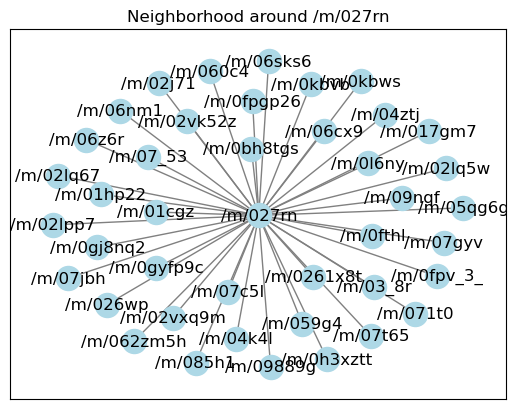

In [15]:
def visualize_neighborhood(dataset, entity_id, radius=1):
    """
    Visualize the neighborhood around a specific entity.
    :param dataset: the Dataset object
    :param entity_name: the name of the entity
    :param radius: the radius of the neighborhood (default: 1)
    """
    # Create a new graph
    graph = nx.Graph()
    
    entity_name = dataset.get_name_for_entity_id(entity_id)

    # Add the target entity to the graph
    graph.add_node(entity_name)

    # Get the triples associated with the entity
    triples = dataset.get_triples_for_entity(entity_id)

    # Traverse the neighborhood of the target entity
    for _ in range(radius):
        neighbors = []
        for triple in triples:
            head, _, tail = triple
            if head == entity_id:
                neighbors.append(dataset.get_name_for_entity_id(tail))
            elif tail == entity_id:
                neighbors.append(dataset.get_name_for_entity_id(head))
        triples = []
        for neighbor in neighbors:
            neighbor_id = dataset.get_id_for_entity_name(neighbor)
            triples.extend(dataset.get_triples_for_entity(neighbor))
            graph.add_edge(entity_name, neighbor)

    # Plot the graph
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray')
    plt.title("Neighborhood around {}".format(entity_name))
    plt.show()
    

visualize_neighborhood(dummy_dataset, dummy_dataset.train_samples[0][0], radius=5)



In [7]:
# choose a random fact form the training set
import random
from kelpie_explanation_helpers import convert_readable_fact

random_fact = training_set[0]
print("random fact", convert_readable_fact(random_fact, fb15k237_label_map))

random fact ['Dominican Republic', '/location/country/form_of_government', 'republic']


In [8]:
from kelpie_explanation_helpers import facts_to_samples

scores, ranks, predictions = original_trained_complex.predict_samples(facts_to_samples([random_fact],dataset ))
# print(scores)
# print(ranks)
# print(predictions)
    


In [9]:
from commons import getFB15K_237Label

head_predictions, tail_predictions = predictions[0][0], predictions[0][1]

print("Top 10 tail predictions for ", convert_readable_fact(random_fact, fb15k237_label_map))
for index, prediction in enumerate(tail_predictions):
    # lets grab the first one and second ones, first one being fake and second one being true
    if index == 0:
        assumed_false = dataset.entity_id_2_name[prediction]
    if index == 1:
        assumed_true = dataset.entity_id_2_name[prediction]
    
    if index >= 10:
        break
#     print(dataset.entity_id_2_name[prediction])
    try:
        print(index + 1, convert_readable_fact([random_fact[0], random_fact[1], dataset.entity_id_2_name[prediction]], fb15k237_label_map)[-1])
    except:
        print("couldnt print", prediction)
        
        
print("We assume that", getFB15K_237Label(assumed_false), " is the false entity we want to downgrade")
print("We assume that", getFB15K_237Label(assumed_true), "is the false entity we want to boost")

Top 10 tail predictions for  ['Dominican Republic', '/location/country/form_of_government', 'republic']
1 republic
2 presidential system
3 parliamentary system
4 constitutional monarchy
5 bronze medal
6 silver medal
7 Library of Congress Classification
8 gold medal
9 prime minister
10 governor
We assume that republic  is the false entity we want to downgrade
We assume that presidential system is the false entity we want to boost


In [10]:


def append_corrupted(file_path):
    directory, file_name = os.path.split(file_path)
    file_name, extension = os.path.splitext(file_name)
    corrupted_file_name = file_name + "_corrupted" + extension
    corrupted_file_path = os.path.join(directory, corrupted_file_name)
    return corrupted_file_path

def removeFactsContainingEntity(original_file_path, entity, corrupted_file = None):
    print("Removing the following samples from ", original_file_path, "contaning", entity)
    
    if corrupted_file:
        with open(corrupted_file, "r") as f:
            lines = f.readlines()   
    else:
        with open(original_file_path, "r") as f:
            lines = f.readlines()
    if not corrupted_file:
        corrupted_file = append_corrupted(original_file_path)

    removed_facts = []
    with open(corrupted_file, "w") as f:
        for line in lines:
            if entity in line: 
                removed_facts.append(line)
            else: 
                f.write(line)
    return removed_facts, corrupted_file


removed_facts_assumed_false, corrupted_file_name = removeFactsContainingEntity(os.path.join(f'Kelpie/data/{dataset_name}', 'train.txt'), assumed_false)


removed_facts_assumed_false




Removing the following samples from  Kelpie/data/FB15k-237/train.txt contaning /m/06cx9


['/m/027rn\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/07z5n\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/06frc\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/01p1v\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/0164v\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/06s_2\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/0d04z6\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/06srk\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/0j4b\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/01c4pv\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/06tgw\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/0166b\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/0165v\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/07fj_\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/0163v\t/location/country/form_of_government\t/m/06cx9\n',
 '/m/05tr7\t/location/country/form_of_government\t/m/0

In [11]:
removed_facts_asumed_true, _ = removeFactsContainingEntity(os.path.join(f'Kelpie/data/{dataset_name}', 'train.txt'), assumed_true, corrupted_file_name)

removed_facts_asumed_true

Removing the following samples from  Kelpie/data/FB15k-237/train.txt contaning /m/01d9r3


['/m/01p1b\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/05qx1\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/07twz\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/02kcz\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/01rxw\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/01z88t\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/04tr1\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/05c74\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/0fv4v\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/05v8c\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/0163v\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/04ty8\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/088vb\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/03188\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/015fr\t/location/country/form_of_government\t/m/01d9r3\n',
 '/m/02k1b\t/location/country/form_of_g

## Thursday July 6 - Meeting with Miro

We will use this example for our ideas:   

Top 10 tail predictions for **<'Dominican Republic', '/location/country/form_of_government', 'republic'>**:
1. Republic
2. Presidential system
3. Parliamentary system
4. Constitutional monarchy
5. Bronze medal
6. Silver medal
7. Library of Congress Classification
8. Gold medal
9. Prime minister
10. Governor

We assume that 'republic' is the false entity we want to downgrade.
We assume that 'presidential system' is the false entity we want to boost.

**A simpler approach**

You remove all mentions of 'republic' and 'presidential system' from the knowledge graph. You assume one of them is the mitigator, and one is the disinformer. You have X facts for the misinformer and Y facts for the mitigator. You initially have a Knowledge Graph with N facts. After removal, you have N - X - Y.

You add these facts back to the knowledge graph, and after each fact addition, you calculate the ranking for the predictions of **<'Dominican Republic', '/location/country/form_of_government', ?>** and see the changes for the mitigator entity and the disinformer entity.

Problems with this approach:
- When you remove all of the mentions of 'republic' and 'presidential system', you are affecting other entities that are related to them. For example, you might remove **<USA, '/location/country/form_of_government', republic>**, which has nothing to do with the Dominican Republic.

**A Kelpie-inspired approach**

Instead of removing all of the mentions of 'republic' and 'presidential system', you can ask Kelpie for the explanations that enable these predictions in the first place. Necessary explanations are actually ideal in this scenario, as they are defined as the "smallest set of facts featuring h that made it possible for the model to pick the correct tail t in the first place." This is an ideal avenue of exploration for our work as Reem's capstone work weaponizes sufficient explanations to both boost and demote a fact. After getting the necessary explanations for the misinformer entity and the disinformer entity, you remove them from the KG as above and reintroduce them back to the KG while keeping track of the ranking of both entities at every addition step.

**Which fact to use?**

In Miro's Wikipedia simulator, a significant amount of work was done in choosing an interesting use case that is worth investigating further. Similar due diligence is necessary in this scenario before carrying out the simulation work.
- **Is there a link already?**
In the DR scenario above, the fact **<'Dominican Republic', '/location/country/form_of_government', 'republic'>** is already in the KG. In a way, this renders link prediction useless as obviously this fact will strongly enable the prediction of 'republic'. What happens if we remove this fact from the KG and then predict as our starting point? Will 'presidential system' be the number one prediction? If this is the case, then this will be an interesting starting point for our simulation work as we see that in the absence of the 'anchor' fact, 'presidential system' can be an easy entity for a disinformer to promote.
- **1 to N vs 1 to 1 relationships**
In the DR scenario, the link '/location/country/form_of_government' is a 1 to 1 relationship. How will this investigation happen if instead we choose a 1 to N relationship like 'isAParentOf' or an N to N relationship like 'isAFriend'?

 
 **In 1 to N  or N to N scenario, we can follow Miro's advice verbatim:**
 
 One way could be to have a fact we know is true, for example Barak Obama is a president, and a fact that is not true but believable, for example Barak Obama is a basketball player (believable because he plays basketball, but it's not a professional basketball player).

Let's say we have the knowledge graph $G$. The query for "is a" is denoted as $Q = (\text{Obama}, \text{is a}, \bullet)$,  where $\bullet$ represents the set of possible answers. The first thing is to predict the topk tails, represented as a set $T = \{\text{President}, \text{Basketball Player}, ...\}$.

We want now to remove the direct links, making the true facts uncertain. In this case we remove $\langle\text{Obama}, \text{is a}, \text{President}\rangle$ and $\langle\text{Obama}, \text{is a}, \text{Basketball Player}\rangle$. If only $\langle\text{Obama}, \text{is a}, \text{President}\rangle$ is present, we can assume this is the absolute truth (i.e. mitigator side) before removal. 

After this operation, we re-query $G$ to get a new prediction set $T'$. If $T$ is somewhat similar to  $T'$ then we know our example is good.

Now we ask Kelpie possible explanations for our two main links: $\langle\text{Obama}, \text{is a}, \text{President}\rangle$ and $\langle\text{Obama}, \text{is a}, \text{Basketball Player}\rangle$. This is going to give us two sets of triples $A$ and $B$, respectively.

We then remove these triples from our graph and re-query "is a" to derive a different set of predictions, $T''$. At this point $T$ and $T''$ are going to be somehow different enough, or at least $\text{President}$ and $\text{Basketball Player}$ shouldn't be there. If that's true our example is still good.

Now we can proceed with the simulation considering two agents: a mitigator that tries to add the triples from $A$ back and a mitigator that tries to add triples from $B$ back.

At every move, the model is retrained and the top k predictions for "is a" are updated, and we can have a metric similar to the one I am doing for datavoids on wikipedia.

 
 
 



In [12]:
# now lets use the models provided by Kelpie to train on an attacked Knowledge Graph

# use the DatasetClass provided by Kelpians to remove the samples
# follow whats done in this lines in degrading_misinfo_kelpie_explanations to retrain on new version of the dataset 
#             final_model_path = os.path.join(model_directory, model_name+'_'+dataset_name+'_final.pt')
#             trained_final = model_training_algo(final_model_path,
#                                     dataset_name, load_existing_model=False, dataset=new_dataset)



corrupted_model_path = './corrupted.pt'


# experiment with the dataset class provided by the kelpie authors

# print(dataset.entities)
# print(dataset.relations)



In [13]:
print(dataset.train_triples)

[['/m/027rn' '/location/country/form_of_government' '/m/06cx9']
 ['/m/017dcd'
  '/tv/tv_program/regular_cast./tv/regular_tv_appearance/actor'
  '/m/06v8s0']
 ['/m/07s9rl0' '/media_common/netflix_genre/titles' '/m/0170z3']
 ...
 ['/m/0djvzd'
  '/soccer/football_player/current_team./sports/sports_team_roster/team'
  '/m/02b16p']
 ['/m/0gmblvq'
  '/award/award_winning_work/awards_won./award/award_honor/award'
  '/m/07kjk7c']
 ['/m/020jqv'
  '/award/award_nominee/award_nominations./award/award_nomination/nominated_for'
  '/m/09d3b7']]


In [14]:
print(dataset.train_samples)

[[    0     0     1]
 [    2     1     3]
 [    4     2     5]
 ...
 [ 6954   170  8974]
 [ 3818    30  7570]
 [10244    38  8396]]


In [15]:
import numpy

sample_to_remove = dataset.train_samples[0]

isRemoved = dataset.remove_training_samples(numpy.array([sample_to_remove]))




print(dataset.printable_sample(sample_to_remove), isRemoved)

</m/027rn, /location/country/form_of_government, /m/06cx9> [True]


In [16]:
isRemoved = dataset.remove_training_samples(numpy.array([sample_to_remove]))
print(dataset.printable_sample(sample_to_remove), isRemoved)

</m/027rn, /location/country/form_of_government, /m/06cx9> [False]


In [17]:
import time

start_time = time.time()

corrupted_complex = trainComplExKelpie(corrupted_model_path,
                                dataset_name, load_existing_model=False, dataset=dataset)

end_time = time.time()
print(f'It took {end_time - start_time} seconds to train this model')

train loss: 100%|██████████| 544228/544228 [00:11<00:00, 45614.95ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
It took 1205.5589790344238 to train this model


In [18]:
from kelpie_explanation_helpers import facts_to_samples

print(numpy.array([sample_to_remove]))
scores, ranks, predictions = corrupted_complex.predict_samples(numpy.array([sample_to_remove]))

[[0 0 1]]


In [19]:
head_predictions, tail_predictions = predictions[0][0], predictions[0][1]

print("Top 10 tail predictions for ", dataset.printable_sample(sample_to_remove))
for index, prediction in enumerate(tail_predictions):
    # lets grab the first one and second ones, first one being fake and second one being true
    if index >= 10:
        break
#     print(dataset.entity_id_2_name[prediction])
    try:
        print(index + 1, convert_readable_fact([random_fact[0], random_fact[1], dataset.entity_id_2_name[prediction]], fb15k237_label_map)[-1])
    except:
        print("couldnt print", prediction)
        

Top 10 tail predictions for  </m/027rn, /location/country/form_of_government, /m/06cx9>
1 republic
2 presidential system
3 parliamentary system
4 constitutional monarchy
5 silver medal
6 bronze medal
7 gold medal
8 Library of Congress Classification
couldnt print 2550
10 2008 Summer Olympics
We assume that republic  is the false entity we want to downgrade
We assume that presidential system is the false entity we want to boost


In [20]:
dataset.remove_training_samples(numpy.array([sample_to_remove]))

[False]

# July 7 experiments
 
 Notes 
- The dataset interface provided by the kelpie authors is very well implemented and it has useful functionalities we can leverage to remove and add facts as needed before training. I have some ideas on possible extension we could do to facilitate experimentation and iteration, like visualizing the neighborhood around an entity using network x or getting all the facts that contain an entity, with possible variations to get just the facts that contain the entity as head or tail. 
- it takes a long time to train the complex model, with my experiments showing it takes around 20 minutes
- after removing the fact <dominicanrepublic,government,republic>, the model still predicts republic as the highest ranked tail. i think this worked properly as there was indeed variation in the top 10 after removing the original fact. 
- could we do post-training, just like the kelpie authors did to make our training process faster? and if so, how does that work?



 
 

In [2]:
# https://stackoverflow.com/questions/33862420/ipython-notebook-how-to-reload-all-modules-in-a-specific-python-file
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
!pwd

/scratch/jfg388/misinformation/knowledge-graph


In [11]:
from kelpie_commons import reduce_file_size
from kelpie_explanation_helpers import Dataset

reduced_train = 'fb15k237_reduced_train.txt'
reduced_test = 'fb15k237_reduced_test.txt'
reduced_valid =  'fb15k237_reduced_valid.txt'

perecentage_reduced = 5


reduce_file_size('Kelpie/data/FB15k-237/train.txt', perecentage_reduced, reduced_train)
reduce_file_size('Kelpie/data/FB15k-237/test.txt', perecentage_reduced, reduced_test)
reduce_file_size('Kelpie/data/FB15k-237/valid.txt', perecentage_reduced, reduced_valid)


# now train new files in the upgraded Dataset interface

reduced_dataset = Dataset("FB15k-237", "\t", True, reduced_train, reduced_test, reduced_valid)

len(reduced_dataset.train_samples)

Original file contains 272115 triples.
New file 'fb15k237_reduced_train.txt' created with 13605 triples.
Original file contains 20466 triples.
New file 'fb15k237_reduced_test.txt' created with 1023 triples.
Original file contains 17535 triples.
New file 'fb15k237_reduced_valid.txt' created with 876 triples.


13605

In [12]:
print(reduced_dataset.train_samples[0])

[0 0 1]


In [13]:
import time
from kelpie_explanation_helpers import trainComplExKelpie

start_time = time.time()
dataset_name = "FB15k-237"

corrupted_model_path = './corrupted.pt'

corrupted_complex = trainComplExKelpie(corrupted_model_path,
                                dataset_name, load_existing_model=False, dataset=reduced_dataset)

end_time = time.time()
print(f'It took {end_time - start_time} seconds to train this model')

train loss: 100%|██████████| 27210/27210 [00:00<00:00, 78426.11ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
It took 43.15254259109497 seconds to train this model


In [16]:
print(reduced_dataset.printable_sample(reduced_dataset.train_samples[0]))


</m/01s0ps, /music/instrument/instrumentalists, /m/01vtg4q>


In [17]:
import json

fb15k237_label_mapping_file = open('entity2wikidata.json')

fb15k237_label_map = json.load(fb15k237_label_mapping_file)

head,relation,tail = reduced_dataset.sample_to_fact(reduced_dataset.train_samples[0])

print(fb15k237_label_map[head]["label"], relation, fb15k237_label_map[tail]["label"])

electric piano /music/instrument/instrumentalists Bo Diddley


In [18]:
import numpy

scores, ranks, predictions = corrupted_complex.predict_samples(numpy.array([reduced_dataset.train_samples[0]]))
head_predictions, tail_predictions = predictions[0][0], predictions[0][1]


In [19]:
print("Top 10 tail predictions for ", fb15k237_label_map[head]["label"], relation, fb15k237_label_map[tail]["label"])
for index, prediction in enumerate(tail_predictions):
    if index >= 10:
        break
#     print(dataset.entity_id_2_name[prediction])
    try:
        print(index + 1, fb15k237_label_map[reduced_dataset.get_name_for_entity_id(prediction)]["label"])
    except:
        print("couldnt print", prediction)
        

Top 10 tail predictions for  electric piano /music/instrument/instrumentalists Bo Diddley
1 Bo Diddley
2 Chet Atkins
3 Paul Simon
4 T-Bone Burnett
5 Jack White
6 Ray Manzarek
7 Mick Jagger
8 Marilyn Manson
9 Joe Walsh
10 Jon Anderson


In [20]:
print(reduced_dataset.get_triples_for_entity(reduced_dataset.train_samples[0][0]))

[array([0, 0, 1]), array([   0,    2, 1131]), array([138,  11,   0]), array([2969,   46,    0]), array([3582,    2,    0]), array([1235,    2,    0]), array([   0,    2, 3106]), array([25, 11,  0]), array([5234,   46,    0])]


# Kelpie simulation experiments

For this experiments, I automated the entire process of training the model at every fact addition step


I did 4 experiments, where I explored different startegies in each. 

## Experiment 1
**Dataset** : Randomly-chosen thriples of the FB15-237 dataset, about 10% of the original dataset.   
**Approach:** get the thriples that mention the entity as supporting facts.   
**Attack strategy:** Round-Robin, mitigator starts (randomly chosen)  
**Was the fact in question removed?** No  
**Fact in question:** Augustine of Hippo, /people/person/gender male organism,   
**Chosen Good Entity:** female organism (original rank 2)  
**Chosen Bad entity:** male organism (original rank 1)  

### Good entity samples
Marit Allen /people/person/gender female organism  
Rekha /people/person/gender female organism  
Mary Steenburgen /people/person/gender female organism  
Phyllis Logan /people/person/gender female organism  
Rose Byrne /people/person/gender female organism  
Priyanka Chopra /people/person/gender female organism  
Diana Wynne Jones /people/person/gender female organism  
Clea DuVall /people/person/gender female organism  
Kay Cannon /people/person/gender female organism  
Anne Baxter /people/person/gender female organism  
Joan Blondell /people/person/gender female organism  
Rita Wilson /people/person/gender female organism  
Kathy Baker /people/person/gender female organism  
Amy Poehler /people/person/gender female organism  
Jessica Chastain /people/person/gender female organism  


### Bad entity samples
Augustine of Hippo /people/person/gender male organism  
Mark Gatiss /people/person/gender male organism  
Wayne Dyer /people/person/gender male organism  
George Orwell /people/person/gender male organism  
Hensley Meulens /people/person/gender male organism  
Charles Lang /people/person/gender male organism  
David Newman /people/person/gender male organism  
Ray Moyer /people/person/gender male organism  
Austin Pendleton /people/person/gender male organism  
George Stevens /people/person/gender male organism  
BT /people/person/gender male organism  
Louis C.K. /people/person/gender male organism  
Rick Baker /people/person/gender male organism  
Henri Matisse /people/person/gender male organism  
James Fox /people/person/gender male organism  
Todd McFarlane /people/person/gender male organism  
Mike Nichols /people/person/gender male organism  
Gary Barber /people/person/gender male organism  
Roy Bittan /people/person/gender male organism  
Peter David /people/person/gender male organism  
August /people/person/gender male organism  


**Number of rounds for this simulation:** 36

<img src="./img/e1.png" />


## Experiment 2
**Dataset :** Randomly-chosen thriples of the FB15-237 dataset, about 10% of the original dataset.     
**Approach:** Use kelpie necessary explanations as supporting facts
**Attack strategy:** Round-Robin, disinformer starts  
**Was the fact in question removed?** No  
**Fact in question:** Augustine of Hippo, /people/person/gender male organism,   
**Chosen Good Entity:** female organism (original rank 2)  
**Chosen Bad entity:** male organism (original rank 1)  

### Good entity samples
Diana Wynne Jones /people/person/gender female organism  
Rose Byrne /people/person/gender female organism  
Clea DuVall /people/person/gender female organism  
Marit Allen /people/person/gender female organism  
Jessica Chastain /people/person/gender female organism  
Mary Steenburgen /people/person/gender female organism  
Phyllis Logan /people/person/gender female organism  
Priyanka Chopra /people/person/gender female organism  

### Bad entity samples
Rick Baker /people/person/gender male organism  
Augustine of Hippo /people/person/gender male organism  
Mark Gatiss /people/person/gender male organism  
Wayne Dyer /people/person/gender male organism  
Hensley Meulens /people/person/gender male organism  
George Orwell /people/person/gender male organism  
Ray Moyer /people/person/gender male organism  

**Number of rounds for this simulation:** 15
<img src="./img/e2.png" />


## Experiment 3_1
**Dataset :** Randomly-chosen thriples of the FB15-237 dataset, about 10% of the original dataset.     
**Approach:** Use kelpie necessary explanations as supporting facts   
**Attack strategy:** Round-Robin, mitigator starts  
**Was the fact in question removed?** Yes  
**Fact in question:** Augustine of Hippo, /people/person/gender male organism,   
**Chosen Good Entity:** male organism (original rank 1253)  
**Chosen Bad entity:** Rick Baker(original rank 1)  

### Good Entity Samples
David Newman /people/person/gender male organism  
Peter David /people/person/gender male organism  
Henri Matisse /people/person/gender male organism  
Louis C.K. /people/person/gender male organism  
James Fox /people/person/gender male organism  
August /people/person/gender male organism  
Roy Bittan /people/person/gender male organism  
Rick Baker /people/person/gender male organism  
BT /people/person/gender male organism  
Charles Lang /people/person/gender male organism  
George Orwell /people/person/gender male organism  
Hensley Meulens /people/person/gender male organism  
Ray Moyer /people/person/gender male organism  
Mike Nichols /people/person/gender male organism  
Todd McFarlane /people/person/gender male organism  
Mark Gatiss /people/person/gender male organism  
Wayne Dyer /people/person/gender male organism  
Austin Pendleton /people/person/gender male organism  
Gary Barber /people/person/gender male organism  

### Bad Entity Samples
None  

**Number of rounds for this simulation:** 19 

<img src="./img/e3.png" />


## Experiment 3_2

**Dataset :** Randomly-chosen thriples of the FB15-237 dataset, about 10% of the original dataset.     
**Approach:** get the thriples that mention the entity as supporting facts.  
**Attack strategy:** Round-Robin, disinformer starts  
**Was the fact in question removed**? Yes  
**Fact in question:** Augustine of Hippo, /people/person/gender male organism,   
**Chosen Good Entity:** male organism (original rank 1253)  
**Chosen Bad entity:** Rick Baker(original rank 1)  

### Good entity samples
Mark Gatiss /people/person/gender male organism   
Wayne Dyer /people/person/gender male organism   
George Orwell /people/person/gender male organism   
Hensley Meulens /people/person/gender male organism   
Charles Lang /people/person/gender male organism   
David Newman /people/person/gender male organism   
Ray Moyer /people/person/gender male organism   
Austin Pendleton /people/person/gender male organism   
George Stevens /people/person/gender male organism   
BT /people/person/gender male organism   
Louis C.K. /people/person/gender male organism   
Rick Baker /people/person/gender male organism   
Henri Matisse /people/person/gender male organism   
James Fox /people/person/gender male organism   
Todd McFarlane /people/person/gender male organism   
Mike Nichols /people/person/gender male organism   
Gary Barber /people/person/gender male organism   
Roy Bittan /people/person/gender male organism   
Peter David /people/person/gender male organism   
August /people/person/gender male organism   

### Bad entity samples
Rick Baker /people/person/gender male organism  

**Number of rounds for this simulation:** 21 

<img src="./img/e4.png" />





## Interesting avenues to explore?
- who starts, mitigator or disinformer?  
- Sufficient explanations
- Post-training? Is it really necessary to retrain the model from scratch after every iteration

In [2]:
# https://stackoverflow.com/questions/33862420/ipython-notebook-how-to-reload-all-modules-in-a-specific-python-file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from kelpie_commons import reduce_file_size
from kelpie_explanation_helpers import Dataset
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment



file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']
experiment_1 = KnowledgeGraphMitigationExperiment("experiment_1","FB15k-237", file_paths,10, None, "tail" )

experiment_1.run_experiment()

Reducing file size of train, test, and valid files in the dataset FB15k-237
Original file contains 272115 triples.
New file './results/experiment_1/train.txt' created with 27211 triples.
Original file contains 20466 triples.
New file './results/experiment_1/test.txt' created with 2046 triples.
Original file contains 17535 triples.
New file './results/experiment_1/valid.txt' created with 1753 triples.

Fact in question
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 225853.93ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Choosen good entity
female organism

Chosen bad entity
male organism

Initial Good entity rank 2
Initial Bad entity rank 1

Good entity samples
Marit Allen /people/person/gender female organism
Rekha /people/person/gender female organism
Mary Steenburgen /people/person/gender female organism
Phyllis Logan /people/person/gender female organism
Rose Byrne /people/person/gender female organism
Priyanka Chopra /people/person/gender female organism
Diana Wynne Jones /people/person/gender female organism
Clea DuVall /people/person/gender female organism
Kay Cannon /people/person/gender female organism
Anne Baxter /people/person/gender female organism
Joan Blondell /people/person/gender female organism
Rita Wilson /people/person/gender female organism
Kathy Baker /people/person/gender female organism
Amy Poehler /people/person/gender female organism
Jessica Chastain /people/person/gender female organism
Bad entity samples
Augustine of Hippo /people/person/gender male

train loss: 100%|██████████| 4022/4022 [00:00<00:00, 222156.99ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [7174 8521 7926 ...  924 1341  215]
Good entity 487
Bad entity 1
Good entity rank 10158
Bad entity rank 787


Round number 2
disinformer adds the following sample to  the dataset
August /people/person/gender male organism



train loss: 100%|██████████| 4024/4024 [00:00<00:00, 219116.40ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [3229 6531 4637 ...  358 1169  487]
Good entity 487
Bad entity 1
Good entity rank 10183
Bad entity rank 9796


Round number 3
mitigator adds the following sample to  the dataset
Amy Poehler /people/person/gender female organism



train loss: 100%|██████████| 4026/4026 [00:00<00:00, 217890.14ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [3712 6163 9835 ...  294 2289 2663]
Good entity 487
Bad entity 1
Good entity rank 9352
Bad entity rank 10131


Round number 4
disinformer adds the following sample to  the dataset
Peter David /people/person/gender male organism



train loss: 100%|██████████| 4028/4028 [00:00<00:00, 217860.63ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [9633 9753 9888 ...  197 2016 1806]
Good entity 487
Bad entity 1
Good entity rank 9647
Bad entity rank 10145


Round number 5
mitigator adds the following sample to  the dataset
Kathy Baker /people/person/gender female organism



train loss: 100%|██████████| 4030/4030 [00:00<00:00, 221119.59ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1336  634  110 ... 7954 9101 3504]
Good entity 487
Bad entity 1
Good entity rank 1097
Bad entity rank 881


Round number 6
disinformer adds the following sample to  the dataset
Roy Bittan /people/person/gender male organism



train loss: 100%|██████████| 4032/4032 [00:00<00:00, 221739.86ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [8210 3026 3600 ... 2611 2499 2422]
Good entity 487
Bad entity 1
Good entity rank 9950
Bad entity rank 9181


Round number 7
mitigator adds the following sample to  the dataset
Rita Wilson /people/person/gender female organism



train loss: 100%|██████████| 4034/4034 [00:00<00:00, 211186.28ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2136  587 1514 ... 4033 9725 9473]
Good entity 487
Bad entity 1
Good entity rank 2509
Bad entity rank 2676


Round number 8
disinformer adds the following sample to  the dataset
Gary Barber /people/person/gender male organism



train loss: 100%|██████████| 4036/4036 [00:00<00:00, 199124.97ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2663 2647 1334 ... 7591 9495 7413]
Good entity 487
Bad entity 1
Good entity rank 2553
Bad entity rank 2562


Round number 9
mitigator adds the following sample to  the dataset
Joan Blondell /people/person/gender female organism



train loss: 100%|██████████| 4038/4038 [00:00<00:00, 209977.80ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 409 1397   77 ... 7697 8233 7270]
Good entity 487
Bad entity 1
Good entity rank 779
Bad entity rank 1383


Round number 10
disinformer adds the following sample to  the dataset
Mike Nichols /people/person/gender male organism



train loss: 100%|██████████| 4040/4040 [00:00<00:00, 209904.84ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 115  188  825 ... 5210 4770 7030]
Good entity 487
Bad entity 1
Good entity rank 1914
Bad entity rank 2429


Round number 11
mitigator adds the following sample to  the dataset
Anne Baxter /people/person/gender female organism



train loss: 100%|██████████| 4042/4042 [00:00<00:00, 199093.12ex/s, loss={l.item():.0f}]

# Experiment 2
Use kelpie's necessary explanations of both the good and bad entity as the facts given to the disinformer and the mititgator agents to add to the dataset throughout the simulation. 

In [5]:
# https://stackoverflow.com/questions/33862420/ipython-notebook-how-to-reload-all-modules-in-a-specific-python-file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Reducing file size of train, test, and valid files in the dataset FB15k-237
Original file contains 272115 triples.
New file './results/kelpie_experiment/train.txt' created with 27211 triples.
Original file contains 20466 triples.
New file './results/kelpie_experiment/test.txt' created with 2046 triples.
Original file contains 17535 triples.
New file './results/kelpie_experiment/valid.txt' created with 1753 triples.

Fact in question
Augustine of Hippo /people/person/gender male organism
[0 0 1]
</m/0w6w, /people/person/gender, /m/05zppz>



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 209751.08ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Choosen good entity
female organism

Chosen bad entity
male organism

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/0w6w	/people/person/gender	/m/02zsn

Bad entity fact to explain /m/0w6w	/people/person/gender	/m/05zppz

Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0w6w,/people/person/gender,/m/02zsn>
Extracting promising facts for</m/0w6w, /people/person/gender, /m/02zsn>
	Analyzing sample 1 on 1: </m/0w6w, /people/person/gender, /m/05zppz>

	Computing relevance for sample 0 on 1: </m/0w6w, /people/person/gender, /m/05zppz>
		Running base post-training on entity /m/0w6w with no additions
		Running post-training on entity /m/0w6w removing samples: 
			</m/0w6w, /people/person/gender, /m/05zppz>
	Obtained relevance: 10182.929208487458
/m/0w6w;/people/person/gender;/m/02zsn
/m/0w6w;/people/person/gender;/m/05zppz:10182.92

train loss: 100%|██████████| 4092/4092 [00:00<00:00, 232985.26ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   1  487   11 ... 4907 3372 3202]
Good entity 487
Bad entity 1
Good entity rank 2
Bad entity rank 1


Round number 2
mitigator adds the following sample to  the dataset
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4094/4094 [00:00<00:00, 232789.44ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   1   11  487 ... 8297 6956 1837]
Good entity 487
Bad entity 1
Good entity rank 3
Bad entity rank 1


Good entity rankings [2, 3]
Bad entity rankings [1, 1]


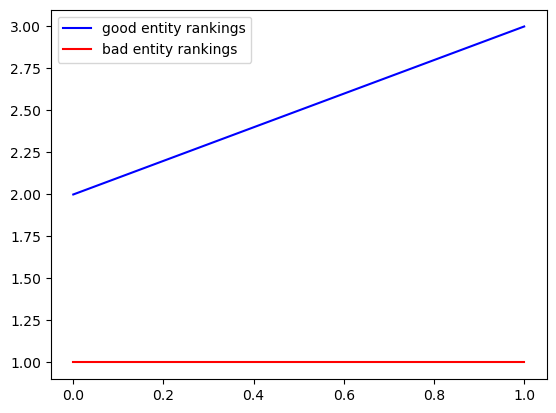

Total time taken for entire experiment 26.430241346359253


<Figure size 640x480 with 0 Axes>

In [7]:
from kelpie_commons import reduce_file_size
from kelpie_explanation_helpers import Dataset
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment



file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']
kelpie_experiment = KnowledgeGraphMitigationExperiment("kelpie_experiment","FB15k-237", file_paths,10, None, "tail", "kelpie" )

kelpie_experiment.run_experiment("kelpie")

# Experiment 3

Run both base and kelpie experiments on the same dataset. 
Original fact has not been removed from the dataset. 



Fact in question
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 222409.15ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Choosen good entity
female organism

Chosen bad entity
male organism

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/0w6w	/people/person/gender	/m/02zsn

Bad entity fact to explain /m/0w6w	/people/person/gender	/m/05zppz

Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0w6w,/people/person/gender,/m/02zsn>
Extracting promising facts for</m/0w6w, /people/person/gender, /m/02zsn>
	Analyzing sample 1 on 15: </m/03gt0c5, /people/person/gender, /m/02zsn>
	Analyzing sample 2 on 15: </m/06wvfq, /people/person/gender, /m/02zsn>
	Analyzing sample 3 on 15: </m/014g22, /people/person/gender, /m/02zsn>
	Analyzing sample 4 on 15: </m/0clvcx, /people/person/gender, /m/02zsn>
	Analyzing sample 5 on 15: </m/03hh89, /people/person/gender, /m/02zsn>
	Analyzing sample 6 on 15: </m/03fwln, /people/person/gender, /m/02zsn>
	Analyzing sample 7 on

train loss: 100%|██████████| 4064/4064 [00:00<00:00, 219969.43ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 2044  1426  1334 ... 10096  8173 10017]
Good entity 487
Bad entity 1
Good entity rank 2214
Bad entity rank 1857


Round number 2
mitigator adds the following sample to  the dataset
Priyanka Chopra /people/person/gender female organism



train loss: 100%|██████████| 4066/4066 [00:00<00:00, 220821.44ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1135   32  619 ... 3600 9913 3870]
Good entity 487
Bad entity 1
Good entity rank 1638
Bad entity rank 863


Round number 3
disinformer adds the following sample to  the dataset
George Orwell /people/person/gender male organism



train loss: 100%|██████████| 4068/4068 [00:00<00:00, 220718.57ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1426 1334 2663 ... 7072 3784 8405]
Good entity 487
Bad entity 1
Good entity rank 2101
Bad entity rank 1552


Round number 4
mitigator adds the following sample to  the dataset
Phyllis Logan /people/person/gender female organism



train loss: 100%|██████████| 4070/4070 [00:00<00:00, 219123.51ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32  183    9 ... 4816 4238 9560]
Good entity 487
Bad entity 1
Good entity rank 759
Bad entity rank 697


Round number 5
disinformer adds the following sample to  the dataset
Hensley Meulens /people/person/gender male organism



train loss: 100%|██████████| 4072/4072 [00:00<00:00, 218857.56ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1270   30 1559 ... 8155 7628 3597]
Good entity 487
Bad entity 1
Good entity rank 1834
Bad entity rank 1289


Round number 6
mitigator adds the following sample to  the dataset
Mary Steenburgen /people/person/gender female organism



train loss: 100%|██████████| 4074/4074 [00:00<00:00, 219246.00ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  77 2292 1547 ... 4116 5185 5114]
Good entity 487
Bad entity 1
Good entity rank 1587
Bad entity rank 1339


Round number 7
disinformer adds the following sample to  the dataset
Wayne Dyer /people/person/gender male organism



train loss: 100%|██████████| 4076/4076 [00:00<00:00, 220079.34ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  30  603 1426 ... 5887 8968 6628]
Good entity 487
Bad entity 1
Good entity rank 2035
Bad entity rank 1709


Round number 8
mitigator adds the following sample to  the dataset
Jessica Chastain /people/person/gender female organism



train loss: 100%|██████████| 4078/4078 [00:00<00:00, 219143.53ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   9   32   77 ... 5700 4710 8171]
Good entity 487
Bad entity 1
Good entity rank 1184
Bad entity rank 836


Round number 9
disinformer adds the following sample to  the dataset
Mark Gatiss /people/person/gender male organism



train loss: 100%|██████████| 4080/4080 [00:00<00:00, 220133.79ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 250   77 1734 ... 4017 4424 8652]
Good entity 487
Bad entity 1
Good entity rank 2083
Bad entity rank 2274


Round number 10
mitigator adds the following sample to  the dataset
Marit Allen /people/person/gender female organism



train loss: 100%|██████████| 4082/4082 [00:00<00:00, 222012.36ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 250 2663 1755 ... 9224 5662 5161]
Good entity 487
Bad entity 1
Good entity rank 2116
Bad entity rank 2090


Round number 11
disinformer adds the following sample to  the dataset
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4084/4084 [00:00<00:00, 221423.42ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   1  487   11 ... 5970 6023 8442]
Good entity 487
Bad entity 1
Good entity rank 2
Bad entity rank 1


Round number 12
mitigator adds the following sample to  the dataset
Clea DuVall /people/person/gender female organism



train loss: 100%|██████████| 4086/4086 [00:00<00:00, 221351.60ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   1  487   11 ... 4751 9387 5472]
Good entity 487
Bad entity 1
Good entity rank 2
Bad entity rank 1


Round number 13
disinformer adds the following sample to  the dataset
Rick Baker /people/person/gender male organism



train loss: 100%|██████████| 4088/4088 [00:00<00:00, 220986.14ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [    1   487    11 ... 10073  9522  2968]
Good entity 487
Bad entity 1
Good entity rank 2
Bad entity rank 1


Round number 14
mitigator adds the following sample to  the dataset
Rose Byrne /people/person/gender female organism



train loss: 100%|██████████| 4090/4090 [00:00<00:00, 221737.26ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   1   11  487 ... 4520 9966 1908]
Good entity 487
Bad entity 1
Good entity rank 3
Bad entity rank 1


Round number 15
mitigator adds the following sample to  the dataset
Diana Wynne Jones /people/person/gender female organism



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 221071.31ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   1  487   11 ... 7411 6330 5111]
Good entity 487
Bad entity 1
Good entity rank 2
Bad entity rank 1


Good entity rankings [2214, 1638, 2101, 759, 1834, 1587, 2035, 1184, 2083, 2116, 2, 2, 2, 3, 2]
Bad entity rankings [1857, 863, 1552, 697, 1289, 1339, 1709, 836, 2274, 2090, 1, 1, 1, 1, 1]


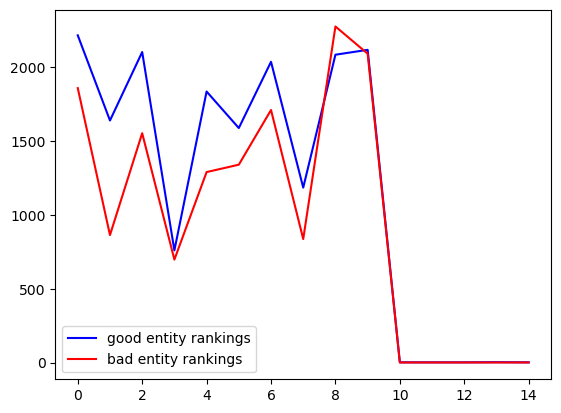

Total time taken for entire experiment 314.524290561676


<Figure size 640x480 with 0 Axes>

In [5]:
from kelpie_commons import reduce_file_size
from kelpie_explanation_helpers import Dataset
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment



file_paths = ['results/experiment_3/train.txt','results/experiment_3/test.txt', 'results/experiment_3/valid.txt']
kelpie_experiment_3 = KnowledgeGraphMitigationExperiment("experiment_3_1","FB15k-237", file_paths,10, None, "tail", "kelpie" , False)

kelpie_experiment_3.run_experiment("kelpie")



Fact in question
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 220963.15ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Choosen good entity
female organism

Chosen bad entity
male organism

Initial Good entity rank 2
Initial Bad entity rank 1

Good entity samples
Marit Allen /people/person/gender female organism
Rekha /people/person/gender female organism
Mary Steenburgen /people/person/gender female organism
Phyllis Logan /people/person/gender female organism
Rose Byrne /people/person/gender female organism
Priyanka Chopra /people/person/gender female organism
Diana Wynne Jones /people/person/gender female organism
Clea DuVall /people/person/gender female organism
Kay Cannon /people/person/gender female organism
Anne Baxter /people/person/gender female organism
Joan Blondell /people/person/gender female organism
Rita Wilson /people/person/gender female organism
Kathy Baker /people/person/gender female organism
Amy Poehler /people/person/gender female organism
Jessica Chastain /people/person/gender female organism
Bad entity samples
Augustine of Hippo /people/person/gender male

train loss: 100%|██████████| 4022/4022 [00:00<00:00, 217578.20ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [7174 8521 7926 ...  924 1341  215]
Good entity 487
Bad entity 1
Good entity rank 10158
Bad entity rank 787


Round number 2
disinformer adds the following sample to  the dataset
August /people/person/gender male organism



train loss: 100%|██████████| 4024/4024 [00:00<00:00, 218322.78ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [3229 6531 4637 ...  358 1169  487]
Good entity 487
Bad entity 1
Good entity rank 10183
Bad entity rank 9796


Round number 3
mitigator adds the following sample to  the dataset
Amy Poehler /people/person/gender female organism



train loss: 100%|██████████| 4026/4026 [00:00<00:00, 218355.03ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [3712 6163 9835 ...  294 2289 2663]
Good entity 487
Bad entity 1
Good entity rank 9352
Bad entity rank 10131


Round number 4
disinformer adds the following sample to  the dataset
Peter David /people/person/gender male organism



train loss: 100%|██████████| 4028/4028 [00:00<00:00, 218766.19ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [9633 9753 9888 ...  197 2016 1806]
Good entity 487
Bad entity 1
Good entity rank 9647
Bad entity rank 10145


Round number 5
mitigator adds the following sample to  the dataset
Kathy Baker /people/person/gender female organism



train loss: 100%|██████████| 4030/4030 [00:00<00:00, 218264.34ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1336  634  110 ... 7954 9101 3504]
Good entity 487
Bad entity 1
Good entity rank 1097
Bad entity rank 881


Round number 6
disinformer adds the following sample to  the dataset
Roy Bittan /people/person/gender male organism



train loss: 100%|██████████| 4032/4032 [00:00<00:00, 218810.60ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [8210 3026 3600 ... 2611 2499 2422]
Good entity 487
Bad entity 1
Good entity rank 9950
Bad entity rank 9181


Round number 7
mitigator adds the following sample to  the dataset
Rita Wilson /people/person/gender female organism



train loss: 100%|██████████| 4034/4034 [00:00<00:00, 219188.56ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2136  587 1514 ... 4033 9725 9473]
Good entity 487
Bad entity 1
Good entity rank 2509
Bad entity rank 2676


Round number 8
disinformer adds the following sample to  the dataset
Gary Barber /people/person/gender male organism



train loss: 100%|██████████| 4036/4036 [00:00<00:00, 219644.37ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2663 2647 1334 ... 7591 9495 7413]
Good entity 487
Bad entity 1
Good entity rank 2553
Bad entity rank 2562


Round number 9
mitigator adds the following sample to  the dataset
Joan Blondell /people/person/gender female organism



train loss: 100%|██████████| 4038/4038 [00:00<00:00, 219773.17ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 409 1397   77 ... 7697 8233 7270]
Good entity 487
Bad entity 1
Good entity rank 779
Bad entity rank 1383


Round number 10
disinformer adds the following sample to  the dataset
Mike Nichols /people/person/gender male organism



train loss: 100%|██████████| 4040/4040 [00:00<00:00, 223971.19ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 115  188  825 ... 5210 4770 7030]
Good entity 487
Bad entity 1
Good entity rank 1914
Bad entity rank 2429


Round number 11
mitigator adds the following sample to  the dataset
Anne Baxter /people/person/gender female organism



train loss: 100%|██████████| 4042/4042 [00:00<00:00, 224652.18ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 200  164   88 ... 8106 9093 6935]
Good entity 487
Bad entity 1
Good entity rank 1563
Bad entity rank 2293


Round number 12
disinformer adds the following sample to  the dataset
Todd McFarlane /people/person/gender male organism



train loss: 100%|██████████| 4044/4044 [00:00<00:00, 224763.34ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1066 2445  216 ... 8045 4972 8524]
Good entity 487
Bad entity 1
Good entity rank 1826
Bad entity rank 2218


Round number 13
mitigator adds the following sample to  the dataset
Kay Cannon /people/person/gender female organism



train loss: 100%|██████████| 4046/4046 [00:00<00:00, 212203.85ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2044  488 2077 ... 4537 5888 7156]
Good entity 487
Bad entity 1
Good entity rank 1963
Bad entity rank 1778


Round number 14
disinformer adds the following sample to  the dataset
James Fox /people/person/gender male organism



train loss: 100%|██████████| 4048/4048 [00:00<00:00, 224920.09ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2044  409   11 ... 5449 3489 5228]
Good entity 487
Bad entity 1
Good entity rank 1890
Bad entity rank 1674


Round number 15
mitigator adds the following sample to  the dataset
Clea DuVall /people/person/gender female organism



train loss: 100%|██████████| 4050/4050 [00:00<00:00, 224309.14ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32   88    9 ... 4842 3008 9174]
Good entity 487
Bad entity 1
Good entity rank 1455
Bad entity rank 1772


Round number 16
disinformer adds the following sample to  the dataset
Henri Matisse /people/person/gender male organism



train loss: 100%|██████████| 4052/4052 [00:00<00:00, 223887.76ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 538   32   70 ... 5729 4638 8236]
Good entity 487
Bad entity 1
Good entity rank 1314
Bad entity rank 1680


Round number 17
mitigator adds the following sample to  the dataset
Diana Wynne Jones /people/person/gender female organism



train loss: 100%|██████████| 4054/4054 [00:00<00:00, 224492.14ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  77  578    9 ... 8781 6699 4977]
Good entity 487
Bad entity 1
Good entity rank 906
Bad entity rank 1548


Round number 18
disinformer adds the following sample to  the dataset
Rick Baker /people/person/gender male organism



train loss: 100%|██████████| 4056/4056 [00:00<00:00, 224570.28ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2344 1246 2663 ... 7984 6782 3199]
Good entity 487
Bad entity 1
Good entity rank 1399
Bad entity rank 1571


Round number 19
mitigator adds the following sample to  the dataset
Priyanka Chopra /people/person/gender female organism



train loss: 100%|██████████| 4058/4058 [00:00<00:00, 225392.12ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32   30   21 ... 2920 4565 5887]
Good entity 487
Bad entity 1
Good entity rank 1755
Bad entity rank 1328


Round number 20
disinformer adds the following sample to  the dataset
Louis C.K. /people/person/gender male organism



train loss: 100%|██████████| 4060/4060 [00:00<00:00, 225658.59ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32  409  634 ... 8505 4933 7484]
Good entity 487
Bad entity 1
Good entity rank 726
Bad entity rank 1155


Round number 21
mitigator adds the following sample to  the dataset
Rose Byrne /people/person/gender female organism



train loss: 100%|██████████| 4062/4062 [00:00<00:00, 225877.51ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1334 1908 1838 ... 8587 7811 8078]
Good entity 487
Bad entity 1
Good entity rank 2170
Bad entity rank 2311


Round number 22
disinformer adds the following sample to  the dataset
BT /people/person/gender male organism



train loss: 100%|██████████| 4064/4064 [00:00<00:00, 226369.87ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32  603    9 ... 8150 6929 3485]
Good entity 487
Bad entity 1
Good entity rank 839
Bad entity rank 1352


Round number 23
mitigator adds the following sample to  the dataset
Phyllis Logan /people/person/gender female organism



train loss: 100%|██████████| 4066/4066 [00:00<00:00, 225809.54ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32   88   70 ... 3693 6930 3870]
Good entity 487
Bad entity 1
Good entity rank 1350
Bad entity rank 1762


Round number 24
disinformer adds the following sample to  the dataset
George Stevens /people/person/gender male organism



train loss: 100%|██████████| 4068/4068 [00:00<00:00, 226544.54ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1734 1755 1837 ... 4815 7313 7655]
Good entity 487
Bad entity 1
Good entity rank 1759
Bad entity rank 2261


Round number 25
mitigator adds the following sample to  the dataset
Mary Steenburgen /people/person/gender female organism



train loss: 100%|██████████| 4070/4070 [00:00<00:00, 226394.40ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   21    77    70 ...  3884 10158  6321]
Good entity 487
Bad entity 1
Good entity rank 962
Bad entity rank 1415


Round number 26
disinformer adds the following sample to  the dataset
Austin Pendleton /people/person/gender male organism



train loss: 100%|██████████| 4072/4072 [00:00<00:00, 226445.59ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 198   39   21 ... 9137 8786 5511]
Good entity 487
Bad entity 1
Good entity rank 1888
Bad entity rank 1219


Round number 27
mitigator adds the following sample to  the dataset
Rekha /people/person/gender female organism



train loss: 100%|██████████| 4074/4074 [00:00<00:00, 226445.73ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  39    9   32 ... 6516 3329 3039]
Good entity 487
Bad entity 1
Good entity rank 876
Bad entity rank 1248


Round number 28
disinformer adds the following sample to  the dataset
Ray Moyer /people/person/gender male organism



train loss: 100%|██████████| 4076/4076 [00:00<00:00, 227047.33ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  348    88     9 ...  7539 10173  8786]
Good entity 487
Bad entity 1
Good entity rank 1241
Bad entity rank 1531


Round number 29
mitigator adds the following sample to  the dataset
Marit Allen /people/person/gender female organism



train loss: 100%|██████████| 4078/4078 [00:00<00:00, 227119.53ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1426 2382 2647 ... 7109 9964 4829]
Good entity 487
Bad entity 1
Good entity rank 1587
Bad entity rank 1650


Round number 30
disinformer adds the following sample to  the dataset
David Newman /people/person/gender male organism



train loss: 100%|██████████| 4080/4080 [00:00<00:00, 226989.79ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  95  179   77 ... 4590 7714 4255]
Good entity 487
Bad entity 1
Good entity rank 1466
Bad entity rank 1427


Round number 31
disinformer adds the following sample to  the dataset
Charles Lang /people/person/gender male organism



train loss: 100%|██████████| 4082/4082 [00:00<00:00, 226623.10ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 2044  1819    32 ...  4780  8648 10168]
Good entity 487
Bad entity 1
Good entity rank 1328
Bad entity rank 1745


Round number 32
disinformer adds the following sample to  the dataset
Hensley Meulens /people/person/gender male organism



train loss: 100%|██████████| 4084/4084 [00:00<00:00, 226569.20ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 634    9   77 ... 9227 4866 5133]
Good entity 487
Bad entity 1
Good entity rank 941
Bad entity rank 1358


Round number 33
disinformer adds the following sample to  the dataset
George Orwell /people/person/gender male organism



train loss: 100%|██████████| 4086/4086 [00:00<00:00, 225617.77ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  77 1426 1270 ... 8248 8046 8521]
Good entity 487
Bad entity 1
Good entity rank 1470
Bad entity rank 1327


Round number 34
disinformer adds the following sample to  the dataset
Wayne Dyer /people/person/gender male organism



train loss: 100%|██████████| 4088/4088 [00:00<00:00, 225749.01ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 183 1734  619 ... 3991 7042 4236]
Good entity 487
Bad entity 1
Good entity rank 1955
Bad entity rank 2334


Round number 35
disinformer adds the following sample to  the dataset
Mark Gatiss /people/person/gender male organism



train loss: 100%|██████████| 4090/4090 [00:00<00:00, 225322.50ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  77  624  807 ... 7773 4219 9933]
Good entity 487
Bad entity 1
Good entity rank 1043
Bad entity rank 866


Round number 36
disinformer adds the following sample to  the dataset
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 227584.96ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   1   11  487 ... 3122 7364 6470]
Good entity 487
Bad entity 1
Good entity rank 3
Bad entity rank 1


Good entity rankings [10158, 10183, 9352, 9647, 1097, 9950, 2509, 2553, 779, 1914, 1563, 1826, 1963, 1890, 1455, 1314, 906, 1399, 1755, 726, 2170, 839, 1350, 1759, 962, 1888, 876, 1241, 1587, 1466, 1328, 941, 1470, 1955, 1043, 3]
Bad entity rankings [787, 9796, 10131, 10145, 881, 9181, 2676, 2562, 1383, 2429, 2293, 2218, 1778, 1674, 1772, 1680, 1548, 1571, 1328, 1155, 2311, 1352, 1762, 2261, 1415, 1219, 1248, 1531, 1650, 1427, 1745, 1358, 1327, 2334, 866, 1]


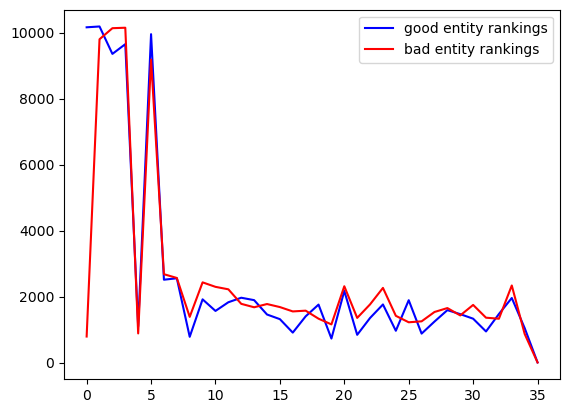

Total time taken for entire experiment 315.5307722091675


<Figure size 640x480 with 0 Axes>

In [6]:
base_experiment_3 = KnowledgeGraphMitigationExperiment("experiment_3_2","FB15k-237", file_paths,10, None, "tail", "kelpie" , False)

base_experiment_3.run_experiment("base")

# Experiment 4

Run both base and kelpie experiments on the same dataset. 
Original fact has been removed from the dataset before starting the simulation.




Fact in question
Augustine of Hippo /people/person/gender male organism

Removing fact in question from the dataset before starting the experiment


train loss: 100%|██████████| 4090/4090 [00:00<00:00, 218472.81ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Good entity after removing fact in question 1
Choosen good entity
male organism

Chosen bad entity
Rick Baker

Initial Good entity rank 1253
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/0w6w	/people/person/gender	/m/05zppz

Bad entity fact to explain /m/0w6w	/people/person/gender	/m/0cw67g

Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0w6w,/people/person/gender,/m/05zppz>
Extracting promising facts for</m/0w6w, /people/person/gender, /m/05zppz>
	Analyzing sample 1 on 20: </m/02j8nx, /people/person/gender, /m/05zppz>
	Analyzing sample 2 on 20: </m/026y23w, /people/person/gender, /m/05zppz>
	Analyzing sample 3 on 20: </m/034bs, /people/person/gender, /m/05zppz>
	Analyzing sample 4 on 20: </m/06s27s, /people/person/gender, /m/05zppz>
	Analyzing sample 5 on 20: </m/09cdxn, /people/person/gender, /m/05zppz>
	Analyzing sample 6 on 20: </m/07qy0b, /peo

train loss: 100%|██████████| 4054/4054 [00:00<00:00, 219314.96ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   9   32   77 ... 6548 7956 6927]
Good entity 1
Bad entity 1837
Good entity rank 2702
Bad entity rank 5504


Round number 2
mitigator adds the following sample to  the dataset
Austin Pendleton /people/person/gender male organism



train loss: 100%|██████████| 4056/4056 [00:00<00:00, 218493.17ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32   30  875 ... 8347 6844 5319]
Good entity 1
Bad entity 1837
Good entity rank 1661
Bad entity rank 6617


Round number 3
mitigator adds the following sample to  the dataset
Wayne Dyer /people/person/gender male organism



train loss: 100%|██████████| 4058/4058 [00:00<00:00, 227124.54ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  77    9  452 ... 8897 6332 9023]
Good entity 1
Bad entity 1837
Good entity rank 2488
Bad entity rank 2840


Round number 4
mitigator adds the following sample to  the dataset
Mark Gatiss /people/person/gender male organism



train loss: 100%|██████████| 4060/4060 [00:00<00:00, 219690.56ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 737 2382   77 ... 4156 9997 4634]
Good entity 1
Bad entity 1837
Good entity rank 2518
Bad entity rank 3525


Round number 5
mitigator adds the following sample to  the dataset
Todd McFarlane /people/person/gender male organism



train loss: 100%|██████████| 4062/4062 [00:00<00:00, 219620.28ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2044  624 2422 ... 5541 5073 3696]
Good entity 1
Bad entity 1837
Good entity rank 2541
Bad entity rank 4685


Round number 6
mitigator adds the following sample to  the dataset
Mike Nichols /people/person/gender male organism



train loss: 100%|██████████| 4064/4064 [00:00<00:00, 221202.60ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2611 1822 2134 ... 9624 9201 7467]
Good entity 1
Bad entity 1837
Good entity rank 1829
Bad entity rank 2818


Round number 7
mitigator adds the following sample to  the dataset
Ray Moyer /people/person/gender male organism



train loss: 100%|██████████| 4066/4066 [00:00<00:00, 220097.57ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 399    9   32 ... 9349 5408 2782]
Good entity 1
Bad entity 1837
Good entity rank 1192
Bad entity rank 8701


Round number 8
mitigator adds the following sample to  the dataset
Hensley Meulens /people/person/gender male organism



train loss: 100%|██████████| 4068/4068 [00:00<00:00, 220134.81ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 250 2382 1426 ... 5142 9511 5417]
Good entity 1
Bad entity 1837
Good entity rank 2632
Bad entity rank 6317


Round number 9
mitigator adds the following sample to  the dataset
George Orwell /people/person/gender male organism



train loss: 100%|██████████| 4070/4070 [00:00<00:00, 220157.82ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32   88  225 ... 9896 7723 7295]
Good entity 1
Bad entity 1837
Good entity rank 1823
Bad entity rank 8103


Round number 10
mitigator adds the following sample to  the dataset
Charles Lang /people/person/gender male organism



train loss: 100%|██████████| 4072/4072 [00:00<00:00, 221477.09ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 807 2134 1270 ... 3658 5549 8103]
Good entity 1
Bad entity 1837
Good entity rank 1805
Bad entity rank 8163


Round number 11
mitigator adds the following sample to  the dataset
BT /people/person/gender male organism



train loss: 100%|██████████| 4074/4074 [00:00<00:00, 220992.66ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 248   32  188 ... 6598 4466 8183]
Good entity 1
Bad entity 1837
Good entity rank 2345
Bad entity rank 2760


Round number 12
mitigator adds the following sample to  the dataset
Rick Baker /people/person/gender male organism



train loss: 100%|██████████| 4076/4076 [00:00<00:00, 221287.17ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 227   32  132 ... 3720 6022 4343]
Good entity 1
Bad entity 1837
Good entity rank 1861
Bad entity rank 316


Round number 13
mitigator adds the following sample to  the dataset
Roy Bittan /people/person/gender male organism



train loss: 100%|██████████| 4078/4078 [00:00<00:00, 221198.20ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32   21   67 ... 5325 8183 7523]
Good entity 1
Bad entity 1837
Good entity rank 1098
Bad entity rank 24


Round number 14
mitigator adds the following sample to  the dataset
August /people/person/gender male organism



train loss: 100%|██████████| 4080/4080 [00:00<00:00, 226293.41ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1270  250 2258 ... 4765 5086 7588]
Good entity 1
Bad entity 1837
Good entity rank 2030
Bad entity rank 11


Round number 15
mitigator adds the following sample to  the dataset
James Fox /people/person/gender male organism



train loss: 100%|██████████| 4082/4082 [00:00<00:00, 221949.04ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32   77   21 ... 5111 5221 8551]
Good entity 1
Bad entity 1837
Good entity rank 1714
Bad entity rank 278


Round number 16
mitigator adds the following sample to  the dataset
Louis C.K. /people/person/gender male organism



train loss: 100%|██████████| 4084/4084 [00:00<00:00, 222354.68ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  168   954   200 ...  8499 10145  8830]
Good entity 1
Bad entity 1837
Good entity rank 2031
Bad entity rank 1003


Round number 17
mitigator adds the following sample to  the dataset
Henri Matisse /people/person/gender male organism



train loss: 100%|██████████| 4086/4086 [00:00<00:00, 221123.12ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   32     9  1734 ...  6527  3463 10043]
Good entity 1
Bad entity 1837
Good entity rank 1158
Bad entity rank 60


Round number 18
mitigator adds the following sample to  the dataset
Peter David /people/person/gender male organism



train loss: 100%|██████████| 4088/4088 [00:00<00:00, 221717.68ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1334  250 1426 ... 4928 4933 7038]
Good entity 1
Bad entity 1837
Good entity rank 1697
Bad entity rank 26


Round number 19
mitigator adds the following sample to  the dataset
David Newman /people/person/gender male organism



train loss: 100%|██████████| 4090/4090 [00:00<00:00, 221854.84ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  70   32  225 ... 6728 9484 7598]
Good entity 1
Bad entity 1837
Good entity rank 1479
Bad entity rank 96


Good entity rankings [2702, 1661, 2488, 2518, 2541, 1829, 1192, 2632, 1823, 1805, 2345, 1861, 1098, 2030, 1714, 2031, 1158, 1697, 1479]
Bad entity rankings [5504, 6617, 2840, 3525, 4685, 2818, 8701, 6317, 8103, 8163, 2760, 316, 24, 11, 278, 1003, 60, 26, 96]


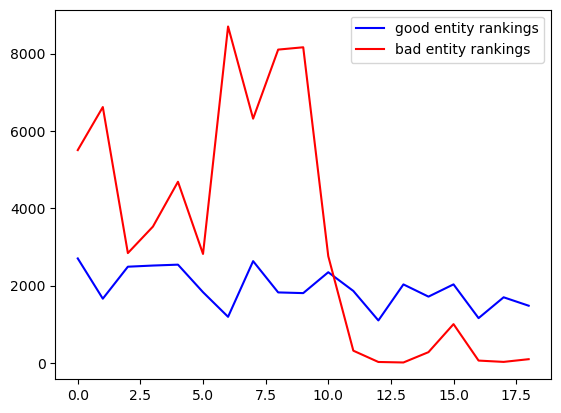

Total time taken for entire experiment 183.1248733997345


<Figure size 640x480 with 0 Axes>

In [12]:
file_paths = ['results/experiment_3/train.txt','results/experiment_3/test.txt', 'results/experiment_3/valid.txt']

kelpie_experiment_4 = KnowledgeGraphMitigationExperiment("experiment_4_1","FB15k-237", file_paths,10, None, "tail", "kelpie" , False, True)

kelpie_experiment_4.run_experiment("kelpie")


Fact in question
Augustine of Hippo /people/person/gender male organism

Removing fact in question from the dataset before starting the experiment


train loss: 100%|██████████| 4090/4090 [00:00<00:00, 222398.44ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Choosen good entity
male organism

Chosen bad entity
Rick Baker

Initial Good entity rank 1253
Initial Bad entity rank 1

Good entity samples
Mark Gatiss /people/person/gender male organism
Wayne Dyer /people/person/gender male organism
George Orwell /people/person/gender male organism
Hensley Meulens /people/person/gender male organism
Charles Lang /people/person/gender male organism
David Newman /people/person/gender male organism
Ray Moyer /people/person/gender male organism
Austin Pendleton /people/person/gender male organism
George Stevens /people/person/gender male organism
BT /people/person/gender male organism
Louis C.K. /people/person/gender male organism
Rick Baker /people/person/gender male organism
Henri Matisse /people/person/gender male organism
James Fox /people/person/gender male organism
Todd McFarlane /people/person/gender male organism
Mike Nichols /people/person/gender male organism
Gary Barber /people/person/gender male organism
Roy Bittan

train loss: 100%|██████████| 4052/4052 [00:00<00:00, 219586.29ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32   77 2472 ... 9416 8833 4718]
Good entity 1
Bad entity 1837
Good entity rank 2728
Bad entity rank 2316


Round number 2
mitigator adds the following sample to  the dataset
August /people/person/gender male organism



train loss: 100%|██████████| 4054/4054 [00:00<00:00, 221183.57ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   9   32   77 ... 7436 6043 6499]
Good entity 1
Bad entity 1837
Good entity rank 2387
Bad entity rank 166


Round number 3
mitigator adds the following sample to  the dataset
Peter David /people/person/gender male organism



train loss: 100%|██████████| 4056/4056 [00:00<00:00, 221134.48ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2292 2044 1253 ... 4355 6330 7526]
Good entity 1
Bad entity 1837
Good entity rank 2336
Bad entity rank 70


Round number 4
mitigator adds the following sample to  the dataset
Roy Bittan /people/person/gender male organism



train loss: 100%|██████████| 4058/4058 [00:00<00:00, 222124.16ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  77   32   86 ... 5726 9512 9519]
Good entity 1
Bad entity 1837
Good entity rank 2375
Bad entity rank 34


Round number 5
mitigator adds the following sample to  the dataset
Gary Barber /people/person/gender male organism



train loss: 100%|██████████| 4060/4060 [00:00<00:00, 222051.07ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32 1729 1141 ... 4927 5422 3513]
Good entity 1
Bad entity 1837
Good entity rank 2291
Bad entity rank 191


Round number 6
mitigator adds the following sample to  the dataset
Mike Nichols /people/person/gender male organism



train loss: 100%|██████████| 4062/4062 [00:00<00:00, 222325.70ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2499  624 2134 ... 7625 6904 7457]
Good entity 1
Bad entity 1837
Good entity rank 2728
Bad entity rank 16


Round number 7
mitigator adds the following sample to  the dataset
Todd McFarlane /people/person/gender male organism



train loss: 100%|██████████| 4064/4064 [00:00<00:00, 221662.85ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   9   88   32 ... 6739 9558 6692]
Good entity 1
Bad entity 1837
Good entity rank 1291
Bad entity rank 129


Round number 8
mitigator adds the following sample to  the dataset
James Fox /people/person/gender male organism



train loss: 100%|██████████| 4066/4066 [00:00<00:00, 221619.19ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2647 1334 2663 ... 4822 3654 4414]
Good entity 1
Bad entity 1837
Good entity rank 1723
Bad entity rank 6


Round number 9
mitigator adds the following sample to  the dataset
Henri Matisse /people/person/gender male organism



train loss: 100%|██████████| 4068/4068 [00:00<00:00, 222630.85ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  77   32  409 ... 3772 5935 4632]
Good entity 1
Bad entity 1837
Good entity rank 1608
Bad entity rank 718


Round number 10
mitigator adds the following sample to  the dataset
Rick Baker /people/person/gender male organism



train loss: 100%|██████████| 4070/4070 [00:00<00:00, 221601.08ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  30   27 1837 ... 8479 8621 5846]
Good entity 1
Bad entity 1837
Good entity rank 1529
Bad entity rank 3


Round number 11
mitigator adds the following sample to  the dataset
Louis C.K. /people/person/gender male organism



train loss: 100%|██████████| 4072/4072 [00:00<00:00, 222142.52ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 181   30   21 ... 6367 4632 9309]
Good entity 1
Bad entity 1837
Good entity rank 1046
Bad entity rank 9


Round number 12
mitigator adds the following sample to  the dataset
BT /people/person/gender male organism



train loss: 100%|██████████| 4074/4074 [00:00<00:00, 222150.50ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   9   21   30 ... 8756 3970 6323]
Good entity 1
Bad entity 1837
Good entity rank 2020
Bad entity rank 24


Round number 13
mitigator adds the following sample to  the dataset
George Stevens /people/person/gender male organism



train loss: 100%|██████████| 4076/4076 [00:00<00:00, 223062.85ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 183   88   77 ... 4786 3938 4095]
Good entity 1
Bad entity 1837
Good entity rank 1561
Bad entity rank 23


Round number 14
mitigator adds the following sample to  the dataset
Austin Pendleton /people/person/gender male organism



train loss: 100%|██████████| 4078/4078 [00:00<00:00, 222221.28ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  32 1135   77 ... 6211 8878 5390]
Good entity 1
Bad entity 1837
Good entity rank 1105
Bad entity rank 137


Round number 15
mitigator adds the following sample to  the dataset
Ray Moyer /people/person/gender male organism



train loss: 100%|██████████| 4080/4080 [00:00<00:00, 222718.00ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   32   148   183 ... 10135 10090  6413]
Good entity 1
Bad entity 1837
Good entity rank 2378
Bad entity rank 7


Round number 16
mitigator adds the following sample to  the dataset
David Newman /people/person/gender male organism



train loss: 100%|██████████| 4082/4082 [00:00<00:00, 223362.06ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   9   11  168 ... 4925 3705 6588]
Good entity 1
Bad entity 1837
Good entity rank 1336
Bad entity rank 94


Round number 17
mitigator adds the following sample to  the dataset
Charles Lang /people/person/gender male organism



train loss: 100%|██████████| 4084/4084 [00:00<00:00, 223906.74ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [2044  963 2611 ... 8803 3314 7979]
Good entity 1
Bad entity 1837
Good entity rank 1608
Bad entity rank 8


Round number 18
mitigator adds the following sample to  the dataset
Hensley Meulens /people/person/gender male organism



train loss: 100%|██████████| 4086/4086 [00:00<00:00, 223025.21ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [1837  297 1734 ... 5058 8650 9649]
Good entity 1
Bad entity 1837
Good entity rank 1622
Bad entity rank 1


Round number 19
mitigator adds the following sample to  the dataset
George Orwell /people/person/gender male organism



train loss: 100%|██████████| 4088/4088 [00:00<00:00, 222546.46ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [  77   67  309 ... 6025 6704 9483]
Good entity 1
Bad entity 1837
Good entity rank 1225
Bad entity rank 24


Round number 20
mitigator adds the following sample to  the dataset
Wayne Dyer /people/person/gender male organism



train loss: 100%|██████████| 4090/4090 [00:00<00:00, 223432.54ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   9  743   32 ... 5639 9380 8172]
Good entity 1
Bad entity 1837
Good entity rank 1907
Bad entity rank 47


Round number 21
mitigator adds the following sample to  the dataset
Mark Gatiss /people/person/gender male organism



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 223801.22ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [ 250 1819 1837 ... 8134 3943 6102]
Good entity 1
Bad entity 1837
Good entity rank 1681
Bad entity rank 3


Good entity rankings [2728, 2387, 2336, 2375, 2291, 2728, 1291, 1723, 1608, 1529, 1046, 2020, 1561, 1105, 2378, 1336, 1608, 1622, 1225, 1907, 1681]
Bad entity rankings [2316, 166, 70, 34, 191, 16, 129, 6, 718, 3, 9, 24, 23, 137, 7, 94, 8, 1, 24, 47, 3]


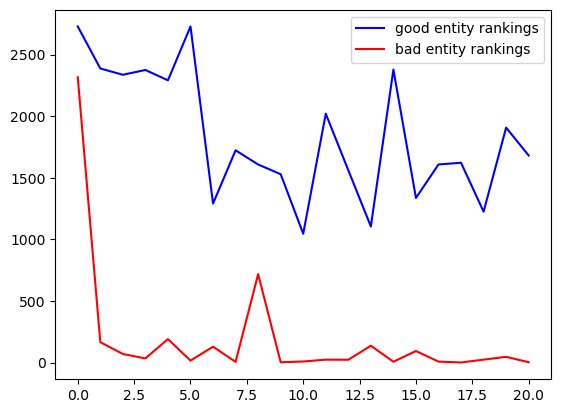

Total time taken for entire experiment 184.33171725273132


<Figure size 640x480 with 0 Axes>

In [15]:
base_experiment_4 = KnowledgeGraphMitigationExperiment("experiment_4_2","FB15k-237", file_paths,10, None, "tail", "base" , False, True)

base_experiment_4.run_experiment("base")

# Error with approach
There is an error with how I do things above:
```
Augustine of Hippo /people/person/gender male organism

```
I was explaining the head prediction of this fact instead of the tail prediction. And this is the definition of a necessary explanation: Given a tail prediction ⟨h, 𝑟, 𝑡⟩, a Kelpie explanation consists intuitively in the smallest set of training facts featuring h that have enabled us to predict the tail 𝑡 . The inverse applies for head prediction (smallest set of facts featuring t that enables the prediction of h). Hence the bunch of male and female organism facts


In [2]:
# https://stackoverflow.com/questions/33862420/ipython-notebook-how-to-reload-all-modules-in-a-specific-python-file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



Fact in question
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 231137.19ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Choosen good entity
female organism

Chosen bad entity
male organism

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/0w6w	/people/person/gender	/m/02zsn

Bad entity fact to explain /m/0w6w	/people/person/gender	/m/05zppz

Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0w6w,/people/person/gender,/m/02zsn>
Extracting promising facts for</m/0w6w, /people/person/gender, /m/02zsn>
	Analyzing sample 1 on 1: </m/0w6w, /people/person/gender, /m/05zppz>

	Computing relevance for sample 0 on 1: </m/0w6w, /people/person/gender, /m/05zppz>
		Running base post-training on entity /m/0w6w with no additions
		Running post-training on entity /m/0w6w removing samples: 
			</m/0w6w, /people/person/gender, /m/05zppz>
	Obtained relevance: 10182.929208487458
/m/0w6w;/people/person/gender;/m/02zsn
/m/0w6w;/people/person/gender;/m/05zppz:10182.92

train loss: 100%|██████████| 4092/4092 [00:00<00:00, 216700.23ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   1  487   11 ... 4907 3372 3202]
Good entity 487
Bad entity 1
Good entity rank 2
Bad entity rank 1


Round number 2
mitigator adds the following sample to  the dataset
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4094/4094 [00:00<00:00, 232830.48ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Tail predictions [   1   11  487 ... 8297 6956 1837]
Good entity 487
Bad entity 1
Good entity rank 3
Bad entity rank 1


Good entity rankings [2, 3]
Bad entity rankings [1, 1]


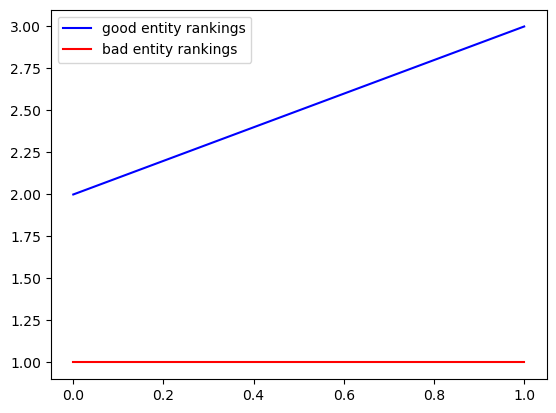

Total time taken for entire experiment 39.2457959651947


<Figure size 640x480 with 0 Axes>

In [3]:
from kelpie_commons import reduce_file_size
from kelpie_explanation_helpers import Dataset
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment

file_paths = ['results/experiment_3/train.txt','results/experiment_3/test.txt', 'results/experiment_3/valid.txt']

# head perspective experiment fails when the original fact is removed, lets keep it


kelpie_experiment_5 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_5",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = file_paths,
    size_of_original = 10, 
    fact_in_question = None, 
    prediction_type="tail", 
    experiment_type = "kelpie" , 
    reduceOriginal = False, 
    removeFactInQuestion = False
)


kelpie_experiment_5.run_experiment("kelpie")

# Choose a better example

The example above is quite boring as both facts are enabled by the same necessary explanation. Lets randomly chose facts from the randomly-sampled dataset to see if we can find a better example. 

Reducing file size of train, test, and valid files in the dataset FB15k-237
Original file contains 27211 triples.
New file './results/experiment_5/train.txt' created with 24489 triples.
Original file contains 2046 triples.
New file './results/experiment_5/test.txt' created with 1841 triples.
Original file contains 1753 triples.
New file './results/experiment_5/valid.txt' created with 1577 triples.

Fact in question
Writers Guild of America Awards 2006 /award/award_ceremony/awards_presented./award/award_honor/award_winner Michael Schur



train loss: 100%|██████████| 3682/3682 [00:00<00:00, 226649.26ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Choosen good entity
Vince Gill

Chosen bad entity
Michael Schur

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/027n06w	/award/award_ceremony/awards_presented./award/award_honor/award_winner	/m/02fn5r

Bad entity fact to explain /m/027n06w	/award/award_ceremony/awards_presented./award/award_honor/award_winner	/m/0bczgm

Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/027n06w,/award/award_ceremony/awards_presented./award/award_honor/award_winner,/m/02fn5r>
Extracting promising facts for</m/027n06w, /award/award_ceremony/awards_presented./award/award_honor/award_winner, /m/02fn5r>
	Analyzing sample 1 on 1: </m/01s695, /award/award_ceremony/awards_presented./award/award_honor/award_winner, /m/02fn5r>

	Computing relevance for sample 0 on 1: </m/01s695, /award/award_ceremony/awards_presented./award/award_honor/award_winner, /m/

train loss: 100%|██████████| 3680/3680 [00:00<00:00, 239366.01ex/s, loss={l.item():.0f}]


	 saving model...
	 done.


Round number 2
mitigator adds the following sample to  the dataset
2000 Grammy Awards /award/award_ceremony/awards_presented./award/award_honor/award_winner Vince Gill



train loss: 100%|██████████| 3682/3682 [00:00<00:00, 254158.41ex/s, loss={l.item():.0f}]


	 saving model...
	 done.


Good entity rankings [2646, 2073]
Bad entity rankings [2530, 2532]


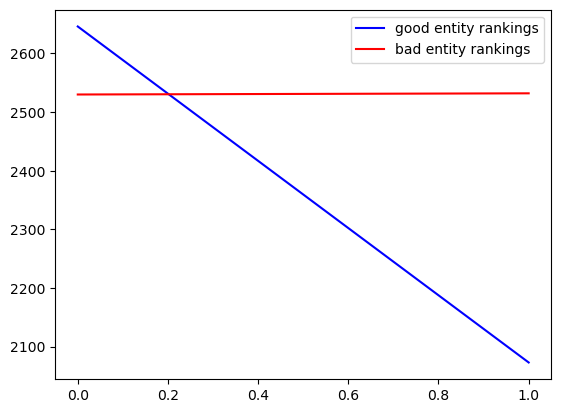

Total time taken for entire experiment 28.345093250274658


<Figure size 640x480 with 0 Axes>

In [30]:
original_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']


kelpie_experiment_6 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_5",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = file_paths,
    size_of_original = 90, 
    fact_in_question = None, 
    prediction_type="head", 
    experiment_type = "kelpie" , 
    reduceOriginal = True, 
    removeFactInQuestion = False
)

kelpie_experiment_6.run_experiment("kelpie")

In [2]:
%load_ext autoreload
%autoreload 2


Fact in question
Augustine of Hippo /people/person/gender male organism
[0 0 1]
</m/0w6w, /people/person/gender, /m/05zppz>



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 233355.88ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Choosen good entity
female organism

Chosen bad entity
male organism

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/0w6w	/people/person/gender	/m/02zsn

Bad entity fact to explain /m/0w6w	/people/person/gender	/m/05zppz

Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0w6w,/people/person/gender,/m/02zsn>
Extracting promising facts for</m/0w6w, /people/person/gender, /m/02zsn>
	Analyzing sample 1 on 15: </m/03gt0c5, /people/person/gender, /m/02zsn>
	Analyzing sample 2 on 15: </m/06wvfq, /people/person/gender, /m/02zsn>
	Analyzing sample 3 on 15: </m/014g22, /people/person/gender, /m/02zsn>
	Analyzing sample 4 on 15: </m/0clvcx, /people/person/gender, /m/02zsn>
	Analyzing sample 5 on 15: </m/03hh89, /people/person/gender, /m/02zsn>
	Analyzing sample 6 on 15: </m/03fwln, /people/person/gender, /m/02zsn>
	Analyzing sample 7 on

train loss: 100%|██████████| 4062/4062 [00:00<00:00, 231255.18ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [1164  928 1392 ... 3975 6350 5368]
Good entity rank 2657
Bad entity rank 2659


Round number 2
mitigator adds the following sample to  the dataset
Phyllis Logan /people/person/gender female organism



train loss: 100%|██████████| 4064/4064 [00:00<00:00, 203978.31ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [ 1164   490   928 ... 10032  4768  6068]
Good entity rank 2658
Bad entity rank 2660


Round number 3
disinformer adds the following sample to  the dataset
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4066/4066 [00:00<00:00, 204991.23ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [    0   490  2494 ... 10132  7110  4010]
Good entity rank 2637
Bad entity rank 2661


Round number 4
mitigator adds the following sample to  the dataset
Mary Steenburgen /people/person/gender female organism



train loss: 100%|██████████| 4068/4068 [00:00<00:00, 207166.36ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0  928 1164 ... 4705 4471 4306]
Good entity rank 2659
Bad entity rank 2662


Round number 5
disinformer adds the following sample to  the dataset
Ray Moyer /people/person/gender male organism



train loss: 100%|██████████| 4070/4070 [00:00<00:00, 233939.75ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0 1164  928 ... 7977 4019    1]
Good entity rank 2657
Bad entity rank 9863


Round number 6
mitigator adds the following sample to  the dataset
Diana Wynne Jones /people/person/gender female organism



train loss: 100%|██████████| 4072/4072 [00:00<00:00, 203007.28ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0  490 1164 ... 7170 8015 3090]
Good entity rank 2637
Bad entity rank 2662


Round number 7
disinformer adds the following sample to  the dataset
George Orwell /people/person/gender male organism



train loss: 100%|██████████| 4074/4074 [00:00<00:00, 232896.20ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0  928 1164 ... 4714 9761    1]
Good entity rank 2647
Bad entity rank 9862


Round number 8
mitigator adds the following sample to  the dataset
Rose Byrne /people/person/gender female organism



train loss: 100%|██████████| 4076/4076 [00:00<00:00, 232008.13ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0 1164  928 ... 4471 8036 6360]
Good entity rank 183
Bad entity rank 2663


Round number 9
disinformer adds the following sample to  the dataset
Wayne Dyer /people/person/gender male organism



train loss: 100%|██████████| 4078/4078 [00:00<00:00, 228265.25ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0  928 1164 ... 6934 9511 8383]
Good entity rank 2650
Bad entity rank 2663


Round number 10
mitigator adds the following sample to  the dataset
Clea DuVall /people/person/gender female organism



train loss: 100%|██████████| 4080/4080 [00:00<00:00, 233905.50ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0  864 1183 ... 6074 4529 6773]
Good entity rank 2660
Bad entity rank 2664


Round number 11
disinformer adds the following sample to  the dataset
Hensley Meulens /people/person/gender male organism



train loss: 100%|██████████| 4082/4082 [00:00<00:00, 233073.99ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0  928 1164 ... 8242 4775 4447]
Good entity rank 2658
Bad entity rank 2663


Round number 12
mitigator adds the following sample to  the dataset
Jessica Chastain /people/person/gender female organism



train loss: 100%|██████████| 4084/4084 [00:00<00:00, 208622.03ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0  928 1164 ... 8356 9336 7495]
Good entity rank 2627
Bad entity rank 2664


Round number 13
disinformer adds the following sample to  the dataset
Rick Baker /people/person/gender male organism



train loss: 100%|██████████| 4086/4086 [00:00<00:00, 203760.95ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0  928 1164 ... 9632 7717    1]
Good entity rank 2659
Bad entity rank 9859


Round number 14
mitigator adds the following sample to  the dataset
Marit Allen /people/person/gender female organism



train loss: 100%|██████████| 4088/4088 [00:00<00:00, 234101.75ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0  928 1164 ... 3428 6813 3245]
Good entity rank 2562
Bad entity rank 2665


Round number 15
disinformer adds the following sample to  the dataset
Mark Gatiss /people/person/gender male organism



train loss: 100%|██████████| 4090/4090 [00:00<00:00, 229270.46ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0  928 1164 ... 5369 7863 5509]
Good entity rank 2650
Bad entity rank 2664


Round number 16
mitigator adds the following sample to  the dataset
Priyanka Chopra /people/person/gender female organism



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 204295.77ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
Head predictions [   0 1164  928 ... 3988 2766 4968]
Good entity rank 2663
Bad entity rank 2665


Good entity rankings [2657, 2658, 2637, 2659, 2657, 2637, 2647, 183, 2650, 2660, 2658, 2627, 2659, 2562, 2650, 2663]
Bad entity rankings [2659, 2660, 2661, 2662, 9863, 2662, 9862, 2663, 2663, 2664, 2663, 2664, 9859, 2665, 2664, 2665]


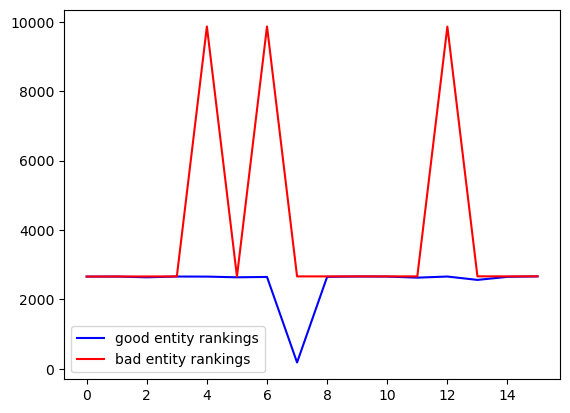

Total time taken for entire experiment 320.1555173397064


<Figure size 640x480 with 0 Axes>

In [3]:
from kelpie_commons import reduce_file_size
from kelpie_explanation_helpers import Dataset
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment


file_paths = ['results/experiment_3/train.txt','results/experiment_3/test.txt', 'results/experiment_3/valid.txt']

# head perspective experiment fails when the original fact is removed, lets keep it

fact_to_try = ["/m/0w6w", "/people/person/gender", "/m/05zppz"]
kelpie_experiment_6 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_6",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = file_paths,
    size_of_original = 10, 
    fact_in_question = fact_to_try, 
    prediction_type="head", 
    experiment_type = "kelpie" , 
    reduceOriginal = False, 
    removeFactInQuestion = False
)


kelpie_experiment_6.run_experiment("kelpie")

# Get explanations from the whole dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Fact in question
Augustine of Hippo /people/person/gender male organism
[0 0 1]
</m/0w6w, /people/person/gender, /m/05zppz>



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 214731.91ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  928, 1164, ..., 8968, 2941, 7679]), array([   1,  487,   11, ..., 2785, 4207, 6351]))]
Choosen good entity
female organism

Chosen bad entity
male organism

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/0w6w	/people/person/gender	/m/02zsn

Bad entity fact to explain /m/0w6w	/people/person/gender	/m/05zppz

Getting explanations from original dataset


train loss: 100%|██████████| 40932/40932 [00:00<00:00, 61255.01ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0w6w,/people/person/gender,/m/02zsn>
Extracting promising facts for</m/0w6w, /people/person/gender, /m/02zsn>
	Analyzing sample 1 on 1: </m/0w6w, /people/person/gender, /m/05zppz>

	Computing relevance for sample 0 on 1: </m/0w6w, /people/person/gender, /m/05zppz>
		Running base post-training on entity /m/0w6w with no additions
		Running post-training on entity /m/0w6w removing samples: 
			</m/0w6w, /people/person/gender, /m/05zppz>
	Obtained relevance: 12007.889446045187
/m/0w6w;/people/person/gender;/m/02zsn
/m/0w6w;/people/person/gender;/m/05zppz:12007.889446045187

Required time: 1.3717589378356934 seconds
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0w6w,/people/person/gender,/m/05zppz>
Extracting promising facts for</m/0w6w, /people/person/gender, /m/05zppz>
	Analyzing sample 1 on 1: </m/0w6w, /people/person/gender, /m/05zppz>

	C

train loss: 100%|██████████| 4092/4092 [00:00<00:00, 218716.13ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  928, 1329, ..., 6332, 3661, 6180]), array([   1,  487,   11, ..., 4907, 3372, 3202]))]
Tail predictions [   1  487   11 ... 4907 3372 3202]
Good entity 487
Bad entity 1
Good entity rank 2
Bad entity rank 1


Round number 2
mitigator adds the following sample to  the dataset
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4094/4094 [00:00<00:00, 231824.61ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  928, 1164, ..., 4939, 8968,    1]), array([   1,   11,  487, ..., 8297, 6956, 1837]))]
Tail predictions [   1   11  487 ... 8297 6956 1837]
Good entity 487
Bad entity 1
Good entity rank 3
Bad entity rank 1


Remaining budget for disinformer
[]

Remaining budget for mitigator
[]

Good entity rankings [2, 3]
Bad entity rankings [1, 1]


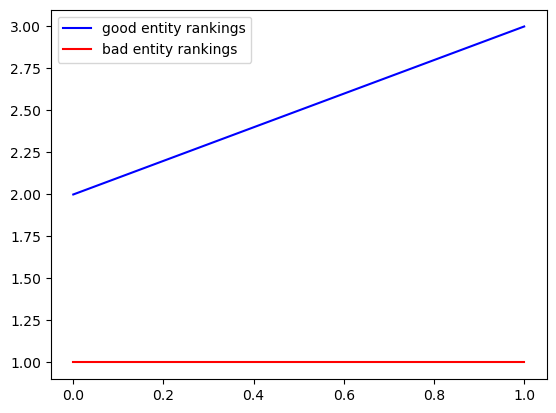

Total time taken for entire experiment 107.50339150428772


<Figure size 640x480 with 0 Axes>

In [11]:
%load_ext autoreload
%autoreload 2
from kelpie_commons import reduce_file_size
from kelpie_explanation_helpers import Dataset
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment
fact_to_try = ["/m/0w6w", "/people/person/gender", "/m/05zppz"]
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']
file_paths = ['results/experiment_3/train.txt','results/experiment_3/test.txt', 'results/experiment_3/valid.txt']
kelpie_experiment_7 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_7",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = file_paths,
    size_of_original = 10, 
    fact_in_question = fact_to_try, 
    prediction_type="tail", 
    experiment_type = "kelpie" , 
    reduceOriginal = False, 
    removeFactInQuestion = False,
    getExplanationsFromOriginalDataset = True,
    originalDatasetTrainPaths = original_dataset_file_paths
)


kelpie_experiment_7.run_experiment("kelpie")


Fact in question
Augustine of Hippo /people/person/gender male organism
[0 0 1]
</m/0w6w, /people/person/gender, /m/05zppz>



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 235886.37ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  928, 1164, ..., 8968, 2941, 7679]), array([   1,  487,   11, ..., 2785, 4207, 6351]))]
Choosen good entity
Pigface

Chosen bad entity
Augustine of Hippo

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/02_5x9	/people/person/gender	/m/05zppz

Bad entity fact to explain /m/0w6w	/people/person/gender	/m/05zppz

Getting explanations from original dataset


train loss: 100%|██████████| 40932/40932 [00:00<00:00, 61288.18ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/02_5x9,/people/person/gender,/m/05zppz>
Extracting promising facts for</m/02_5x9, /people/person/gender, /m/05zppz>
	Analyzing sample 1 on 333: </m/06sy4c, /people/person/gender, /m/05zppz>
	Analyzing sample 2 on 333: </m/01v90t, /people/person/gender, /m/05zppz>
	Analyzing sample 3 on 333: </m/01qdjm, /people/person/gender, /m/05zppz>
	Analyzing sample 4 on 333: </m/0241jw, /people/person/gender, /m/05zppz>
	Analyzing sample 5 on 333: </m/01trhmt, /people/person/gender, /m/05zppz>
	Analyzing sample 6 on 333: </m/03qhyn8, /people/person/gender, /m/05zppz>
	Analyzing sample 7 on 333: </m/01q4qv, /people/person/gender, /m/05zppz>
	Analyzing sample 8 on 333: </m/0210hf, /people/person/gender, /m/05zppz>
	Analyzing sample 9 on 333: </m/0534nr, /people/person/gender, /m/05zppz>
	Analyzing sample 10 on 333: </m/08jfkw, /people/person/gender, /m/05zppz>
	Analyzing sample 11 on 333: <

train loss: 100%|██████████| 4088/4088 [00:00<00:00, 229100.17ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1673, 1493, ..., 4718, 5948,    1]), array([   1,   11,  487, ..., 3470, 9617, 3411]))]
Head predictions [   0 1673 1493 ... 4718 5948    1]
Good entity rank 241
Bad entity rank 1


Round number 2
mitigator adds the following sample to  the dataset
Usher /people/person/gender male organism



train loss: 100%|██████████| 4090/4090 [00:00<00:00, 217098.68ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  618, 1673, ..., 3902, 8542, 3626]), array([   1,   11,  487, ..., 2927, 7399, 3714]))]
Head predictions [   0  618 1673 ... 3902 8542 3626]
Good entity rank 1339
Bad entity rank 1


Round number 3
disinformer adds the following sample to  the dataset
Lou Diamond Phillips /people/person/gender male organism



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 205580.48ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1073, 1667, ..., 9456, 7216, 7457]), array([   1,  487,   11, ..., 8032, 2905, 6496]))]
Head predictions [   0 1073 1667 ... 9456 7216 7457]
Good entity rank 1174
Bad entity rank 1


Round number 4
mitigator adds the following sample to  the dataset
Bill Nelson /people/person/gender male organism



train loss: 100%|██████████| 4094/4094 [00:00<00:00, 232779.98ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1493, 1329, ..., 4447, 5997, 7216]), array([   1,  487,   11, ..., 7515, 9316, 9747]))]
Head predictions [   0 1493 1329 ... 4447 5997 7216]
Good entity rank 1107
Bad entity rank 1


Round number 5
disinformer adds the following sample to  the dataset
Samuel M. Comer /people/person/gender male organism



train loss: 100%|██████████| 4096/4096 [00:00<00:00, 227150.80ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1073, 2494, ..., 4714, 6337,    1]), array([   1,  487,   11, ..., 6917, 4025, 8227]))]
Head predictions [   0 1073 2494 ... 4714 6337    1]
Good entity rank 154
Bad entity rank 1


Round number 6
mitigator adds the following sample to  the dataset
Lou Reed /people/person/gender male organism



train loss: 100%|██████████| 4098/4098 [00:00<00:00, 219759.35ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  166, 1183, ..., 4326, 7201, 7170]), array([   1,  487,   77, ..., 6721, 4591, 3039]))]
Head predictions [   0  166 1183 ... 4326 7201 7170]
Good entity rank 145
Bad entity rank 1


Round number 7
disinformer adds the following sample to  the dataset
Henri Matisse /people/person/gender male organism



train loss: 100%|██████████| 4100/4100 [00:00<00:00, 231202.98ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1493, 1329, ..., 6263, 4605, 5886]), array([   1,  487,   11, ..., 4693, 3028, 8688]))]
Head predictions [   0 1493 1329 ... 6263 4605 5886]
Good entity rank 582
Bad entity rank 1


Round number 8
mitigator adds the following sample to  the dataset
Brian Tyler /people/person/gender male organism



train loss: 100%|██████████| 4102/4102 [00:00<00:00, 231073.44ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1043,  618, ..., 4163, 8592, 9195]), array([   1,   11,  487, ..., 5437, 4690, 3388]))]
Head predictions [   0 1043  618 ... 4163 8592 9195]
Good entity rank 445
Bad entity rank 1


Round number 9
disinformer adds the following sample to  the dataset
Raza Murad /people/person/gender male organism



train loss: 100%|██████████| 4104/4104 [00:00<00:00, 231736.99ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1392, 2409, ..., 2868, 7309, 9721]), array([   1,  487,   11, ..., 9795, 7283, 8653]))]
Head predictions [   0 1392 2409 ... 2868 7309 9721]
Good entity rank 822
Bad entity rank 1


Round number 10
mitigator adds the following sample to  the dataset
Peter Gabriel /people/person/gender male organism



train loss: 100%|██████████| 4106/4106 [00:00<00:00, 235973.42ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,   10, 2409, ..., 9067, 5766, 7894]), array([   1,   11,  487, ..., 6212, 2954, 6007]))]
Head predictions [   0   10 2409 ... 9067 5766 7894]
Good entity rank 518
Bad entity rank 1


Round number 11
mitigator adds the following sample to  the dataset
Stephen Rea /people/person/gender male organism



train loss: 100%|██████████| 4108/4108 [00:00<00:00, 217536.56ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,   10, 1468, ..., 4203, 7127, 5683]), array([   1,   11,  487, ..., 9970, 6018, 3210]))]
Head predictions [   0   10 1468 ... 4203 7127 5683]
Good entity rank 648
Bad entity rank 1


Round number 12
mitigator adds the following sample to  the dataset
BT /people/person/gender male organism



train loss: 100%|██████████| 4110/4110 [00:00<00:00, 231963.37ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1164,  928, ..., 4223, 6657, 6785]), array([   1,   11,  487, ..., 3389, 3696, 7515]))]
Head predictions [   0 1164  928 ... 4223 6657 6785]
Good entity rank 3
Bad entity rank 1


Round number 13
mitigator adds the following sample to  the dataset
Rob Thomas /people/person/gender male organism



train loss: 100%|██████████| 4112/4112 [00:00<00:00, 233064.12ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1164,  928, ..., 4202, 6628, 6162]), array([   1,   11,  487, ..., 9894, 6523, 3050]))]
Head predictions [   0 1164  928 ... 4202 6628 6162]
Good entity rank 3
Bad entity rank 1


Round number 14
mitigator adds the following sample to  the dataset
Joel Madden /people/person/gender male organism



train loss: 100%|██████████| 4114/4114 [00:00<00:00, 235638.92ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1164,   10, ..., 9002, 8733, 5349]), array([   1,   11,   32, ..., 8476, 3921, 9316]))]
Head predictions [   0 1164   10 ... 9002 8733 5349]
Good entity rank 4
Bad entity rank 1


Round number 15
mitigator adds the following sample to  the dataset
Robert Morley /people/person/gender male organism



train loss: 100%|██████████| 4116/4116 [00:00<00:00, 233293.99ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  928, 1164, ..., 6050, 8757, 7820]), array([   1,   11,  487, ..., 5096, 5702, 8665]))]
Head predictions [   0  928 1164 ... 6050 8757 7820]
Good entity rank 2
Bad entity rank 1


Round number 16
mitigator adds the following sample to  the dataset
Billie Joe Armstrong /people/person/gender male organism



train loss: 100%|██████████| 4118/4118 [00:00<00:00, 232374.23ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  490, 1164, ..., 7469, 5575, 4984]), array([   1,   11,   32, ..., 5873, 6630, 6653]))]
Head predictions [   0  490 1164 ... 7469 5575 4984]
Good entity rank 4
Bad entity rank 1


Remaining budget for disinformer
[]

Remaining budget for mitigator
[]

Good entity rankings [241, 1339, 1174, 1107, 154, 145, 582, 445, 822, 518, 648, 3, 3, 4, 2, 4]
Bad entity rankings [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


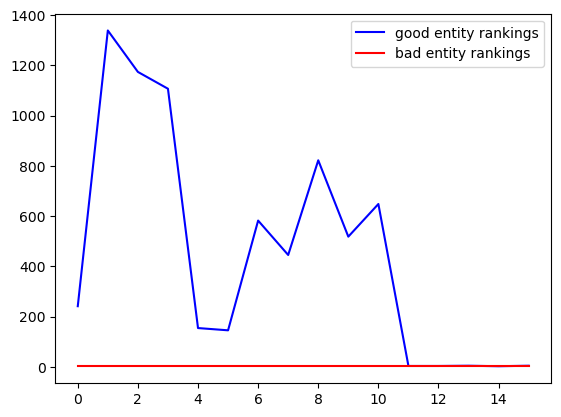

Total time taken for entire experiment 1615.726488828659


<Figure size 640x480 with 0 Axes>

In [8]:
%load_ext autoreload
%autoreload 2
from kelpie_commons import reduce_file_size
from kelpie_explanation_helpers import Dataset
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment
fact_to_try = ["/m/0w6w", "/people/person/gender", "/m/05zppz"]
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']
file_paths = ['results/experiment_3/train.txt','results/experiment_3/test.txt', 'results/experiment_3/valid.txt']
kelpie_experiment_7_1 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_7_1",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = file_paths,
    size_of_original = 10, 
    fact_in_question = fact_to_try, 
    prediction_type="head", 
    experiment_type = "kelpie" , 
    reduceOriginal = False, 
    removeFactInQuestion = False,
    getExplanationsFromOriginalDataset = True,
    originalDatasetTrainPaths = original_dataset_file_paths
)


kelpie_experiment_7_1.run_experiment("kelpie")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Fact in question
Augustine of Hippo /people/person/gender male organism
[0 0 1]
</m/0w6w, /people/person/gender, /m/05zppz>



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 235355.88ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  928, 1164, ..., 8968, 2941, 7679]), array([   1,  487,   11, ..., 2785, 4207, 6351]))]
Choosen good entity
Pigface

Chosen bad entity
Augustine of Hippo

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/02_5x9	/people/person/gender	/m/05zppz

Bad entity fact to explain /m/0w6w	/people/person/gender	/m/05zppz

Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/02_5x9,/people/person/gender,/m/05zppz>
Extracting promising facts for</m/02_5x9, /people/person/gender, /m/05zppz>
	Analyzing sample 1 on 21: </m/0w6w, /people/person/gender, /m/05zppz>
	Analyzing sample 2 on 21: </m/02j8nx, /people/person/gender, /m/05zppz>
	Analyzing sample 3 on 21: </m/026y23w, /people/person/gender, /m/05zppz>
	Analyzing sample 4 on 21: </m/034bs, /people/person/gender, /m/05zppz>
	Analyzing sample 5 on 21: </m/06s27s, /

train loss: 100%|██████████| 4070/4070 [00:00<00:00, 233686.75ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1468, 1667, ..., 8930, 7180, 9227]), array([   1,  487,   11, ...,    0, 2382, 1838]))]
Head predictions [   0 1468 1667 ... 8930 7180 9227]
Good entity rank 962
Bad entity rank 1


Round number 2
disinformer adds the following sample to  the dataset
Augustine of Hippo /people/person/gender male organism



train loss: 100%|██████████| 4072/4072 [00:00<00:00, 230974.87ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1043,  807, ..., 9858, 3584, 5858]), array([   1,  487,   11, ..., 3190, 8919, 5935]))]
Head predictions [   0 1043  807 ... 9858 3584 5858]
Good entity rank 1545
Bad entity rank 1


Round number 3
mitigator adds the following sample to  the dataset
Peter David /people/person/gender male organism



train loss: 100%|██████████| 4074/4074 [00:00<00:00, 205988.79ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1073, 1468, ..., 6438, 7726,    1]), array([   1,  487,   11, ...,    0, 2382, 2258]))]
Head predictions [   0 1073 1468 ... 6438 7726    1]
Good entity rank 1463
Bad entity rank 1


Round number 4
disinformer adds the following sample to  the dataset
George Orwell /people/person/gender male organism



train loss: 100%|██████████| 4076/4076 [00:00<00:00, 203589.05ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 2494, 1419, ..., 3528, 4571, 3609]), array([   1,  487,   11, ..., 8195, 5412, 5438]))]
Head predictions [   0 2494 1419 ... 3528 4571 3609]
Good entity rank 425
Bad entity rank 1


Round number 5
mitigator adds the following sample to  the dataset
George Orwell /people/person/gender male organism



train loss: 100%|██████████| 4078/4078 [00:00<00:00, 230790.85ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  864, 2127, ..., 6094, 5460,    1]), array([   1,  487,   11, ..., 1838,    0, 1167]))]
Head predictions [   0  864 2127 ... 6094 5460    1]
Good entity rank 2379
Bad entity rank 1


Round number 6
disinformer adds the following sample to  the dataset
Hensley Meulens /people/person/gender male organism



train loss: 100%|██████████| 4080/4080 [00:00<00:00, 230075.16ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1493, 1419, ..., 4579, 3976, 4197]), array([   1,  487,   11, ..., 4006, 8062, 9436]))]
Head predictions [   0 1493 1419 ... 4579 3976 4197]
Good entity rank 1283
Bad entity rank 1


Round number 7
mitigator adds the following sample to  the dataset
Wayne Dyer /people/person/gender male organism



train loss: 100%|██████████| 4082/4082 [00:00<00:00, 198584.36ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  864, 1329, ..., 8103, 4691, 9161]), array([   1,  487,   11, ..., 1270, 1559,  619]))]
Head predictions [   0  864 1329 ... 8103 4691 9161]
Good entity rank 1111
Bad entity rank 1


Round number 8
disinformer adds the following sample to  the dataset
Ray Moyer /people/person/gender male organism



train loss: 100%|██████████| 4084/4084 [00:00<00:00, 230623.19ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 2468, 1716, ..., 5596, 4108, 6063]), array([   1,  487,   11, ..., 6776, 6131, 3949]))]
Head predictions [   0 2468 1716 ... 5596 4108 6063]
Good entity rank 2306
Bad entity rank 1


Round number 9
mitigator adds the following sample to  the dataset
Charles Lang /people/person/gender male organism



train loss: 100%|██████████| 4086/4086 [00:00<00:00, 226043.32ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1392, 2409, ..., 8668, 4471, 4115]), array([   1,  487,   11, ..., 7583, 1755,    0]))]
Head predictions [   0 1392 2409 ... 8668 4471 4115]
Good entity rank 1072
Bad entity rank 1


Round number 10
disinformer adds the following sample to  the dataset
Austin Pendleton /people/person/gender male organism



train loss: 100%|██████████| 4088/4088 [00:00<00:00, 232653.29ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1183, 1673, ..., 9240, 4978, 8597]), array([   1,   11,  487, ..., 1838, 1167, 1334]))]
Head predictions [   0 1183 1673 ... 9240 4978 8597]
Good entity rank 2319
Bad entity rank 1


Round number 11
mitigator adds the following sample to  the dataset
Mike Nichols /people/person/gender male organism



train loss: 100%|██████████| 4090/4090 [00:00<00:00, 203800.50ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1673, 1183, ..., 2844, 9547, 6480]), array([   1,   11,  487, ..., 8664, 8223, 8177]))]
Head predictions [   0 1673 1183 ... 2844 9547 6480]
Good entity rank 587
Bad entity rank 1


Round number 12
disinformer adds the following sample to  the dataset
Rick Baker /people/person/gender male organism



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 216276.98ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1392, 1419, ..., 5386, 6682, 5316]), array([   1,  487,   11, ..., 6179, 9277, 9485]))]
Head predictions [   0 1392 1419 ... 5386 6682 5316]
Good entity rank 795
Bad entity rank 1


Round number 13
mitigator adds the following sample to  the dataset
BT /people/person/gender male organism



train loss: 100%|██████████| 4094/4094 [00:00<00:00, 233314.50ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0, 1164,  594, ..., 3749, 6094, 5157]), array([   1,  487,   11, ..., 8933, 6450, 3914]))]
Head predictions [   0 1164  594 ... 3749 6094 5157]
Good entity rank 4
Bad entity rank 1


Round number 14
disinformer adds the following sample to  the dataset
Wayne Dyer /people/person/gender male organism



train loss: 100%|██████████| 4096/4096 [00:00<00:00, 229898.69ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  928, 1164, ..., 4935, 5529, 5441]), array([   1,  487,   32, ..., 5040, 8797, 7829]))]
Head predictions [   0  928 1164 ... 4935 5529 5441]
Good entity rank 2
Bad entity rank 1


Round number 15
disinformer adds the following sample to  the dataset
Mark Gatiss /people/person/gender male organism



train loss: 100%|██████████| 4098/4098 [00:00<00:00, 217972.96ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([   0,  928, 1164, ..., 5947, 9990, 5150]), array([   1,  487,   11, ..., 7690, 6946, 3682]))]
Head predictions [   0  928 1164 ... 5947 9990 5150]
Good entity rank 2
Bad entity rank 1


Remaining budget for disinformer
[]

Remaining budget for mitigator
[]

Good entity rankings [962, 1545, 1463, 425, 2379, 1283, 1111, 2306, 1072, 2319, 587, 795, 4, 2, 2]
Bad entity rankings [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


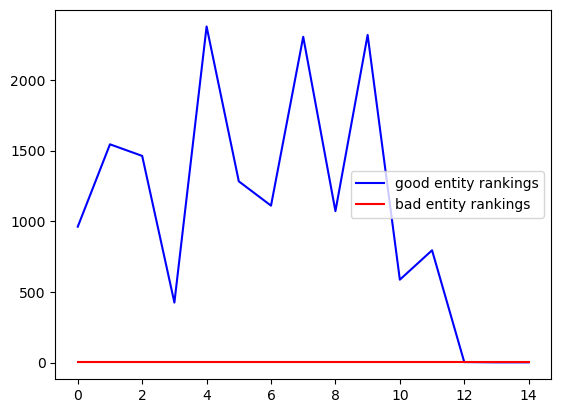

Total time taken for entire experiment 355.34545612335205


<Figure size 640x480 with 0 Axes>

In [12]:
%load_ext autoreload
%autoreload 2
from kelpie_commons import reduce_file_size
from kelpie_explanation_helpers import Dataset
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment
fact_to_try = ["/m/0w6w", "/people/person/gender", "/m/05zppz"]
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']
file_paths = ['results/experiment_3/train.txt','results/experiment_3/test.txt', 'results/experiment_3/valid.txt']
kelpie_experiment_7_2 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_7_2",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = file_paths,
    size_of_original = 10, 
    fact_in_question = fact_to_try, 
    prediction_type="head", 
    experiment_type = "kelpie" , 
    reduceOriginal = False, 
    removeFactInQuestion = False,
    getExplanationsFromOriginalDataset = False,
    originalDatasetTrainPaths = []
)


kelpie_experiment_7_2.run_experiment("kelpie")


In [1]:
%load_ext autoreload
%autoreload 2
from kelpie_explanation_helpers import Dataset

isASportsTeamOf = "/sports/sports_team/sport"
football = "/m/02vx4"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']
dataset = Dataset("FB15k-237", "\t", original_dataset_file_paths[0], original_dataset_file_paths[1], original_dataset_file_paths[2])


tail_id = dataset.get_id_for_entity_name(football)
relation_id = dataset.get_id_for_relation_name(isASportsTeamOf)

print(tail_id,relation_id)
triples = dataset.get_triples_for_tail_and_relation(
    relation_id=relation_id, 
    tail_id = tail_id
)

import json
fb15k237_label_mapping_file = open('entity2wikidata.json')
fb15k237_label_map = json.load(fb15k237_label_mapping_file)


for triple in triples:
    head = dataset.get_name_for_entity_id(triple[0])
    relation = dataset.get_name_for_relation_id(triple[1])
    tail = dataset.get_name_for_entity_id(triple[2])
    
    print(fb15k237_label_map[head]["label"], relation, fb15k237_label_map[tail]["label"])
    print(head, relation, tail)
    print(triple)
    print()
    
    



2596 32
Orlando Pirates /sports/sports_team/sport association football
/m/01xbpn /sports/sports_team/sport /m/02vx4
[2595   32 2596]

Estudiantes de La Plata /sports/sports_team/sport association football
/m/044crp /sports/sports_team/sport /m/02vx4
[2710   32 2596]

FC Alania Vladikavkaz /sports/sports_team/sport association football
/m/04czcb /sports/sports_team/sport /m/02vx4
[3120   32 2596]

Bulgaria national football team /sports/sports_team/sport association football
/m/0329qp /sports/sports_team/sport /m/02vx4
[3889   32 2596]

Everton F.C. /sports/sports_team/sport association football
/m/0mmd6 /sports/sports_team/sport /m/02vx4
[4084   32 2596]

Watford Football Club /sports/sports_team/sport association football
/m/0lmm3 /sports/sports_team/sport /m/02vx4
[4787   32 2596]

Getafe CF /sports/sports_team/sport association football
/m/03tc8d /sports/sports_team/sport /m/02vx4
[4910   32 2596]

F.C. Lorient /sports/sports_team/sport association football
/m/0byq0v /sports/sports_

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Reducing file size of train, test, and valid files in the dataset FB15k-237
Original file contains 272115 triples.
New file './results/experiment_8/train.txt' created with 27211 triples.
Original file contains 20466 triples.
New file './results/experiment_8/test.txt' created with 2046 triples.
Original file contains 17535 triples.
New file './results/experiment_8/valid.txt' created with 1753 triples.

Fact in question
Cardiff City F.C. /sports/sports_team/sport association football
[3555  110  782]
</m/0dwz3t, /sports/sports_team/sport, /m/02vx4>



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 231236.84ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([2363,  464,  585, ..., 8051, 4841, 8561]), array([ 754,  207, 1262, ..., 8623, 5356, 4399]))]
Choosen good entity
Golden State Warriors

Chosen bad entity
Los Angeles Angels

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/0jmj7	/sports/sports_team/sport	/m/02vx4

Bad entity fact to explain /m/04wmvz	/sports/sports_team/sport	/m/02vx4

Getting explanations from original dataset


train loss: 100%|██████████| 40932/40932 [00:00<00:00, 61275.95ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0jmj7,/sports/sports_team/sport,/m/02vx4>
Extracting promising facts for</m/0jmj7, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 1 on 41: </m/01xbpn, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 2 on 41: </m/04czcb, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 3 on 41: </m/02vx4, /sports/sport/pro_athletes./sports/pro_sports_played/athlete, /m/083qy7>
	Analyzing sample 4 on 41: </m/0329qp, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 5 on 41: </m/0mmd6, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 6 on 41: </m/0lmm3, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 7 on 41: </m/02vx4, /sports/sport/pro_athletes./sports/pro_sports_played/athlete, /m/026y23w>
	Analyzing sample 8 on 41: </m/0dwz3t, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 9 on 41: </m/03_lsr, /sports/sports_team/sport, /m/02vx4>
	Analyzing sampl

train loss: 100%|██████████| 4094/4094 [00:00<00:00, 214092.22ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([ 3555,  2364,  2363, ..., 10166,  3261,  3368]), array([ 782, 2364,  277, ..., 3140, 9852, 8807]))]
Head predictions [ 3555  2364  2363 ... 10166  3261  3368]
Good entity rank 53
Bad entity rank 3


Round number 2
mitigator adds the following sample to  the dataset
Cardiff City F.C. /sports/sports_team/sport association football



train loss: 100%|██████████| 4096/4096 [00:00<00:00, 207206.06ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([3555, 2363,  110, ..., 2730, 3449, 5365]), array([ 782, 2364,   70, ..., 9310, 8223, 4300]))]
Head predictions [3555 2363  110 ... 2730 3449 5365]
Good entity rank 372
Bad entity rank 2


Round number 3
disinformer adds the following sample to  the dataset
Watford Football Club /sports/sports_team/sport association football



train loss: 100%|██████████| 4098/4098 [00:00<00:00, 228303.13ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([3555, 2363, 1227, ..., 6023, 4369, 4003]), array([ 782, 2364,   91, ..., 5546, 5515, 8774]))]
Head predictions [3555 2363 1227 ... 6023 4369 4003]
Good entity rank 11
Bad entity rank 2


Round number 4
mitigator adds the following sample to  the dataset
association football /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country New Zealand



train loss: 100%|██████████| 4100/4100 [00:00<00:00, 213872.68ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([3555,  464, 2415, ..., 8099, 4371, 8480]), array([ 782, 1650, 2537, ..., 7765, 4955, 7305]))]
Head predictions [3555  464 2415 ... 8099 4371 8480]
Good entity rank 2
Bad entity rank 24


Round number 5
disinformer adds the following sample to  the dataset
association football /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country Colombia



train loss: 100%|██████████| 4102/4102 [00:00<00:00, 232421.95ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([3555, 2947,  249, ..., 6788, 5463, 8773]), array([ 782, 1650,  456, ..., 8311, 5549, 7673]))]
Head predictions [3555 2947  249 ... 6788 5463 8773]
Good entity rank 6
Bad entity rank 20


Round number 6
mitigator adds the following sample to  the dataset
association football /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country Colombia



train loss: 100%|██████████| 4104/4104 [00:00<00:00, 224903.30ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([3555, 2947,  249, ..., 4156, 7093, 7362]), array([ 782, 1650,   91, ..., 8928, 4155, 3722]))]
Head predictions [3555 2947  249 ... 4156 7093 7362]
Good entity rank 193
Bad entity rank 441


Round number 7
mitigator adds the following sample to  the dataset
Watford Football Club /sports/sports_team/sport association football



train loss: 100%|██████████| 4106/4106 [00:00<00:00, 234014.27ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([3555, 2363,  782, ..., 4305, 5092, 5814]), array([ 782, 1650, 1363, ..., 8955, 5776, 9847]))]
Head predictions [3555 2363  782 ... 4305 5092 5814]
Good entity rank 14
Bad entity rank 2


Remaining budget for disinformer
[]

Remaining budget for mitigator
[]

Good entity rankings [53, 372, 11, 2, 6, 193, 14]
Bad entity rankings [3, 2, 2, 24, 20, 441, 2]


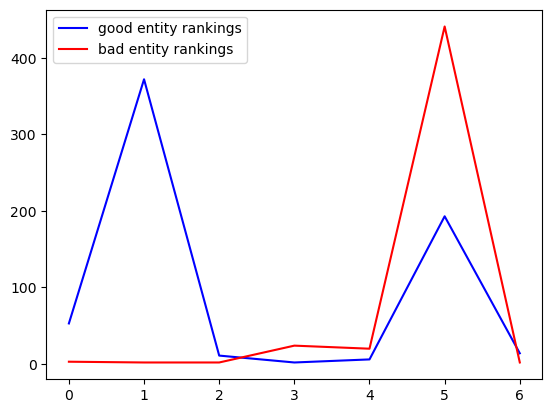

Total time taken for entire experiment 250.92630672454834


<Figure size 640x480 with 0 Axes>

In [1]:
%load_ext autoreload
%autoreload 2
from kelpie_commons import reduce_file_size
from kelpie_explanation_helpers import Dataset
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment

# cardiff city is a sports team of football
fact_to_investigate = ["/m/0dwz3t", "/sports/sports_team/sport" ,"/m/02vx4"]

original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

kelpie_experiment_8 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_8",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = original_dataset_file_paths,
    size_of_original = 10, 
    fact_in_question = fact_to_investigate, 
    prediction_type="head", 
    experiment_type = "kelpie" , 
    reduceOriginal = True, 
    removeFactInQuestion = False,
    getExplanationsFromOriginalDataset = True,
    originalDatasetTrainPaths = original_dataset_file_paths
)

kelpie_experiment_8.run_experiment("kelpie")

Reducing file size of train, test, and valid files in the dataset FB15k-237
Original file contains 272115 triples.
New file './results/experiment_9/train.txt' created with 27211 triples.
Original file contains 20466 triples.
New file './results/experiment_9/test.txt' created with 2046 triples.
Original file contains 17535 triples.
New file './results/experiment_9/valid.txt' created with 1753 triples.

Fact in question
Cardiff City F.C. /sports/sports_team/sport association football
[3583  138  434]
</m/0dwz3t, /sports/sports_team/sport, /m/02vx4>



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 234084.72ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([1527,  434, 2348, ..., 7419, 6861, 6571]), array([8344, 8932, 2977, ..., 2639, 1329, 1056]))]
Choosen good entity
Louvre Museum

Chosen bad entity
Michael Keaton

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/0dwz3t	/sports/sports_team/sport	/m/04gdr

Bad entity fact to explain /m/0dwz3t	/sports/sports_team/sport	/m/01j5ws

Getting explanations from original dataset


train loss: 100%|██████████| 40932/40932 [00:00<00:00, 61287.04ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0dwz3t,/sports/sports_team/sport,/m/04gdr>
Extracting promising facts for</m/0dwz3t, /sports/sports_team/sport, /m/04gdr>
	Analyzing sample 1 on 2: </m/0dwz3t, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 2 on 2: </m/0dwz3t, /sports/sports_team/colors, /m/01g5v>

	Computing relevance for sample 0 on 2: </m/0dwz3t, /sports/sports_team/colors, /m/01g5v>
		Running base post-training on entity /m/0dwz3t with no additions
		Running post-training on entity /m/0dwz3t removing samples: 
			</m/0dwz3t, /sports/sports_team/colors, /m/01g5v>
	Obtained relevance: 281.49106323535375

	Computing relevance for sample 1 on 2: </m/0dwz3t, /sports/sports_team/sport, /m/02vx4>
		Running post-training on entity /m/0dwz3t removing samples: 
			</m/0dwz3t, /sports/sports_team/sport, /m/02vx4>
	Obtained relevance: 951.2978690338232
/m/0dwz3t;/sports/sports_team/sport;/m/04gdr
/m/0dwz3t;/sp

train loss: 100%|██████████| 4094/4094 [00:00<00:00, 233549.33ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([1527, 2347, 2348, ..., 4747, 4737, 9719]), array([1056,  836,  998, ..., 9221, 8942, 3001]))]
Tail predictions [1056  836  998 ... 9221 8942 3001]
Good entity 8932
Bad entity 8344
Good entity rank 6671
Bad entity rank 4149


Round number 2
mitigator adds the following sample to  the dataset
Cardiff City F.C. /sports/sports_team/colors blue



train loss: 100%|██████████| 4096/4096 [00:00<00:00, 233571.29ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([ 405, 1527,  216, ..., 4874, 9770, 6054]), array([1056,  998,  756, ..., 5209, 4729, 6523]))]
Tail predictions [1056  998  756 ... 5209 4729 6523]
Good entity 8932
Bad entity 8344
Good entity rank 7665
Bad entity rank 3875


Round number 3
disinformer adds the following sample to  the dataset
Cardiff City F.C. /sports/sports_team/sport association football



train loss: 100%|██████████| 4098/4098 [00:00<00:00, 235333.08ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([ 3583,   997,  1055, ...,  9321, 10155,  4404]), array([ 434,  404, 1056, ..., 4403, 3237, 6426]))]
Tail predictions [ 434  404 1056 ... 4403 3237 6426]
Good entity 8932
Bad entity 8344
Good entity rank 3009
Bad entity rank 3704


Round number 4
mitigator adds the following sample to  the dataset
Cardiff City F.C. /sports/sports_team/sport association football



train loss: 100%|██████████| 4100/4100 [00:00<00:00, 234833.83ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([3583, 1055,  997, ..., 3193, 5259, 7212]), array([ 434,  404, 1056, ..., 6175, 8704, 6354]))]
Tail predictions [ 434  404 1056 ... 6175 8704 6354]
Good entity 8932
Bad entity 8344
Good entity rank 8669
Bad entity rank 5220


Remaining budget for disinformer
[]

Remaining budget for mitigator
[]

Good entity rankings [6671, 7665, 3009, 8669]
Bad entity rankings [4149, 3875, 3704, 5220]


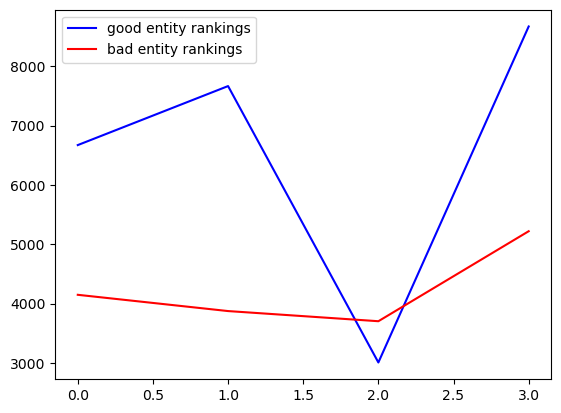

Total time taken for entire experiment 125.81794381141663


<Figure size 640x480 with 0 Axes>

In [8]:
kelpie_experiment_9 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_9",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = original_dataset_file_paths,
    size_of_original = 10, 
    fact_in_question = fact_to_investigate, 
    prediction_type="tail", 
    experiment_type = "kelpie" , 
    reduceOriginal = True, 
    removeFactInQuestion = False,
    
    getExplanationsFromOriginalDataset = True,
    originalDatasetTrainPaths = original_dataset_file_paths
)

kelpie_experiment_9.run_experiment("kelpie")

Reducing file size of train, test, and valid files in the dataset FB15k-237
Original file contains 272115 triples.
New file './results/experiment_10/train.txt' created with 27211 triples.
Original file contains 20466 triples.
New file './results/experiment_10/test.txt' created with 2046 triples.
Original file contains 17535 triples.
New file './results/experiment_10/valid.txt' created with 1753 triples.

Fact in question
Cardiff City F.C. /sports/sports_team/sport association football
[3589  119   83]
</m/0dwz3t, /sports/sports_team/sport, /m/02vx4>



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 231561.30ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([1274,  777, 2129, ..., 6553, 2896, 9691]), array([ 134,  100,  130, ..., 4852, 7195, 4313]))]
Choosen good entity
Los Angeles Rams

Chosen bad entity
Memphis Grizzlies

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/06x76	/sports/sports_team/sport	/m/02vx4

Bad entity fact to explain /m/0jmfv	/sports/sports_team/sport	/m/02vx4

Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/06x76,/sports/sports_team/sport,/m/02vx4>
Extracting promising facts for</m/06x76, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 1 on 2: </m/02vx4, /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country, /m/01ls2>
	Analyzing sample 2 on 2: </m/0690dn, /sports/sports_team/sport, /m/02vx4>

	Computing relevance for sample 0 on 2: </m/02vx4, /olympics/olympic_sport/athletes./olympics/olympic_athlete

train loss: 100%|██████████| 4090/4090 [00:00<00:00, 234040.54ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([2129, 1274, 2153, ..., 4621, 9194, 4674]), array([  75,  512,   57, ..., 6477, 8499, 4143]))]
Head predictions [2129 1274 2153 ... 4621 9194 4674]
Good entity rank 47
Bad entity rank 2


Round number 2
mitigator adds the following sample to  the dataset
E.S. Troyes A.C. /sports/sports_team/sport association football



train loss: 100%|██████████| 4092/4092 [00:00<00:00, 224948.12ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([2129, 1274,  777, ..., 4222, 8897, 6500]), array([ 658,  299,  134, ..., 9076, 9073, 8820]))]
Head predictions [2129 1274  777 ... 4222 8897 6500]
Good entity rank 3
Bad entity rank 2


Round number 3
disinformer adds the following sample to  the dataset
association football /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country Colombia



train loss: 100%|██████████| 4094/4094 [00:00<00:00, 203272.93ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([  49, 1274, 2129, ..., 3284, 6467, 7365]), array([ 191,  299,   75, ..., 5604, 9135, 5594]))]
Head predictions [  49 1274 2129 ... 3284 6467 7365]
Good entity rank 16
Bad entity rank 2


Round number 4
mitigator adds the following sample to  the dataset
association football /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/country Colombia



train loss: 100%|██████████| 4096/4096 [00:00<00:00, 231519.02ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([  49, 2129, 1274, ..., 7595, 7978, 6512]), array([ 654,  324,  154, ..., 5723, 3231, 9475]))]
Head predictions [  49 2129 1274 ... 7595 7978 6512]
Good entity rank 5
Bad entity rank 3


Remaining budget for disinformer
[]

Remaining budget for mitigator
[]

Good entity rankings [47, 3, 16, 5]
Bad entity rankings [2, 2, 2, 3]


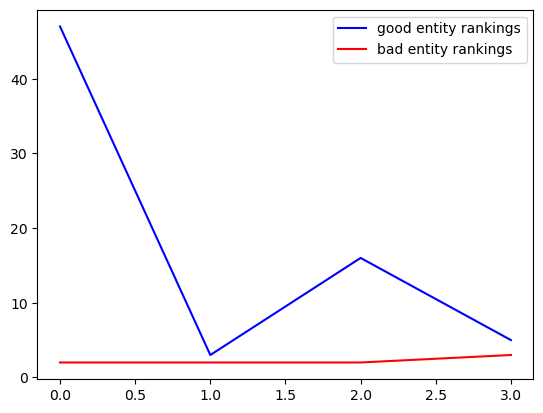

Total time taken for entire experiment 45.561755895614624


<Figure size 640x480 with 0 Axes>

In [2]:
kelpie_experiment_10 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_10",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = original_dataset_file_paths,
    size_of_original = 10, 
    fact_in_question = fact_to_investigate, 
    prediction_type="head", 
    experiment_type = "kelpie" , 
    reduceOriginal = True, 
    removeFactInQuestion = False,
    getExplanationsFromOriginalDataset = False,
    originalDatasetTrainPaths = []
)

kelpie_experiment_10.run_experiment("kelpie")

In [6]:
kelpie_experiment_11 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_11",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = original_dataset_file_paths,
    size_of_original = 20, 
    fact_in_question = fact_to_investigate, 
    prediction_type="tail", 
    experiment_type = "kelpie" , 
    reduceOriginal = True, 
    removeFactInQuestion = False,
    getExplanationsFromOriginalDataset = False,
    originalDatasetTrainPaths = []
)

kelpie_experiment_11.run_experiment("kelpie")

Reducing file size of train, test, and valid files in the dataset FB15k-237
Original file contains 272115 triples.
New file './results/experiment_11/train.txt' created with 54423 triples.
Original file contains 20466 triples.
New file './results/experiment_11/test.txt' created with 4093 triples.
Original file contains 17535 triples.
New file './results/experiment_11/valid.txt' created with 3507 triples.

Fact in question
Cardiff City F.C. /sports/sports_team/sport association football
[5231  104  724]
</m/0dwz3t, /sports/sports_team/sport, /m/02vx4>



train loss: 100%|██████████| 8186/8186 [00:00<00:00, 127317.86ex/s, loss={l.item():.0f}]


	 saving model...
	 done.
predictionsss!! [(array([ 623, 1050, 1338, ..., 7138, 8499, 4623]), array([  41, 2062,  722, ..., 5946, 9625, 9817]))]
Choosen good entity
Columbia Records

Chosen bad entity
United States of America

Initial Good entity rank 2
Initial Bad entity rank 1

Using Kelpie to find good entity samples and bad entity samples
Good entity fact to explain /m/0dwz3t	/sports/sports_team/sport	/m/015_1q

Bad entity fact to explain /m/0dwz3t	/sports/sports_team/sport	/m/09c7w0

Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0dwz3t,/sports/sports_team/sport,/m/015_1q>
Extracting promising facts for</m/0dwz3t, /sports/sports_team/sport, /m/015_1q>


KeyError: 5231

In [ ]:
fact_to_try = ["/m/0w6w", "/people/person/gender", "/m/05zppz"]
kelpie_experiment_11 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_11",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = original_dataset_file_paths,
    size_of_original = 20, 
    fact_in_question = fact_to_investigate, 
    prediction_type="head", 
    experiment_type = "kelpie" , 
    reduceOriginal = True, 
    removeFactInQuestion = False,
    getExplanationsFromOriginalDataset = False,
    originalDatasetTrainPaths = []
)

kelpie_experiment_11.run_experiment("kelpie")

# July 25 Meeting



## Experiment 7_1
**Prediction Type:** Head Prediction  
Explanations Source: The whole FB15K-237  
Fact: Augustine of Hippo /people/person/gender male organism

Good Entity: Pigface (rank 2) 
Bad Entity:  Augustine of Hippo (Rank 1)


Good Entity Explanations    
Billie Joe Armstrong /people/person/gender male organism 
Robert Morley /people/person/gender male organism  
Rob Thomas /people/person/gender male organism  
BT /people/person/gender male organism  
Stephen Rea /people/person/gender male organism  
Peter Gabriel /people/person/gender male organism  
Brian Tyler /people/person/gender male organism  
Lou Reed /people/person/gender male organism  
Bill Nelson /people/person/gender male organism  
Usher /people/person/gender male organism  



Bad Entity Explanations   
Raza Murad /people/person/gender male organism     
Henri Matisse /people/person/gender male organism  
Samuel M. Comer /people/person/gender male organism  
Paul Soloway /people/person/gender male organism  
Lou Diamond Phillips /people/person/gender male organism  
Augustine of Hippo /people/person/gender male organism   

Caveats: Not all explanations added as there was a bug in adding unseen entities to the Dataset interface in the Kelpie models.  (12 and 6)


<img src="./img/7_1.png"/>



## Experiment 7_2
**Perspective:** Head Prediction  
Explanations Source: reduced FB15K-237  

Good Entity: Pigface (rank 2)   
Bad Entity:  Augustine of Hippo (Rank 1)  
 

Good Entity Explanations  
BT /people/person/gender male organism  
Mike Nichols /people/person/gender male organism  
Charles Lang /people/person/gender male organism  
Wayne Dyer /people/person/gender male organism  
George Orwell /people/person/gender male organism  
Peter David /people/person/gender male organism  
Augustine of Hippo /people/person/gender male organism  


Bad Entity Explanations  
Mark Gatiss /people/person/gender male organism  
Wayne Dyer /people/person/gender male organism  
Rick Baker /people/person/gender male organism  
Austin Pendleton /people/person/gender male organism  
Ray Moyer /people/person/gender male organism  
Hensley Meulens /people/person/gender male organism  
George Orwell /people/person/gender male organism  
Augustine of Hippo /people/person/gender male organism  



<img src="./img/7_2.png"/>

Maybe show 8?

# What is happening?




Good examples for head prediction: 
```python

# Augustine of Hippo /people/person/gender male organism
fact_to_try = ["/m/0w6w", "/people/person/gender", "/m/05zppz"]


```python
# cardiff city is a sports team of football
fact_to_investigate = ["/m/0dwz3t", "/sports/sports_team/sport" ,"/m/02vx4"]
```


Look at relation types and their effects in explanations
```
# relation types
ONE_TO_ONE="1-1"
ONE_TO_MANY="1-N"
MANY_TO_ONE="N-1"
MANY_TO_MANY="N-N"

```




# Exploring the explanations sorrounding a fact

Fact:
```python
# cardiff city is a sports team of football
fact_to_investigate = ["/m/0dwz3t", "/sports/sports_team/sport" ,"/m/02vx4"]
```

Type of relation? N to 1 Does this matter?   



Questions I am trying to answer?

What are the facts that enabled the prediction of cardiff city as a football team?   -> necessary head

What are the facts that enabled the prediction of  football team as the type of sports team cardiff city is?   -> necessary tail

What are the facts that confuse the model to predict something else as a sports team of football for Caodif City? I suspect this set should be less than the other ones as the relation type lends itself easily to predict other things 

What are the facts that confuse the model to predict something else as Caodif City for sports team of football? Same as above  




## necessary - head  
```
association football /sports/sport/pro_athletes./sports/pro_sports_played/athlete Craig Bellamy
association football /sports/sport/pro_athletes./sports/pro_sports_played/athlete Warren Feeney
association football /sports/sport/pro_athletes./sports/pro_sports_played/athlete Junichi Inamoto
association football /sports/sport/pro_athletes./sports/pro_sports_played/athlete Ross Turnbull
association football /sports/sport/pro_athletes./sports/pro_sports_played/athlete Kasper Schmeichel
Crystal Palace F.C. /sports/sports_team/sport association football
Barnsley Football Club /sports/sports_team/sport association football

```

## necessary-tail  

```
defender /sports/sports_position/players./sports/sports_team_roster/team Cardiff City F.C.
Cardiff City F.C. /soccer/football_team/current_roster./soccer/football_roster_position/position goalkeeper
Cardiff City F.C. /soccer/football_team/current_roster./soccer/football_roster_position/position forward
forward /sports/sports_position/players./sports/sports_team_roster/team Cardiff City F.C.
Cardiff City F.C. /soccer/football_team/current_roster./sports/sports_team_roster/position forward
midfielder /sports/sports_position/players./sports/sports_team_roster/team Cardiff City F.C.
goalkeeper /sports/sports_position/players./sports/sports_team_roster/team Cardiff City F.C.
```




## sufficient-head 

```
NotImplementedError:
```



## sufficient-tail 

```
defender /sports/sports_position/players./sports/sports_team_roster/team Cardiff City F.C.
Cardiff City F.C. /soccer/football_team/current_roster./soccer/football_roster_position/position forward
forward /sports/sports_position/players./sports/sports_team_roster/team Cardiff City F.C.
Cardiff City F.C. /soccer/football_team/current_roster./sports/sports_team_roster/position forward
midfielder /sports/sports_position/players./sports/sports_team_roster/team Cardiff City F.C.
goalkeeper /sports/sports_position/players./sports/sports_team_roster/team Cardiff City F.C.
```
   


# Fact 2  

Relation Type-: N to 1
```
# Augustine of Hippo /people/person/gender male organism
fact_to_try = ["/m/0w6w", "/people/person/gender", "/m/05zppz"]

```

## necessary - head  
```
Jean-Paul Sartre /people/person/gender male organism
Gottfried Wilhelm Leibniz /people/person/gender male organism
Thomas Aquinas /people/person/gender male organism
Jerry Seinfeld /people/person/gender male organism
John Locke /people/person/gender male organism
Ludwig Wittgenstein /people/person/gender male organism
Martin Donovan /people/person/gender male organism
Jack Kerouac /people/person/gender male organism
John McCain /people/person/gender male organism
Lars von Trier /people/person/gender male organism

```

## necessary-tail  

```
Thomas Aquinas /influence/influence_node/influenced_by Augustine of Hippo
Augustine of Hippo /people/person/religion Catholicism
Augustine of Hippo /organization/organization_founder/organizations_founded Catholic Church
Augustine of Hippo /influence/influence_node/influenced_by Plato
Augustine of Hippo /people/person/profession physician
Augustine of Hippo /influence/influence_node/influenced_by Jesus Christ
Augustine of Hippo /people/person/profession writer
Augustine of Hippo /people/person/nationality Algeria
Ludwig Wittgenstein /influence/influence_node/influenced_by Augustine of Hippo

```




## sufficient-head 

```
NotImplementedError:
```



## sufficient-tail 

```
Thomas Aquinas /influence/influence_node/influenced_by Augustine of Hippo
Augustine of Hippo /influence/influence_node/influenced_by Aristotle
Augustine of Hippo /people/person/religion Catholicism
Augustine of Hippo /influence/influence_node/influenced_by Plato
Augustine of Hippo /people/person/profession physician
Augustine of Hippo /influence/influence_node/influenced_by Jesus Christ
Augustine of Hippo /people/person/profession writer
Martin Heidegger /influence/influence_node/influenced_by Augustine of Hippo
Augustine of Hippo /people/person/nationality Algeria
Ludwig Wittgenstein /influence/influence_node/influenced_by Augustine of Hippo

```

In [10]:

from kelpie_commons import reduce_file_size, getKelpieExplanation
from kelpie_explanation_helpers import trainComplExKelpie, Dataset, load_dataset, facts_to_samples, all_hyperparams
from knowledge_graph_simulation_experiment import transformKelpieExplanationsToSamples

def train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths,
    dataset_name="FB15k-237", 
    model_name = "ComplEx"
):
    perspective = "head" if prediction_type == "tail" else "tail"
    dataset = Dataset(
    name = dataset_name, 
    separator = "\t", 
    load = True,
    train_path = original_dataset_file_paths[0], 
    test_path = original_dataset_file_paths[1], 
    valid_path = original_dataset_file_paths[2]
    )
    
    try:
        with open(model_path, 'rb') as f:
            print("No need to train, model is already present")
    except FileNotFoundError:
        print("Model not found. Starting training...")
        trainComplExKelpie(model_path , "FB15k-237", load_existing_model=True, dataset=dataset)

    explanations = getKelpieExplanation(
        dataset=dataset_name,
        max_epochs=200,
        batch_size=2048,
        learning_rate=0.01,
        dimension=50,
        negative_samples_ratio=5,
        regularizer_weight=2.0,
        margin=2,
        model_path=model_path,
        facts_to_explain = [fact_to_investigate] ,
        perspective = perspective, 
        mode=mode,
        dataset_object=dataset, 
        model_name = model_name,
        all_hyperparams_object = all_hyperparams[model_name][dataset_name]

    )

    explanations = transformKelpieExplanationsToSamples(explanations, dataset, perspective, mode)
    print(explanations)
    return explanations

    

In [3]:
# necessary head

fact_to_investigate = "/m/0dwz3t" + "\t"+ "/sports/sports_team/sport" +"\t"+"/m/02vx4"+"\n"
model_path = "./original_testing.pt"
prediction_type = "head"
mode = "necessary"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths,
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0dwz3t,/sports/sports_team/sport,/m/02vx4>
Extracting promising facts for</m/0dwz3t, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 1 on 425: </m/0223bl, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 2 on 425: </m/05jx2d, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 3 on 425: </m/02vx4, /sports/sport/pro_athletes./sports/pro_sports_played/athlete, /m/02rnns>
	Analyzing sample 4 on 425: </m/02vx4, /media_common/netflix_genre/titles, /m/01l2b3>
	Analyzing sample 5 on 425: </m/0182r9, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 6 on 425: </m/07s8qm7, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 7 on 425: </m/059nf5, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 8 on 425: </m/02vx4, /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/olympics, /m/0kbvb>
	Analyzing sample 9 on 425: </m/02vx

[[344, 125, 7389],
 [344, 125, 1494],
 [344, 125, 12164],
 [344, 125, 9415],
 [344, 125, 3326],
 [343, 80, 344],
 [5788, 80, 344]]

In [4]:
# necessary tail

fact_to_investigate = "/m/0dwz3t" + "\t"+ "/sports/sports_team/sport" +"\t"+"/m/02vx4"+"\n"
model_path = "./original_testing.pt"
prediction_type = "tail"
mode = "necessary"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths,
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0dwz3t,/sports/sports_team/sport,/m/02vx4>
Extracting promising facts for</m/0dwz3t, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 1 on 19: </m/02sdk9v, /sports/sports_position/players./sports/sports_team_roster/team, /m/0dwz3t>
	Analyzing sample 2 on 19: </m/0dwz3t, /sports/sports_team/colors, /m/06fvc>
	Analyzing sample 3 on 19: </m/01s3v, /sports/sports_team_location/teams, /m/0dwz3t>
	Analyzing sample 4 on 19: </m/0czmk1, /sports/pro_athlete/teams./sports/sports_team_roster/team, /m/0dwz3t>
	Analyzing sample 5 on 19: </m/0dwz3t, /soccer/football_team/current_roster./sports/sports_team_roster/position, /m/02sdk9v>
	Analyzing sample 6 on 19: </m/0dwz3t, /sports/sports_team/colors, /m/019sc>
	Analyzing sample 7 on 19: </m/0dgrmp, /sports/sports_position/players./sports/sports_team_roster/team, /m/0dwz3t>
	Analyzing sample 8 on 19: </m/0dwz3t, /soccer

[[399, 130, 8397],
 [8397, 5, 117],
 [8397, 5, 11],
 [11, 130, 8397],
 [8397, 4, 11],
 [9, 130, 8397],
 [117, 130, 8397],
 [8397, 4, 399]]

In [5]:
# sufficient - head

fact_to_investigate = "/m/0dwz3t" + "\t"+ "/sports/sports_team/sport" +"\t"+"/m/02vx4"+"\n"
model_path = "./original_testing.pt"
prediction_type = "head"
mode = "sufficient"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths,
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0dwz3t,/sports/sports_team/sport,/m/02vx4>
Extracting promising facts for</m/0dwz3t, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 1 on 425: </m/0223bl, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 2 on 425: </m/05jx2d, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 3 on 425: </m/02vx4, /sports/sport/pro_athletes./sports/pro_sports_played/athlete, /m/02rnns>
	Analyzing sample 4 on 425: </m/02vx4, /media_common/netflix_genre/titles, /m/01l2b3>
	Analyzing sample 5 on 425: </m/0182r9, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 6 on 425: </m/07s8qm7, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 7 on 425: </m/059nf5, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 8 on 425: </m/02vx4, /olympics/olympic_sport/athletes./olympics/olympic_athlete_affiliation/olympics, /m/0kbvb>
	Analyzing sample 9 on 425: </m/03w7

NotImplementedError: 

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# sufficient - tail

fact_to_investigate = "/m/0dwz3t" + "\t"+ "/sports/sports_team/sport" +"\t"+"/m/02vx4"+"\n"
model_path = "./original_testing.pt"
prediction_type = "tail"
mode = "sufficient"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths
    
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0dwz3t,/sports/sports_team/sport,/m/02vx4>
Extracting promising facts for</m/0dwz3t, /sports/sports_team/sport, /m/02vx4>
	Analyzing sample 1 on 19: </m/02sdk9v, /sports/sports_position/players./sports/sports_team_roster/team, /m/0dwz3t>
	Analyzing sample 2 on 19: </m/0dwz3t, /sports/sports_team/colors, /m/06fvc>
	Analyzing sample 3 on 19: </m/01s3v, /sports/sports_team_location/teams, /m/0dwz3t>
	Analyzing sample 4 on 19: </m/0czmk1, /sports/pro_athlete/teams./sports/sports_team_roster/team, /m/0dwz3t>
	Analyzing sample 5 on 19: </m/0dwz3t, /soccer/football_team/current_roster./sports/sports_team_roster/position, /m/02sdk9v>
	Analyzing sample 6 on 19: </m/0dwz3t, /sports/sports_team/colors, /m/019sc>
	Analyzing sample 7 on 19: </m/0dgrmp, /sports/sports_position/players./sports/sports_team_roster/team, /m/0dwz3t>
	Analyzing sample 8 on 19: </m/0dwz3t, /soccer

[[399, 130, 8397],
 [8397, 5, 11],
 [11, 130, 8397],
 [8397, 4, 11],
 [9, 130, 8397],
 [117, 130, 8397]]

## Augustine of Hippo


In [7]:
# necessary - head
 # ["/m/0w6w", "/people/person/gender", "/m/05zppz"]
fact_to_investigate = "/m/0w6w" + "\t"+ "/people/person/gender" +"\t"+"/m/05zppz"+"\n"
model_path = "./original_testing.pt"
prediction_type = "head"
mode = "necessary"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths
    
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0w6w,/people/person/gender,/m/05zppz>
Extracting promising facts for</m/0w6w, /people/person/gender, /m/05zppz>
	Analyzing sample 1 on 2928: </m/02bfmn, /people/person/gender, /m/05zppz>
	Analyzing sample 2 on 2928: </m/03vrnh, /people/person/gender, /m/05zppz>
	Analyzing sample 3 on 2928: </m/03p01x, /people/person/gender, /m/05zppz>
	Analyzing sample 4 on 2928: </m/0kr5_, /people/person/gender, /m/05zppz>
	Analyzing sample 5 on 2928: </m/0686zv, /people/person/gender, /m/05zppz>
	Analyzing sample 6 on 2928: </m/01q32bd, /people/person/gender, /m/05zppz>
	Analyzing sample 7 on 2928: </m/02g3w, /people/person/gender, /m/05zppz>
	Analyzing sample 8 on 2928: </m/01fyzy, /people/person/gender, /m/05zppz>
	Analyzing sample 9 on 2928: </m/0280mv7, /people/person/gender, /m/05zppz>
	Analyzing sample 10 on 2928: </m/05_k56, /people/person/gender, /m/05zppz>
	Analyzin

[[1053, 43, 141],
 [3729, 43, 141],
 [566, 43, 141],
 [2575, 43, 141],
 [3768, 43, 141],
 [7016, 43, 141],
 [1997, 43, 141],
 [1989, 43, 141],
 [2131, 43, 141],
 [2435, 43, 141]]

In [8]:
# necessary tail
fact_to_investigate = "/m/0w6w" + "\t"+ "/people/person/gender" +"\t"+"/m/05zppz"+"\n"
model_path = "./original_testing.pt"
prediction_type = "tail"
mode = "necessary"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths
    
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0w6w,/people/person/gender,/m/05zppz>
Extracting promising facts for</m/0w6w, /people/person/gender, /m/05zppz>
	Analyzing sample 1 on 15: </m/0w6w, /people/person/religion, /m/0c8wxp>
	Analyzing sample 2 on 15: </m/04hcw, /influence/influence_node/influenced_by, /m/0w6w>
	Analyzing sample 3 on 15: </m/099bk, /influence/influence_node/influenced_by, /m/0w6w>
	Analyzing sample 4 on 15: </m/0w6w, /people/person/profession, /m/0cbd2>
	Analyzing sample 5 on 15: </m/0w6w, /organization/organization_founder/organizations_founded, /m/02vxy_>
	Analyzing sample 7 on 15: </m/02ln1, /influence/influence_node/influenced_by, /m/0w6w>
	Analyzing sample 8 on 15: </m/07kb5, /influence/influence_node/influenced_by, /m/0w6w>
	Analyzing sample 9 on 15: </m/0w6w, /influence/influence_node/influenced_by, /m/05qmj>
	Analyzing sample 10 on 15: </m/045bg, /influence/influence_node/in

[[566, 21, 13618],
 [13618, 82, 1771],
 [13618, 226, 12773],
 [13618, 21, 5739],
 [13618, 17, 6351],
 [13618, 21, 7604],
 [13618, 17, 243],
 [13618, 48, 190],
 [7016, 21, 13618]]

In [9]:
# sufficient tail
fact_to_investigate = "/m/0w6w" + "\t"+ "/people/person/gender" +"\t"+"/m/05zppz"+"\n"
model_path = "./original_testing.pt"
prediction_type = "tail"
mode = "sufficient"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths
    
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0w6w,/people/person/gender,/m/05zppz>
Extracting promising facts for</m/0w6w, /people/person/gender, /m/05zppz>
	Analyzing sample 1 on 15: </m/0w6w, /people/person/religion, /m/0c8wxp>
	Analyzing sample 2 on 15: </m/04hcw, /influence/influence_node/influenced_by, /m/0w6w>
	Analyzing sample 3 on 15: </m/099bk, /influence/influence_node/influenced_by, /m/0w6w>
	Analyzing sample 4 on 15: </m/0w6w, /people/person/profession, /m/0cbd2>
	Analyzing sample 5 on 15: </m/0w6w, /organization/organization_founder/organizations_founded, /m/02vxy_>
	Analyzing sample 6 on 15: </m/0372p, /influence/influence_node/influenced_by, /m/0w6w>
	Analyzing sample 7 on 15: </m/02ln1, /influence/influence_node/influenced_by, /m/0w6w>
	Analyzing sample 8 on 15: </m/07kb5, /influence/influence_node/influenced_by, /m/0w6w>
	Analyzing sample 9 on 15: </m/0w6w, /influence/influence_node/infl

[[566, 21, 13618],
 [13618, 21, 3448],
 [13618, 82, 1771],
 [13618, 21, 5739],
 [13618, 17, 6351],
 [13618, 21, 7604],
 [13618, 17, 243],
 [3728, 21, 13618],
 [13618, 48, 190],
 [7016, 21, 13618]]

# Exploring more relation types

In [11]:
%load_ext autoreload
%autoreload 2
gender_relation = "/people/person/gender" 
sports_team = "/sports/sports_team/sport"

dataset = Dataset(
    name = "FB15K-237", 
    separator = "\t", 
    load = True,
    train_path = original_dataset_file_paths[0], 
    test_path = original_dataset_file_paths[1], 
    valid_path = original_dataset_file_paths[2]
    )



gender_id = dataset.get_id_for_relation_name(gender_relation)
sports_id = dataset.get_id_for_relation_name(sports_team)

print(gender_relation,dataset.relation_2_type[gender_id])
print(sports_team, dataset.relation_2_type[sports_id])

/people/person/gender N-1
/sports/sports_team/sport N-1


In [ ]:
%load_ext autoreload
%autoreload 2

In [12]:
one_to_one_relations = dataset.get_relations_for_relation_type("1-1")

for relation_id in one_to_one_relations:
    print(relation_id, dataset.get_name_for_relation_id(relation_id))

56 /location/hud_county_place/place
81 /education/educational_institution_campus/educational_institution
144 /base/aareas/schema/administrative_area/capital
146 /education/educational_institution/campuses
190 /location/us_county/county_seat
192 /people/person/spouse_s./people/marriage/spouse
194 /location/capital_of_administrative_division/capital_of./location/administrative_division_capital_relationship/administrative_division
228 /dataworld/gardening_hint/split_to
230 /film/film/prequel


In [13]:


marriage = "/people/person/spouse_s./people/marriage/spouse"
marriage_id = dataset.get_id_for_relation_name(marriage)
print(marriage_id)

# calculated based on this piece of code in the Kelpie LP models
#             if d > 1.2 and average_tails_per_head > 1.2:
#                 self.relation_2_type[relation] = MANY_TO_MANY
#             elif average_heads_per_tail > 1.2 and average_tails_per_head <= 1.2:
#                 self.relation_2_type[relation] = MANY_TO_ONE
#             elif average_heads_per_tail <= 1.2 and average_tails_per_head > 1.2:
#                 self.relation_2_type[relation] = ONE_TO_MANY
#             else:
#                 self.relation_2_type[relation] = ONE_TO_ONE


192


In [14]:
marriages = dataset.get_triples_for_relation(marriage_id)
import json
fb15k237_label_mapping_file = open('entity2wikidata.json')
fb15k237_label_map = json.load(fb15k237_label_mapping_file)


for marriage in marriages:
    head = dataset.get_name_for_entity_id(marriage[0])
    relation = dataset.get_name_for_relation_id(marriage[1])
    tail = dataset.get_name_for_entity_id(marriage[2])
    
    print(fb15k237_label_map[head]["label"], relation, fb15k237_label_map[tail]["label"])
    print(head, relation, tail)
    print()

    print()
        

train [ 535  192 2458]
train [3925  192 2404]
train [3982  192  407]
train [4416  192  427]
train [4596  192 4597]
train [5604  192   30]
train [5558  192 6387]
train [6677  192 6678]
train [ 769  192 6953]
train [5910  192 2614]
train [4018  192 1856]
train [7130  192 4443]
train [2263  192 1645]
train [4505  192 8262]
train [2186  192 6422]
train [   7  192 8345]
train [2299  192 4047]
train [3888  192 3372]
train [7764  192 9123]
train [9291  192 9292]
train [1420  192 3189]
train [4283  192  689]
train [7780  192  366]
train [9675  192 1482]
train [ 819  192 6333]
train [9794  192 8623]
train [3628  192 3629]
train [7250  192 7832]
train [2592  192  488]
train [ 5749   192 10127]
train [10238   192 10239]
train [5131  192 6491]
train [2053  192  137]
train [2476  192 2042]
train [6247  192 2771]
train [ 407  192 4973]
train [2037  192  732]
train [7095  192 2872]
train [9720  192 1821]
train [ 2427   192 11250]
train [2614  192 5910]
train [ 4684   192 11568]
train [2379  192 6655]

KeyError: '/m/02kxbx3'

# Explain a 1to1 fact

```
Mary Steenburgen /people/person/spouse_s./people/marriage/spouse Malcolm McDowell
/m/014g22 /people/person/spouse_s./people/marriage/spouse /m/01c65z
```

## necessary - head  
```
Malcolm McDowell /film/actor/film./film/performance/film I Spy
Malcolm McDowell /people/person/languages English
Malcolm McDowell /film/actor/film./film/performance/film Fist of the North Star
Malcolm McDowell /people/person/profession film producer
Malcolm McDowell /people/person/places_lived./people/place_lived/location Leeds
London Academy of Music and Dramatic Art /education/educational_institution/students_graduates./education/education/student Malcolm McDowell
Malcolm McDowell /film/actor/film./film/performance/film Bolt
Malcolm McDowell /film/actor/film./film/performance/film The Book of Eli
Malcolm McDowell /award/award_nominee/award_nominations./award/award_nomination/award National Society of Film Critics Award for Best Actor
Malcolm McDowell /people/person/spouse_s./people/marriage/type_of_union marriage
Malcolm McDowell /people/person/nationality United Kingdom
Malcolm McDowell /base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency United States dollar
Malcolm McDowell /film/actor/film./film/performance/film Halloween
Heroes /tv/tv_program/regular_cast./tv/regular_tv_appearance/actor Malcolm McDowell
Malcolm McDowell /award/award_nominee/award_nominations./award/award_nomination/nominated_for A Clockwork Orange
Malcolm McDowell /people/person/profession actor
Malcolm McDowell /film/actor/film./film/performance/film A Clockwork Orange

```

## necessary-tail  

```
Mary Steenburgen /people/person/spouse_s./people/marriage/spouse Ted Danson
Mary Steenburgen /film/actor/film./film/performance/film The Help
Powers Boothe /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen
Mary Steenburgen /film/actor/film./film/performance/film Gulliver's Travels
Mary Steenburgen /award/award_winner/awards_won./award/award_honor/award_winner Jessica Chastain
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/award_nominee Kevin Dunn
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/award_nominee Jessica Chastain
Mary Steenburgen /people/person/profession film producer
Mary Steenburgen /people/person/profession actor
Mary Steenburgen /award/award_winner/awards_won./award/award_honor/award_winner Octavia Spencer
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/award_nominee Joan Allen
Mary Steenburgen /people/person/spouse_s./people/marriage/type_of_union marriage
David Paymer /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen
Mary Steenburgen /film/actor/film./film/performance/film Philadelphia
Viola Davis /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen
E. G. Marshall /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/award_nominee Anthony Hopkins
James Woods /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/nominated_for The Help
Allison Janney /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen


```




## sufficient-head 

```


```



## sufficient-tail 

```
Mary Steenburgen /people/person/spouse_s./people/marriage/spouse Ted Danson
Mary Steenburgen /film/actor/film./film/performance/film The Help
Mary Steenburgen /people/person/spouse_s./people/marriage/type_of_union marriage
Mary Steenburgen /film/actor/film./film/performance/film Gulliver's Travels
Mary Steenburgen /people/person/profession film producer
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/nominated_for The Help
Mary Steenburgen /people/person/profession actor
```

In [15]:
# /m/014g22 /people/person/spouse_s./people/marriage/spouse /m/01c65z

fact_to_investigate = "/m/014g22" + "\t"+ "/people/person/spouse_s./people/marriage/spouse" +"\t"+"/m/01c65z"+"\n"
model_path = "./original_testing.pt"
prediction_type = "head"
mode = "necessary"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths
    
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/014g22,/people/person/spouse_s./people/marriage/spouse,/m/01c65z>
Extracting promising facts for</m/014g22, /people/person/spouse_s./people/marriage/spouse, /m/01c65z>
	Analyzing sample 1 on 17: </m/01c65z, /base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency, /m/09nqf>
	Analyzing sample 2 on 17: </m/01c65z, /award/award_nominee/award_nominations./award/award_nomination/nominated_for, /m/05ldxl>
	Analyzing sample 3 on 17: </m/01c65z, /people/person/nationality, /m/07ssc>
	Analyzing sample 4 on 17: </m/053mhx, /education/educational_institution/students_graduates./education/education/student, /m/01c65z>
	Analyzing sample 5 on 17: </m/01c65z, /film/actor/film./film/performance/film, /m/04ydr95>	Analyzing sample 6 on 17: </m/01c65z, /people/person/profession, /m/01d_h8>
	Analyzing sample 7 on 17: </m/01c65z, /film/actor/film./fi

[[12165, 6, 6349],
 [12165, 100, 160],
 [12165, 6, 12896],
 [12165, 17, 215],
 [12165, 66, 4242],
 [7740, 22, 12165],
 [12165, 6, 5939],
 [12165, 6, 3274],
 [12165, 19, 2960],
 [12165, 85, 434],
 [12165, 48, 382],
 [12165, 60, 90],
 [12165, 6, 10368],
 [9354, 1, 12165],
 [12165, 38, 7977],
 [12165, 17, 862],
 [12165, 6, 7977]]

In [16]:
fact_to_investigate = "/m/014g22" + "\t"+ "/people/person/spouse_s./people/marriage/spouse" +"\t"+"/m/01c65z"+"\n"
model_path = "./original_testing.pt"
prediction_type = "tail"
mode = "necessary"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths
    
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/014g22,/people/person/spouse_s./people/marriage/spouse,/m/01c65z>
Extracting promising facts for</m/014g22, /people/person/spouse_s./people/marriage/spouse, /m/01c65z>
	Analyzing sample 1 on 83: </m/014g22, /award/award_nominee/award_nominations./award/award_nomination/award_nominee, /m/02jsgf>
	Analyzing sample 2 on 83: </m/014g22, /film/actor/film./film/performance/film, /m/0ds3t5x>
	Analyzing sample 3 on 83: </m/014g22, /film/actor/film./film/performance/film, /m/02d413>
	Analyzing sample 4 on 83: </m/014g22, /award/award_nominee/award_nominations./award/award_nomination/award_nominee, /m/043kzcr>
	Analyzing sample 5 on 83: </m/02bkdn, /award/award_nominee/award_nominations./award/award_nomination/award_nominee, /m/014g22>
	Analyzing sample 6 on 83: </m/017149, /award/award_nominee/award_nominations./award/award_nomination/award_nominee, /m/014g22>
	Analyzi

[[3888, 192, 3372],
 [3888, 6, 271],
 [3398, 8, 3888],
 [3888, 6, 192],
 [3888, 3, 2285],
 [3888, 8, 10817],
 [3888, 8, 2285],
 [3888, 17, 215],
 [3888, 17, 862],
 [3888, 3, 1362],
 [3888, 8, 3838],
 [3888, 85, 434],
 [7642, 8, 3888],
 [3888, 6, 15],
 [1070, 8, 3888],
 [4214, 8, 3888],
 [3888, 8, 326],
 [4195, 8, 3888],
 [3888, 38, 271],
 [1663, 8, 3888]]

In [17]:
fact_to_investigate = "/m/014g22" + "\t"+ "/people/person/spouse_s./people/marriage/spouse" +"\t"+"/m/01c65z"+"\n"
model_path = "./original_testing.pt"
prediction_type = "tail"
mode = "sufficient"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths
    
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/014g22,/people/person/spouse_s./people/marriage/spouse,/m/01c65z>
Extracting promising facts for</m/014g22, /people/person/spouse_s./people/marriage/spouse, /m/01c65z>
	Analyzing sample 1 on 83: </m/014g22, /award/award_nominee/award_nominations./award/award_nomination/award_nominee, /m/02jsgf>
	Analyzing sample 2 on 83: </m/014g22, /film/actor/film./film/performance/film, /m/0ds3t5x>
	Analyzing sample 3 on 83: </m/014g22, /film/actor/film./film/performance/film, /m/02d413>
	Analyzing sample 4 on 83: </m/014g22, /award/award_nominee/award_nominations./award/award_nomination/award_nominee, /m/043kzcr>
	Analyzing sample 5 on 83: </m/017149, /award/award_nominee/award_nominations./award/award_nomination/award_nominee, /m/014g22>
	Analyzing sample 6 on 83: </m/014g22, /award/award_nominee/award_nominations./award/award_nomination/award_nominee, /m/057_yx>
	Analyzi

[[3888, 192, 3372],
 [3888, 6, 271],
 [3888, 85, 434],
 [3888, 6, 192],
 [3888, 17, 215],
 [3888, 38, 271],
 [3888, 17, 862]]

# Exploring a N-N fact

In [18]:
from kelpie_explanation_helpers import trainComplExKelpie, Dataset, load_dataset, facts_to_samples, all_hyperparams

one_to_one_relations = dataset.get_relations_for_relation_type("N-N")

for relation_id in one_to_one_relations:
    print(relation_id, dataset.get_name_for_relation_id(relation_id))

0 /location/country/form_of_government
1 /tv/tv_program/regular_cast./tv/regular_tv_appearance/actor
2 /media_common/netflix_genre/titles
3 /award/award_winner/awards_won./award/award_honor/award_winner
4 /soccer/football_team/current_roster./sports/sports_team_roster/position
5 /soccer/football_team/current_roster./soccer/football_roster_position/position
6 /film/actor/film./film/performance/film
7 /award/award_category/nominees./award/award_nomination/nominated_for
8 /award/award_nominee/award_nominations./award/award_nomination/award_nominee
9 /music/performance_role/regular_performances./music/group_membership/role
10 /award/award_category/winners./award/award_honor/ceremony
12 /award/award_winning_work/awards_won./award/award_honor/award_winner
13 /film/film/release_date_s./film/film_regional_release_date/film_release_region
14 /film/film/language
15 /location/location/contains
17 /people/person/profession
18 /location/statistical_region/religions./location/religion_percentage/rel

In [19]:
soccer_team_roster = "/soccer/football_player/current_team./sports/sports_team_roster/team"

soccer_team_roster_id = dataset.get_id_for_relation_name(soccer_team_roster)
print(soccer_team_roster_id)

roster_triples = dataset.get_triples_for_relation(soccer_team_roster_id)
import json
fb15k237_label_mapping_file = open('entity2wikidata.json')
fb15k237_label_map = json.load(fb15k237_label_mapping_file)


for fact in roster_triples:
    head = dataset.get_name_for_entity_id(fact[0])
    relation = dataset.get_name_for_relation_id(fact[1])
    tail = dataset.get_name_for_entity_id(fact[2])
    
    print(fb15k237_label_map[head]["label"], relation, fb15k237_label_map[tail]["label"])
    print(head, relation, tail)
    print()

    print()

170
train [1901  170 1902]
train [1982  170 1983]
train [3293  170 3294]
train [3326  170 3327]
train [1494  170 3606]
train [5488  170 5489]
train [5787  170 5788]
train [6112  170 6113]
train [6532  170 6533]
train [6593  170 6594]
train [6746  170  913]
train [2431  170 6842]
train [4919  170 6967]
train [7204  170 7205]
train [5411  170 7351]
train [7423  170 7424]
train [6245  170 8223]
train [8295  170 8256]
train [8431  170 6955]
train [2431  170 2967]
train [1722  170 8523]
train [8645  170 5638]
train [8807  170 3438]
train [7923  170 8876]
train [7626  170 7206]
train [8950  170 7006]
train [8317  170 7914]
train [8645  170 7097]
train [9390  170 6474]
train [5147  170 5717]
train [9415  170 9194]
train [7389  170 3438]
train [6039  170 9635]
train [6932  170 6918]
train [7389  170 9689]
train [5411  170 9733]
train [8317  170 6551]
train [9847  170 1860]
train [9962  170 9413]
train [ 813  170 8256]
train [5147  170 1495]
train [6829  170 3829]
train [ 1722   170 10052]
trai

# Explain a N-N fact

```
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Notts County F.C.
/m/07h1h5 /soccer/football_player/current_team./sports/sports_team_roster/team /m/029q3k
```

## necessary - head  
```
Jonathan Forte /sports/pro_athlete/teams./sports/sports_team_roster/team Notts County F.C.
Felix Bastians /sports/pro_athlete/teams./sports/sports_team_roster/team Notts County F.C.
James Walker /soccer/football_player/current_team./sports/sports_team_roster/team Notts County F.C.
forward /sports/sports_position/players./sports/sports_team_roster/team Notts County F.C.
Notts County F.C. /soccer/football_team/current_roster./soccer/football_roster_position/position forward
Notts County F.C. /soccer/football_team/current_roster./soccer/football_roster_position/position goalkeeper
Jonathan Forte /soccer/football_player/current_team./sports/sports_team_roster/team Notts County F.C.
Notts County F.C. /soccer/football_team/current_roster./sports/sports_team_roster/position defender
goalkeeper /sports/sports_position/players./sports/sports_team_roster/team Notts County F.C.
Delroy Facey /sports/pro_athlete/teams./sports/sports_team_roster/team Notts County F.C.
midfielder /sports/sports_position/players./sports/sports_team_roster/team Notts County F.C.
Notts County F.C. /soccer/football_team/current_roster./soccer/football_roster_position/position defender
Notts County F.C. /soccer/football_team/current_roster./sports/sports_team_roster/position midfielder
Felix Bastians /soccer/football_player/current_team./sports/sports_team_roster/team Notts County F.C.
defender /sports/sports_position/players./sports/sports_team_roster/team Notts County F.C.
James Walker /sports/pro_athlete/teams./sports/sports_team_roster/team Notts County F.C.
Notts County F.C. /soccer/football_team/current_roster./sports/sports_team_roster/position goalkeeper
```

## necessary-tail  

```
Kasper Schmeichel /people/person/place_of_birth Copenhagen
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Coventry City F.C.
Kasper Schmeichel /people/person/places_lived./people/place_lived/location Copenhagen
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Bury F.C.
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Falkirk F.C.
association football /sports/sport/pro_athletes./sports/pro_sports_played/athlete Kasper Schmeichel
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Leicester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Leicester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Manchester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Darlington F.C.
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Denmark national football team
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Denmark national football team
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Leeds United A.F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Leeds United A.F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Coventry City F.C.
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Manchester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Cardiff City F.C.
```




## sufficient-head 

```

```



## sufficient-tail 

```
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Coventry City F.C.
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Bury F.C.
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Falkirk F.C.
association football /sports/sport/pro_athletes./sports/pro_sports_played/athlete Kasper Schmeichel
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Leicester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Leicester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Darlington F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Coventry City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Cardiff City F.C.
```


In [20]:
# /m/07h1h5 /soccer/football_player/current_team./sports/sports_team_roster/team /m/029q3k
# necessary head
fact_to_investigate = "/m/07h1h5" + "\t"+ "/soccer/football_player/current_team./sports/sports_team_roster/team" +"\t"+"/m/029q3k"+"\n"
model_path = "./original_testing.pt"
prediction_type = "tail"
mode = "sufficient"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths
    
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/07h1h5,/soccer/football_player/current_team./sports/sports_team_roster/team,/m/029q3k>
Extracting promising facts for</m/07h1h5, /soccer/football_player/current_team./sports/sports_team_roster/team, /m/029q3k>
	Analyzing sample 1 on 17: </m/07h1h5, /soccer/football_player/current_team./sports/sports_team_roster/team, /m/02s2lg>
	Analyzing sample 2 on 17: </m/07h1h5, /sports/pro_athlete/teams./sports/sports_team_roster/team, /m/02q1hz>
	Analyzing sample 3 on 17: </m/07h1h5, /sports/pro_athlete/teams./sports/sports_team_roster/team, /m/01634x>
	Analyzing sample 4 on 17: </m/07h1h5, /sports/pro_athlete/teams./sports/sports_team_roster/team, /m/01xn7x1>
	Analyzing sample 5 on 17: </m/07h1h5, /people/person/place_of_birth, /m/01lfy>
	Analyzing sample 6 on 17: </m/07h1h5, /soccer/football_player/current_team./sports/sports_team_roster/team, /m/01rlzn>
	Analyzing sam

[[3326, 40, 8392],
 [3326, 40, 11238],
 [3326, 40, 2936],
 [344, 125, 3326],
 [3326, 40, 8604],
 [3326, 170, 8604],
 [3326, 170, 9194],
 [3326, 170, 8392],
 [3326, 170, 8397]]

In [21]:
fact_to_investigate = "/m/07h1h5" + "\t"+ "/soccer/football_player/current_team./sports/sports_team_roster/team" +"\t"+"/m/029q3k"+"\n"
model_path = "./original_testing.pt"
prediction_type = "head"
mode = "necessary"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths
    
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/07h1h5,/soccer/football_player/current_team./sports/sports_team_roster/team,/m/029q3k>
Extracting promising facts for</m/07h1h5, /soccer/football_player/current_team./sports/sports_team_roster/team, /m/029q3k>
	Analyzing sample 1 on 17: </m/02sdk9v, /sports/sports_position/players./sports/sports_team_roster/team, /m/029q3k>
	Analyzing sample 2 on 17: </m/029q3k, /soccer/football_team/current_roster./sports/sports_team_roster/position, /m/0dgrmp>
	Analyzing sample 3 on 17: </m/029q3k, /soccer/football_team/current_roster./soccer/football_roster_position/position, /m/02sdk9v>
	Analyzing sample 4 on 17: </m/029q3k, /soccer/football_team/current_roster./soccer/football_roster_position/position, /m/02_j1w>
	Analyzing sample 5 on 17: </m/0d9v9q, /soccer/football_player/current_team./sports/sports_team_roster/team, /m/029q3k>
	Analyzing sample 6 on 17: </m/0djvzd, /s

[[6932, 40, 8901],
 [12281, 40, 8901],
 [6039, 170, 8901],
 [11, 130, 8901],
 [8901, 5, 11],
 [8901, 5, 117],
 [6932, 170, 8901],
 [8901, 4, 399],
 [117, 130, 8901],
 [6954, 40, 8901],
 [9, 130, 8901],
 [8901, 5, 399],
 [8901, 4, 9],
 [12281, 170, 8901],
 [399, 130, 8901],
 [6039, 40, 8901],
 [8901, 4, 117]]

In [22]:
fact_to_investigate = "/m/07h1h5" + "\t"+ "/soccer/football_player/current_team./sports/sports_team_roster/team" +"\t"+"/m/029q3k"+"\n"
model_path = "./original_testing.pt"
prediction_type = "tail"
mode = "necessary"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths
    
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/07h1h5,/soccer/football_player/current_team./sports/sports_team_roster/team,/m/029q3k>
Extracting promising facts for</m/07h1h5, /soccer/football_player/current_team./sports/sports_team_roster/team, /m/029q3k>
	Analyzing sample 1 on 17: </m/07h1h5, /soccer/football_player/current_team./sports/sports_team_roster/team, /m/02s2lg>
	Analyzing sample 2 on 17: </m/07h1h5, /sports/pro_athlete/teams./sports/sports_team_roster/team, /m/02q1hz>
	Analyzing sample 3 on 17: </m/07h1h5, /sports/pro_athlete/teams./sports/sports_team_roster/team, /m/01634x>
	Analyzing sample 4 on 17: </m/07h1h5, /sports/pro_athlete/teams./sports/sports_team_roster/team, /m/01xn7x1>
	Analyzing sample 5 on 17: </m/07h1h5, /people/person/place_of_birth, /m/01lfy>
	Analyzing sample 6 on 17: </m/07h1h5, /soccer/football_player/current_team./sports/sports_team_roster/team, /m/01rlzn>
	Analyzing sam

[[3326, 24, 7893],
 [3326, 40, 8392],
 [3326, 66, 7893],
 [3326, 40, 11238],
 [3326, 40, 2936],
 [344, 125, 3326],
 [3326, 40, 8604],
 [3326, 170, 8604],
 [3326, 170, 8808],
 [3326, 170, 9194],
 [3326, 40, 3327],
 [3326, 170, 3327],
 [3326, 40, 4243],
 [3326, 170, 4243],
 [3326, 170, 8392],
 [3326, 40, 8808],
 [3326, 170, 8397]]

# Explore 1toN

In [5]:
%load_ext autoreload
%autoreload 2
from kelpie_explanation_helpers import  Dataset

original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']
dataset = Dataset(
    name = "FB15K-237", 
    separator = "\t", 
    load = True,
    train_path = original_dataset_file_paths[0], 
    test_path = original_dataset_file_paths[1], 
    valid_path = original_dataset_file_paths[2]
    )


one_to_n_relations = dataset.get_relations_for_relation_type("1-N")
for relation_id in one_to_n_relations:
    print(relation_id, dataset.get_name_for_relation_id(relation_id))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
55 /film/special_film_performance_type/film_performance_type./film/performance/film
63 /organization/role/leaders./organization/leadership/organization
78 /base/locations/continents/countries_within
87 /location/country/second_level_divisions
94 /sports/sports_team_location/teams
102 /film/director/film
125 /sports/sport/pro_athletes./sports/pro_sports_played/athlete
126 /award/hall_of_fame/inductees./award/hall_of_fame_induction/inductee
132 /sports/sports_league/teams./sports/sports_league_participation/team
149 /medicine/disease/notable_people_with_this_condition
161 /people/marriage_union_type/unions_of_this_type./people/marriage/location_of_ceremony
165 /government/political_party/politicians_in_this_party./government/political_party_tenure/politician
211 /tv/non_character_role/tv_regular_personal_appearances./tv/tv_regular_personal_appearance/person
215 /base/americancomedy/celebrity_impressio

In [9]:
film_director = "/film/director/film"

film_director_id = dataset.get_id_for_relation_name(film_director)

film_director_triples = dataset.get_triples_for_relation(film_director_id)
import json
fb15k237_label_mapping_file = open('entity2wikidata.json')
fb15k237_label_map = json.load(fb15k237_label_mapping_file)


for triple in film_director_triples:
    head = dataset.get_name_for_entity_id(triple[0])
    relation = dataset.get_name_for_relation_id(triple[1])
    tail = dataset.get_name_for_entity_id(triple[2])
    try:
        print(fb15k237_label_map[head]["label"], relation, fb15k237_label_map[tail]["label"])
        print(head, relation, tail)
        print()
    except:
        continue

        

Jiang Wen /film/director/film New York, I Love You
/m/042rnl /film/director/film /m/02z3r8t

Garry Marshall /film/director/film Valentine's Day
/m/02ndbd /film/director/film /m/06_wqk4

Chris Weitz /film/director/film The Golden Compass
/m/034bgm /film/director/film /m/04w7rn

Robert Rodriguez /film/director/film Sin City
/m/06cv1 /film/director/film /m/04tqtl

Ben Affleck /film/director/film Gone Baby Gone
/m/0151w_ /film/director/film /m/0dsvzh

Michael Moore /film/director/film Sicko
/m/0jw67 /film/director/film /m/04dsnp

Alan Parker /film/director/film Mississippi Burning
/m/01ycck /film/director/film /m/0yyg4

Roland Emmerich /film/director/film Stargate
/m/032v0v /film/director/film /m/070g7

Lawrence Kasdan /film/director/film Mumford
/m/02fcs2 /film/director/film /m/0c57yj

Ang Lee /film/director/film Lust, Caution
/m/0h1p /film/director/film /m/0dx8gj

Jon Favreau /film/director/film Cowboys & Aliens
/m/01twdk /film/director/film /m/0cc5mcj

John Ford /film/director/film The 

# 1toN fact to explain

```
Quentin Tarantino /film/director/film Django Unchained
/m/0693l /film/director/film /m/0gwjw0c

```

## necessary - head  
```
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Django Unchained /film/film/language English
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Golden Globe Award for Best Screenplay
Michael Minkler /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Christoph Waltz /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Academy Award for Best Writing, Original Screenplay
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award BAFTA Award for Best Original Screenplay
Academy Award for Best Writing, Original Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Don Johnson /film/actor/film./film/performance/film Django Unchained
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Golden Globe Award for Best Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Christoph Waltz /film/actor/film./film/performance/film Django Unchained


```

## necessary-tail  

```
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay
Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay
Quentin Tarantino /film/director/film Inglourious Basterds
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
```




## sufficient-head 

```


```



## sufficient-tail 

```
Quentin Tarantino /base/popstra/celebrity/friendship./base/popstra/friendship/participant Courtney Love
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award_nominee Lawrence Bender
Lawrence Bender /award/award_nominee/award_nominations./award/award_nomination/award_nominee Quentin Tarantino
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Quentin Tarantino /film/director/film Inglourious Basterds
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Ali Larter /base/popstra/celebrity/dated./base/popstra/dated/participant Quentin Tarantino
Quentin Tarantino /film/actor/film./film/performance/film Pulp Fiction
```

In [11]:
fact_to_investigate = "/m/0693l" + "\t"+ "/film/director/film" +"\t"+"/m/0gwjw0c"+"\n"
model_path = "./original_testing.pt"
prediction_type = "head"
mode = "necessary"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths,
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0693l,/film/director/film,/m/0gwjw0c>
Extracting promising facts for</m/0693l, /film/director/film, /m/0gwjw0c>
	Analyzing sample 1 on 90: </m/0693l, /film/director/film, /m/0gwjw0c>
	Analyzing sample 2 on 90: </m/0gwjw0c, /film/film/release_date_s./film/film_regional_release_date/film_release_region, /m/01mjq>
	Analyzing sample 3 on 90: </m/026rm_y, /award/award_nominee/award_nominations./award/award_nomination/nominated_for, /m/0gwjw0c>
	Analyzing sample 4 on 90: </m/021yc7p, /award/award_nominee/award_nominations./award/award_nomination/nominated_for, /m/0gwjw0c>
	Analyzing sample 5 on 90: </m/0gwjw0c, /film/film/release_date_s./film/film_regional_release_date/film_release_region, /m/0jgd>
	Analyzing sample 6 on 90: </m/04dn09n, /award/award_category/nominees./award/award_nomination/nominated_for, /m/0gwjw0c>
	Analyzing sample 7 on 90: </m/0gwjw0c, /film/fi

[[2871, 102, 6606],
 [6606, 109, 2871],
 [6606, 14, 160],
 [6606, 30, 598],
 [1387, 38, 6606],
 [8459, 38, 6606],
 [6606, 30, 1654],
 [6606, 30, 14],
 [1654, 7, 6606],
 [4128, 6, 6606],
 [2871, 38, 6606],
 [598, 7, 6606],
 [8459, 6, 6606]]

In [12]:
fact_to_investigate = "/m/0693l" + "\t"+ "/film/director/film" +"\t"+"/m/0gwjw0c"+"\n"
model_path = "./original_testing.pt"
prediction_type = "tail"
mode = "necessary"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths,
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0693l,/film/director/film,/m/0gwjw0c>
Extracting promising facts for</m/0693l, /film/director/film, /m/0gwjw0c>
	Analyzing sample 1 on 92: </m/0693l, /base/popstra/celebrity/friendship./base/popstra/friendship/participant, /m/01w02sy>
	Analyzing sample 2 on 92: </m/0693l, /film/director/film, /m/02yvct>
	Analyzing sample 3 on 92: </m/0693l, /film/actor/film./film/performance/film, /m/0f4_l>
	Analyzing sample 4 on 92: </m/03359d, /base/popstra/celebrity/dated./base/popstra/dated/participant, /m/0693l>
	Analyzing sample 5 on 92: </m/0693l, /influence/influence_node/influenced_by, /m/025b3k>
	Analyzing sample 6 on 92: </m/0693l, /film/director/film, /m/0gwjw0c>
	Analyzing sample 7 on 92: </m/0693l, /people/person/profession, /m/01d_h8>
	Analyzing sample 8 on 92: </m/02wkmx, /award/award_category/winners./award/award_honor/award_winner, /m/0693l>
	Analyzing sample

[[598, 47, 2871],
 [2871, 102, 6606],
 [6606, 109, 2871],
 [2871, 19, 1017],
 [2871, 19, 598],
 [1654, 47, 2871],
 [2871, 19, 1654],
 [2871, 102, 1971],
 [2871, 38, 6606]]

In [13]:
fact_to_investigate = "/m/0693l" + "\t"+ "/film/director/film" +"\t"+"/m/0gwjw0c"+"\n"
model_path = "./original_testing.pt"
prediction_type = "tail"
mode = "sufficient"
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']

train_model_and_get_kelpie_explanations(
    fact_to_investigate,
    model_path,
    prediction_type,
    mode,
    original_dataset_file_paths,
)

No need to train, model is already present
Loading dataset FB15k-237...
Reading facts to explain...
Explaining fact 0 on 1: </m/0693l,/film/director/film,/m/0gwjw0c>
Extracting promising facts for</m/0693l, /film/director/film, /m/0gwjw0c>
	Analyzing sample 1 on 92: </m/0693l, /base/popstra/celebrity/friendship./base/popstra/friendship/participant, /m/01w02sy>
	Analyzing sample 2 on 92: </m/0693l, /film/director/film, /m/02yvct>
	Analyzing sample 3 on 92: </m/0693l, /film/actor/film./film/performance/film, /m/0f4_l>
	Analyzing sample 4 on 92: </m/03359d, /base/popstra/celebrity/dated./base/popstra/dated/participant, /m/0693l>
	Analyzing sample 5 on 92: </m/0693l, /people/person/profession, /m/02jknp>
	Analyzing sample 6 on 92: </m/0693l, /film/director/film, /m/0gwjw0c>
	Analyzing sample 7 on 92: </m/0693l, /people/person/profession, /m/01d_h8>
	Analyzing sample 8 on 92: </m/02wkmx, /award/award_category/winners./award/award_honor/award_winner, /m/0693l>
	Analyzing sample 9 on 92: </m/

[[2871, 45, 2872],
 [2871, 8, 334],
 [334, 8, 2871],
 [2871, 102, 6606],
 [6606, 109, 2871],
 [2871, 102, 1971],
 [2871, 38, 6606],
 [4751, 77, 2871],
 [2871, 6, 1959]]

# Run necessary head simulation for Quentin Tarantino /film/director/film Django Unchained

```
Quentin Tarantino /film/director/film Django Unchained
/m/0693l /film/director/film /m/0gwjw0c

```

**Dataset :** Randomly-chosen thriples of the FB15-237 dataset, about 15% of the original dataset.     
**Approach:** get the necessary explanations that support the head prediction of the fact. Get the explanations from the full dataset. 
**Attack strategy:** Round-Robin, disinformer starts  
**Was the fact in question removed**? Yes  
**Fact in question:** Quentin Tarantino /film/director/film Django Unchained   
**Chosen Bad Entity:** Quentin Tarantino(original rank 1)  
**Chosen Good entity:** Harvey Weinstein(original rank 2)  

### Good entity explanations
```
Django Unchained /film/film/executive_produced_by Harvey Weinstein
Django Unchained /film/film/production_companies The Weinstein Company
Golden Globe Award for Best Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Django Unchained /film/film/produced_by Harvey Weinstein
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Golden Globe Award for Best Screenplay
Django Unchained /film/film/country United States of America
Academy Award for Best Picture /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
The Weinstein Company /film/film_distributor/films_distributed./film/film_film_distributor_relationship/film Django Unchained
Quentin Tarantino /film/director/film Django Unchained
Kerry Washington /film/actor/film./film/performance/film Django Unchained
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Academy Award for Best Writing, Original Screenplay
Michael Minkler /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
```

### Unique Good Entity explanations
It appears that there is an overlap between both explanation sets. I want to see the unique explanations that contributed to harvey weinstein being predicted as a good explanation. :

```
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay
Django Unchained /film/film/written_by Quentin Tarantino
Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
```



### Bad entity explanations
```
Golden Globe Award for Best Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Django Unchained /film/film/language English
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Golden Globe Award for Best Screenplay
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award BAFTA Award for Best Original Screenplay
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Academy Award for Best Writing, Original Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Christoph Waltz /film/actor/film./film/performance/film Django Unchained
Quentin Tarantino /film/director/film Django Unchained
Don Johnson /film/actor/film./film/performance/film Django Unchained
Christoph Waltz /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Academy Award for Best Writing, Original Screenplay
Michael Minkler /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
```

### Unique Bad Entity explanations
It appears that there is an overlap between both explanation sets. I want to see the unique explanations that contributed to quenting tarantion being predicted as a good explanation.
 
```
Django Unchained /film/film/language English
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award BAFTA Award for Best Original Screenplay
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Academy Award for Best Writing, Original Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Christoph Waltz /film/actor/film./film/performance/film Django Unchained
Don Johnson /film/actor/film./film/performance/film Django Unchained
Christoph Waltz /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
 ```
 
### Shared Explanations 
This the explanations shared by both groups

```
Golden Globe Award for Best Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Golden Globe Award for Best Screenplay
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Academy Award for Best Writing, Original Screenplay
Michael Minkler /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
```


**Number of rounds for this simulation:** 26 

<img src="./results/experiment_12/rankings.png" />



## Things that went wrong with this simulation

- The shared facts where added two times, which is unnecessary and might have promoted changes in the results. For next time, lets ensure that those facts only get added once. 




Things to ensure (for later)

- when reducing the dataset, I keep the original fact, its explanations, and the neighbors of both (1 or 2 hops)





In [28]:
good_explanations = """Django Unchained /film/film/executive_produced_by Harvey Weinstein
Django Unchained /film/film/production_companies The Weinstein Company
Golden Globe Award for Best Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Django Unchained /film/film/produced_by Harvey Weinstein
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Golden Globe Award for Best Screenplay
Django Unchained /film/film/country United States of America
Academy Award for Best Picture /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
The Weinstein Company /film/film_distributor/films_distributed./film/film_film_distributor_relationship/film Django Unchained
Quentin Tarantino /film/director/film Django Unchained
Kerry Washington /film/actor/film./film/performance/film Django Unchained
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Academy Award for Best Writing, Original Screenplay
Michael Minkler /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained""".split('\n')


bad_explanations ="""Golden Globe Award for Best Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Django Unchained /film/film/language English
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Golden Globe Award for Best Screenplay
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award BAFTA Award for Best Original Screenplay
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Academy Award for Best Writing, Original Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Christoph Waltz /film/actor/film./film/performance/film Django Unchained
Quentin Tarantino /film/director/film Django Unchained
Don Johnson /film/actor/film./film/performance/film Django Unchained
Christoph Waltz /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Academy Award for Best Writing, Original Screenplay
Michael Minkler /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained""".split("\n")
print(good_explanations)
print("length of good explanations", len(good_explanations))
print(bad_explanations)
print("length of bad explanations", len(bad_explanations))
print()
print()

unique_good_explanations = [explanation for explanation in good_explanations if explanation not in bad_explanations]
unique_bad_explanations = [explanation for explanation in bad_explanations if explanation not in good_explanations]
shared_explanations = [explanation for explanation in good_explanations if explanation in bad_explanations]



print("unique good explanations length", len(unique_good_explanations))
for explanation in unique_good_explanations:
    print(explanation)
print()

print("unique bad explanations length", len(unique_bad_explanations))
for explanation in unique_bad_explanations:
    print(explanation)
print()

    
print("shared explanations length", len(shared_explanations))
for explanation in shared_explanations:
    print(explanation)
    



['Django Unchained /film/film/executive_produced_by Harvey Weinstein', 'Django Unchained /film/film/production_companies The Weinstein Company', 'Golden Globe Award for Best Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained', 'Django Unchained /film/film/written_by Quentin Tarantino', 'Django Unchained /film/film/produced_by Harvey Weinstein', 'Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Golden Globe Award for Best Screenplay', 'Django Unchained /film/film/country United States of America', 'Academy Award for Best Picture /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained', 'The Weinstein Company /film/film_distributor/films_distributed./film/film_film_distributor_relationship/film Django Unchained', 'Quentin Tarantino /film/director/film Django Unchained', 'Kerry Washington /film/actor/film./film/performance/film Django Unchained', 'Django Unchained /award/award_winning

# Latest stable experiment

Below is the latest experiment I ran. I can't guarantee (nor do I recommend) that everything before still runs as expected as I changed alot the ```knowledge_graph_simulation_experiment.py``` file I use for the simulations. Plus, everything before is riddled with a lot of errors. I am keeping it for record-keeping purposes. 


Please make sure that Kelpie has the stored_models folder, which can be obtained by running the ```\knowledge-graph/Kelpie/reproducibility_environment.sh``` script. 


In [1]:
%load_ext autoreload
%autoreload 2

Reducing file size of train, test, and valid files in the dataset FB15k-237
Original file contains 272115 triples.
New file './results/experiment_12/train.txt' created with 40817 triples.
Original file contains 20466 triples.
New file './results/experiment_12/test.txt' created with 3069 triples.
Original file contains 17535 triples.
New file './results/experiment_12/valid.txt' created with 2630 triples.

Fact in question
['/m/0693l', '/film/director/film', '/m/0gwjw0c']
Quentin Tarantino /film/director/film Django Unchained

Using untainted dataset and already trained model to get initial ranking and choosing the entities
predictionsss!! [(array([ 2871,  3795,  8459, ..., 14528, 14531, 14510]), array([ 4610,  6606, 10783, ..., 14515, 14511, 14514]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Harvey Weinstein

Head prediction 3
Christoph Waltz

Head prediction 4
Lawrence Bender

Head prediction 5
Martin Scorsese

Head prediction 6
Leonardo DiCaprio

Head prediction 7
Robert

train loss: 100%|██████████| 81634/81634 [00:01<00:00, 55836.32ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 3131,  1804,   161, ..., 12576, 12668, 12677]), array([ 3758,  8355,  8971, ..., 12671, 12824, 12697]))]
Head prediction 1
Jamie Foxx

Head prediction 2
Leonardo DiCaprio

Head prediction 3
Ben Affleck

Head prediction 4
Clint Eastwood

Head prediction 5
Alexander Payne

Head prediction 6
Tom Cruise

Head prediction 7
Roman Polanski

Head prediction 8
Oliver Stone

Head prediction 9
Head prediction 9
Entity not found in the label map

Head prediction 10
Peter Jackson

Head predictions [ 3131  1804   161 ... 12576 12668 12677]
Good entity rank 715
Bad entity rank 333


Round number 2
mitigator adds the following sample to  the dataset
Django Unchained /film/film/country United States of America

Re-training model, dataset was modified


train loss: 100%|██████████| 81636/81636 [00:01<00:00, 55791.48ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 3131,  1804,   161, ..., 12576, 12688, 12617]), array([ 3758,  8355,  1763, ..., 12637, 12605, 12677]))]
Head prediction 1
Jamie Foxx

Head prediction 2
Leonardo DiCaprio

Head prediction 3
Ben Affleck

Head prediction 4
William Wyler

Head prediction 5
Roman Polanski

Head prediction 6
Will Smith

Head prediction 7
Oliver Stone

Head prediction 8
Alexander Payne

Head prediction 9
Tom Cruise

Head prediction 10
Nicolas Cage

Head predictions [ 3131  1804   161 ... 12576 12688 12617]
Good entity rank 84
Bad entity rank 103


Round number 3
disinformer adds the following sample to  the dataset
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained

Re-training model, dataset was modified


train loss: 100%|██████████| 81638/81638 [00:01<00:00, 55777.35ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  3131,  1804, ..., 12572, 12630, 12774]), array([ 1943,  3758,   627, ..., 12764, 12617, 12826]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Jamie Foxx

Head prediction 3
Leonardo DiCaprio

Head prediction 4
William Wyler

Head prediction 5
Ben Affleck

Head prediction 6
Roman Polanski

Head prediction 7
James L. Brooks

Head prediction 8
Head prediction 8
Entity not found in the label map

Head prediction 9
Paul Haggis

Head prediction 10
Clint Eastwood

Head predictions [ 6456  3131  1804 ... 12572 12630 12774]
Good entity rank 49
Bad entity rank 1


Round number 4
mitigator adds the following sample to  the dataset
Kerry Washington /film/actor/film./film/performance/film Django Unchained

Re-training model, dataset was modified


train loss: 100%|██████████| 81640/81640 [00:01<00:00, 55826.56ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  3131,  1804, ..., 12671, 12803, 12637]), array([ 1943,  3758,  8355, ..., 12769, 12812, 12765]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Jamie Foxx

Head prediction 3
Leonardo DiCaprio

Head prediction 4
Kerry Washington

Head prediction 5
Tom Cruise

Head prediction 6
Roman Polanski

Head prediction 7
Head prediction 7
Entity not found in the label map

Head prediction 8
Ben Affleck

Head prediction 9
William Wyler

Head prediction 10
Oliver Stone

Head predictions [ 6456  3131  1804 ... 12671 12803 12637]
Good entity rank 172
Bad entity rank 1


Round number 5
disinformer adds the following sample to  the dataset
Christoph Waltz /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained

Re-training model, dataset was modified


train loss: 100%|██████████| 81642/81642 [00:01<00:00, 55696.31ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  3131,  4094, ..., 12550, 12758, 12757]), array([ 1943,  3758,  4416, ..., 12576, 12619, 12743]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Jamie Foxx

Head prediction 3
Christoph Waltz

Head prediction 4
Leonardo DiCaprio

Head prediction 5
Roman Polanski

Head prediction 6
Martin Scorsese

Head prediction 7
Brad Pitt

Head prediction 8
Ben Affleck

Head prediction 9
Head prediction 9
Entity not found in the label map

Head prediction 10
Alexander Payne

Head predictions [ 6456  3131  4094 ... 12550 12758 12757]
Good entity rank 127
Bad entity rank 1


Round number 6
mitigator adds the following sample to  the dataset
Django Unchained /film/film/executive_produced_by Harvey Weinstein

Re-training model, dataset was modified


train loss: 100%|██████████| 81644/81644 [00:01<00:00, 55703.19ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  4094,  1804, ..., 12620, 12673, 12575]), array([ 1943,  3758,  8355, ..., 12567, 12601, 12723]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Christoph Waltz

Head prediction 3
Leonardo DiCaprio

Head prediction 4
Jamie Foxx

Head prediction 5
Kerry Washington

Head prediction 6
Brad Pitt

Head prediction 7
Oliver Stone

Head prediction 8
Peter Jackson

Head prediction 9
Ben Affleck

Head prediction 10
James Remar

Head predictions [ 6456  4094  1804 ... 12620 12673 12575]
Good entity rank 21
Bad entity rank 1


Round number 7
disinformer adds the following sample to  the dataset
Golden Globe Award for Best Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained

Re-training model, dataset was modified


train loss: 100%|██████████| 81646/81646 [00:01<00:00, 55783.43ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  3131,  4094, ..., 12767, 12811, 12641]), array([ 1943,  3758,  4416, ..., 12625, 12768, 12731]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Jamie Foxx

Head prediction 3
Christoph Waltz

Head prediction 4
Leonardo DiCaprio

Head prediction 5
Brad Pitt

Head prediction 6
Kerry Washington

Head prediction 7
Alexander Payne

Head prediction 8
Steven Spielberg

Head prediction 9
James Remar

Head prediction 10
Peter Jackson

Head predictions [ 6456  3131  4094 ... 12767 12811 12641]
Good entity rank 17
Bad entity rank 1


Round number 8
mitigator adds the following sample to  the dataset
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Academy Award for Best Writing, Original Screenplay

Re-training model, dataset was modified


train loss: 100%|██████████| 81648/81648 [00:01<00:00, 55747.92ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  4094,  3131, ..., 12676, 12810, 12743]), array([ 1943,  3758,   627, ..., 12557, 12821, 12755]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Christoph Waltz

Head prediction 3
Jamie Foxx

Head prediction 4
Leonardo DiCaprio

Head prediction 5
Roman Polanski

Head prediction 6
Martin Scorsese

Head prediction 7
Alexander Payne

Head prediction 8
Steven Spielberg

Head prediction 9
Ben Affleck

Head prediction 10
Oliver Stone

Head predictions [ 6456  4094  3131 ... 12676 12810 12743]
Good entity rank 12
Bad entity rank 1


Round number 9
disinformer adds the following sample to  the dataset
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Academy Award for Best Writing, Original Screenplay

[1943, 28, 715]
<class 'list'>
[[   0    0    1]
 [   2    1    3]
 [   4    2    5]
 ...
 [1943  139 4125]
 [ 174   38 1943]
 [1943   28  715]]
Dataset already contains the sample
Dataset was not mod

train loss: 100%|██████████| 81650/81650 [00:01<00:00, 55671.65ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([6456, 4094, 3131, ..., 9287, 1759,  575]), array([ 1943,  3758,   627, ..., 12741, 12622, 12562]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Christoph Waltz

Head prediction 3
Jamie Foxx

Head prediction 4
Leonardo DiCaprio

Head prediction 5
Alexander Payne

Head prediction 6
Ben Affleck

Head prediction 7
Roman Polanski

Head prediction 8
Head prediction 8
Entity not found in the label map

Head prediction 9
Peter Jackson

Head prediction 10
Steven Spielberg

Head predictions [6456 4094 3131 ... 9287 1759  575]
Good entity rank 17
Bad entity rank 1


Round number 11
disinformer adds the following sample to  the dataset
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award BAFTA Award for Best Original Screenplay

Re-training model, dataset was modified


train loss: 100%|██████████| 81652/81652 [00:01<00:00, 55679.84ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([6456, 3131, 4094, ...,  228, 2977, 2880]), array([ 1943,  3758,  1763, ..., 12579, 12822, 12668]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Jamie Foxx

Head prediction 3
Christoph Waltz

Head prediction 4
Leonardo DiCaprio

Head prediction 5
Kerry Washington

Head prediction 6
Oliver Stone

Head prediction 7
Clint Eastwood

Head prediction 8
Peter Jackson

Head prediction 9
Ben Affleck

Head prediction 10
Harvey Weinstein

Head predictions [6456 3131 4094 ...  228 2977 2880]
Good entity rank 10
Bad entity rank 1


Round number 12
mitigator adds the following sample to  the dataset
Golden Globe Award for Best Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained

[174, 38, 1943]
<class 'list'>
[[   0    0    1]
 [   2    1    3]
 [   4    2    5]
 ...
 [1943   28  715]
 [ 203   38 1943]
 [1943   28  788]]
Dataset already contains the sample
Dataset was not modified
Round number 1

train loss: 100%|██████████| 81654/81654 [00:01<00:00, 55755.11ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([6456, 4094, 3131, ..., 3903, 7949, 6534]), array([ 1943,  3758,  4584, ..., 12563, 12761, 12790]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Christoph Waltz

Head prediction 3
Jamie Foxx

Head prediction 4
Leonardo DiCaprio

Head prediction 5
Roman Polanski

Head prediction 6
Ben Affleck

Head prediction 7
Warren Beatty

Head prediction 8
Alexander Payne

Head prediction 9
Peter Jackson

Head prediction 10
Eric Roth

Head predictions [6456 4094 3131 ... 3903 7949 6534]
Good entity rank 33
Bad entity rank 1


Round number 14
mitigator adds the following sample to  the dataset
The Weinstein Company /film/film_distributor/films_distributed./film/film_film_distributor_relationship/film Django Unchained

Re-training model, dataset was modified


train loss: 100%|██████████| 81656/81656 [00:01<00:00, 55668.10ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  4094,  3131, ..., 12545, 12681, 12738]), array([ 1943,  3758,  4058, ..., 12821, 12618, 12753]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Christoph Waltz

Head prediction 3
Jamie Foxx

Head prediction 4
Leonardo DiCaprio

Head prediction 5
Brad Pitt

Head prediction 6
Kerry Washington

Head prediction 7
Alexander Payne

Head prediction 8
Martin Scorsese

Head prediction 9
Clint Eastwood

Head prediction 10
Roman Polanski

Head predictions [ 6456  4094  3131 ... 12545 12681 12738]
Good entity rank 32
Bad entity rank 1


Round number 15
disinformer adds the following sample to  the dataset
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Golden Globe Award for Best Screenplay

Re-training model, dataset was modified


train loss: 100%|██████████| 81658/81658 [00:01<00:00, 55783.82ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  4094,  3131, ..., 12603, 12668, 12811]), array([ 1943,  3758,  1763, ..., 12578, 12730, 12548]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Christoph Waltz

Head prediction 3
Jamie Foxx

Head prediction 4
Leonardo DiCaprio

Head prediction 5
Steven Spielberg

Head prediction 6
Oliver Stone

Head prediction 7
Peter Jackson

Head prediction 8
Brad Pitt

Head prediction 9
Alexander Payne

Head prediction 10
Roman Polanski

Head predictions [ 6456  4094  3131 ... 12603 12668 12811]
Good entity rank 27
Bad entity rank 1


Round number 16
mitigator adds the following sample to  the dataset
Django Unchained /film/film/produced_by Harvey Weinstein

Re-training model, dataset was modified


train loss: 100%|██████████| 81660/81660 [00:01<00:00, 55735.07ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  4125,  4094, ..., 12568, 12764, 12650]), array([ 1943,  3758,   627, ..., 12675, 12765, 12818]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Harvey Weinstein

Head prediction 3
Christoph Waltz

Head prediction 4
Jamie Foxx

Head prediction 5
Leonardo DiCaprio

Head prediction 6
Alexander Payne

Head prediction 7
Ben Affleck

Head prediction 8
Kerry Washington

Head prediction 9
Peter Jackson

Head prediction 10
Martin Scorsese

Head predictions [ 6456  4125  4094 ... 12568 12764 12650]
Good entity rank 2
Bad entity rank 1


Round number 17
disinformer adds the following sample to  the dataset
Django Unchained /film/film/language English

Re-training model, dataset was modified


train loss: 100%|██████████| 81662/81662 [00:01<00:00, 55817.32ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  4094,  4125, ..., 12541, 12631, 12686]), array([ 1943,  3758,   627, ..., 12696, 12565, 12820]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Christoph Waltz

Head prediction 3
Harvey Weinstein

Head prediction 4
Jamie Foxx

Head prediction 5
Warren Beatty

Head prediction 6
Alexander Payne

Head prediction 7
Leonardo DiCaprio

Head prediction 8
Ben Affleck

Head prediction 9
Head prediction 9
Entity not found in the label map

Head prediction 10
Roman Polanski

Head predictions [ 6456  4094  4125 ... 12541 12631 12686]
Good entity rank 3
Bad entity rank 1


Round number 18
mitigator adds the following sample to  the dataset
Django Unchained /film/film/production_companies The Weinstein Company

Re-training model, dataset was modified


train loss: 100%|██████████| 81664/81664 [00:01<00:00, 55805.50ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  4125,  4094, ..., 12591, 12762, 12687]), array([ 1943,  3758,  1763, ..., 12579, 12718, 12658]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Harvey Weinstein

Head prediction 3
Christoph Waltz

Head prediction 4
Leonardo DiCaprio

Head prediction 5
Jamie Foxx

Head prediction 6
Oliver Stone

Head prediction 7
Brad Pitt

Head prediction 8
Roman Polanski

Head prediction 9
Paul Haggis

Head prediction 10
Alexander Payne

Head predictions [ 6456  4125  4094 ... 12591 12762 12687]
Good entity rank 2
Bad entity rank 1


Round number 19
disinformer adds the following sample to  the dataset
Quentin Tarantino /film/director/film Django Unchained

Re-training model, dataset was modified


train loss: 100%|██████████| 81666/81666 [00:01<00:00, 55700.18ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  4125,  4094, ..., 12736, 12593, 12547]), array([ 1943,  3758,  4416, ..., 12707, 12692, 12735]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Harvey Weinstein

Head prediction 3
Christoph Waltz

Head prediction 4
Leonardo DiCaprio

Head prediction 5
Jamie Foxx

Head prediction 6
Alexander Payne

Head prediction 7
Martin Scorsese

Head prediction 8
Steven Spielberg

Head prediction 9
Ben Affleck

Head prediction 10
Roman Polanski

Head predictions [ 6456  4125  4094 ... 12736 12593 12547]
Good entity rank 2
Bad entity rank 1


Round number 20
mitigator adds the following sample to  the dataset
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Golden Globe Award for Best Screenplay

[1943, 28, 174]
<class 'list'>
[[   0    0    1]
 [   2    1    3]
 [   4    2    5]
 ...
 [1943   25   17]
 [1943   50 7190]
 [6456   32 1943]]
Dataset already contains the sample
Dataset was not modified
Round

train loss: 100%|██████████| 81668/81668 [00:01<00:00, 55708.63ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  4125,  4094, ..., 12666, 12730, 12808]), array([ 1943,  3758,  4196, ..., 12678, 12795, 12556]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Harvey Weinstein

Head prediction 3
Christoph Waltz

Head prediction 4
Jamie Foxx

Head prediction 5
Michael Minkler

Head prediction 6
Leonardo DiCaprio

Head prediction 7
Alexander Payne

Head prediction 8
Steven Spielberg

Head prediction 9
Kerry Washington

Head prediction 10
Roman Polanski

Head predictions [ 6456  4125  4094 ... 12666 12730 12808]
Good entity rank 2
Bad entity rank 1


Round number 22
mitigator adds the following sample to  the dataset
Quentin Tarantino /film/director/film Django Unchained

[6456, 32, 1943]
<class 'list'>
[[   0    0    1]
 [   2    1    3]
 [   4    2    5]
 ...
 [1943   50 7190]
 [6456   32 1943]
 [ 599   21 1943]]
Dataset already contains the sample
Dataset was not modified
Round number 23
disinformer adds the following sample to  the 

train loss: 100%|██████████| 81670/81670 [00:01<00:00, 55698.04ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([6456, 4125,  599, ..., 8718, 3831,  228]), array([1943, 3758, 4416, ..., 5566, 1850, 7190]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Harvey Weinstein

Head prediction 3
Michael Minkler

Head prediction 4
Christoph Waltz

Head prediction 5
Jamie Foxx

Head prediction 6
Leonardo DiCaprio

Head prediction 7
Alexander Payne

Head prediction 8
Warren Beatty

Head prediction 9
Steven Spielberg

Head prediction 10
Ben Affleck

Head predictions [6456 4125  599 ... 8718 3831  228]
Good entity rank 2
Bad entity rank 1


Round number 24
mitigator adds the following sample to  the dataset
Michael Minkler /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained

[599, 21, 1943]
<class 'list'>
[[   0    0    1]
 [   2    1    3]
 [   4    2    5]
 ...
 [6456   32 1943]
 [ 599   21 1943]
 [1943   49 6456]]
Dataset already contains the sample
Dataset was not modified
Round number 25
disinformer adds

train loss: 100%|██████████| 81672/81672 [00:01<00:00, 55785.64ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([ 6456,  4125,  4094, ..., 12624, 12567, 12573]), array([ 1943,  3758,  4416, ..., 12618, 12596, 12815]))]
Head prediction 1
Quentin Tarantino

Head prediction 2
Harvey Weinstein

Head prediction 3
Christoph Waltz

Head prediction 4
Michael Minkler

Head prediction 5
Jamie Foxx

Head prediction 6
Leonardo DiCaprio

Head prediction 7
Roman Polanski

Head prediction 8
Alexander Payne

Head prediction 9
Martin Scorsese

Head prediction 10
Brad Pitt

Head predictions [ 6456  4125  4094 ... 12624 12567 12573]
Good entity rank 2
Bad entity rank 1


Round number 26
mitigator adds the following sample to  the dataset
Django Unchained /film/film/written_by Quentin Tarantino

[1943, 49, 6456]
<class 'list'>
[[   0    0    1]
 [   2    1    3]
 [   4    2    5]
 ...
 [ 599   21 1943]
 [1943   49 6456]
 [ 715   38 1943]]
Dataset already contains the sample
Dataset was not modified
Remaining budget for disinformer
[]

Remaining budget for mitigator


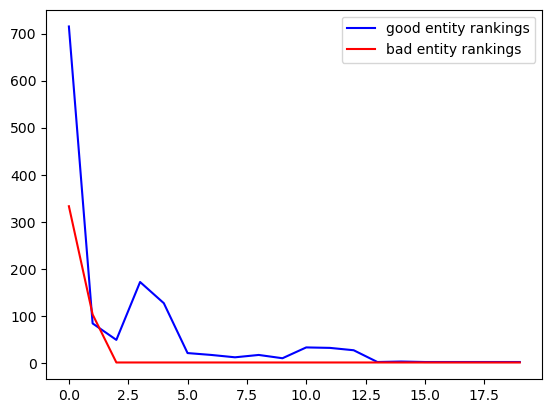

In [2]:
# head prediction version of the experiment 
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']
fact_to_investigate = ["/m/0693l", "/film/director/film" ,"/m/0gwjw0c"]

kelpie_experiment_12 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_12",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = original_dataset_file_paths,
    size_of_original = 15, 
    fact_in_question = fact_to_investigate, 
    prediction_type="head", 
    experiment_type = "kelpie" , 
    reduceOriginal = True, 
    getExplanationsFromOriginalDataset = True,
    originalDatasetTrainPaths = original_dataset_file_paths,
    originalDatasetModelPath = "./Kelpie/stored_models/ComplEx_FB15k-237.pt",
    mode = "necessary", 
)

kelpie_experiment_12.run_experiment("kelpie")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Reducing file size of train, test, and valid files in the dataset FB15k-237
Original file contains 272115 triples.
New file './results/experiment_13/train.txt' created with 13605 triples.
Original file contains 20466 triples.
New file './results/experiment_13/test.txt' created with 1023 triples.
Original file contains 17535 triples.
New file './results/experiment_13/valid.txt' created with 876 triples.

Fact in question
['/m/0693l', '/film/director/film', '/m/0gwjw0c']
Quentin Tarantino /film/director/film Django Unchained

Using untainted dataset and already trained model to get initial ranking and choosing the entities
predictionsss!! [(array([ 2871,  3795,  8459, ..., 14528, 14531, 14510]), array([ 4610,  6606, 10783, ..., 14515, 14511, 14514]))]
Tail prediction 1
From Dusk till Dawn

Tail prediction 2
Django Unchained

Tail prediction 3
Spy Kids 3-D: Game Over

Tail prediction 4
Be Cool

Tail pr

train loss: 100%|██████████| 27206/27206 [00:00<00:00, 82098.30ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376,  809, 4858, ..., 9615, 9681, 9459]), array([4813, 2163, 1021, ..., 9491, 9649, 9760]))]
Tail prediction 1
Rush Hour

Tail prediction 2
Kill Bill Volume 2

Tail prediction 3
Inglourious Basterds

Tail prediction 4
Boogie Nights

Tail prediction 5
Django Unchained

Tail prediction 6
North

Tail prediction 7
Silver Linings Playbook

Tail prediction 8
The Mask

Tail prediction 9
Zero Dark Thirty

Tail prediction 10
Quentin Tarantino

Good entity rank 5
Bad entity rank 807


Round number 2
disinformer adds the following sample to  the dataset
From Dusk till Dawn /film/film/produced_by Quentin Tarantino

Re-training model, dataset was modified


train loss: 100%|██████████| 27208/27208 [00:00<00:00, 82406.47ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376,  809, 6864, ..., 9584, 9266, 9268]), array([4813, 2163, 4858, ..., 9538, 9333, 9669]))]
Tail prediction 1
Rush Hour

Tail prediction 2
Kill Bill Volume 2

Tail prediction 3
Django Unchained

Tail prediction 4
Silver Linings Playbook

Tail prediction 5
From Dusk till Dawn

Tail prediction 6
Inglourious Basterds

Tail prediction 7
Star Wars Episode IV: A New Hope

Tail prediction 8
The Devil Wears Prada

Tail prediction 9
Boogie Nights

Tail prediction 10
Imagine That

Good entity rank 3
Bad entity rank 5


Round number 3
mitigator adds the following sample to  the dataset
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay

Re-training model, dataset was modified


train loss: 100%|██████████| 27210/27210 [00:00<00:00, 82160.38ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376, 1160,  809, ..., 9656, 9345, 4858]), array([4813, 4858, 2163, ..., 9762, 9712, 4376]))]
Tail prediction 1
Rush Hour

Tail prediction 2
Django Unchained

Tail prediction 3
Kill Bill Volume 2

Tail prediction 4
From Dusk till Dawn

Tail prediction 5
North

Tail prediction 6
Boogie Nights

Tail prediction 7
Network

Tail prediction 8
American Beauty

Tail prediction 9
Silver Linings Playbook

Tail prediction 10
The Deer Hunter

Good entity rank 2
Bad entity rank 4


Round number 4
disinformer adds the following sample to  the dataset
From Dusk till Dawn /film/film/executive_produced_by Quentin Tarantino

Re-training model, dataset was modified


train loss: 100%|██████████| 27212/27212 [00:00<00:00, 82239.00ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376, 2146, 1834, ..., 9319, 9348, 9516]), array([4813, 5522,  170, ..., 9364, 9407, 9303]))]
Tail prediction 1
Rush Hour

Tail prediction 2
From Dusk till Dawn

Tail prediction 3
North

Tail prediction 4
Kill Bill Volume 2

Tail prediction 5
Boogie Nights

Tail prediction 6
Django Unchained

Tail prediction 7
Inglourious Basterds

Tail prediction 8
Silver Linings Playbook

Tail prediction 9
Gangs of New York

Tail prediction 10
Meet the Fockers

Good entity rank 6
Bad entity rank 2


Round number 5
mitigator adds the following sample to  the dataset
Quentin Tarantino /film/director/film Inglourious Basterds

Re-training model, dataset was modified


train loss: 100%|██████████| 27214/27214 [00:00<00:00, 82221.17ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376,  809, 1659, ..., 9419, 9527, 9525]), array([1474, 4813, 2163, ..., 9444, 9461, 9339]))]
Tail prediction 1
Silver Linings Playbook

Tail prediction 2
Rush Hour

Tail prediction 3
Kill Bill Volume 2

Tail prediction 4
The Rose

Tail prediction 5
From Dusk till Dawn

Tail prediction 6
Django Unchained

Tail prediction 7
Boogie Nights

Tail prediction 8
This Means War

Tail prediction 9
The Untouchables

Tail prediction 10
Shutter Island

Good entity rank 6
Bad entity rank 5


Round number 6
disinformer adds the following sample to  the dataset
Quentin Tarantino /film/actor/film./film/performance/film Four Rooms

Re-training model, dataset was modified


train loss: 100%|██████████| 27216/27216 [00:00<00:00, 82363.14ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376,  809, 1007, ..., 9315, 9695, 9737]), array([4027, 1474, 6516, ..., 9574, 9312, 9226]))]
Tail prediction 1
Seven

Tail prediction 2
Silver Linings Playbook

Tail prediction 3
The Untouchables

Tail prediction 4
Rush Hour

Tail prediction 5
Boogie Nights

Tail prediction 6
The Rose

Tail prediction 7
From Dusk till Dawn

Tail prediction 8
Twilight

Tail prediction 9
Shutter Island

Tail prediction 10
Kill Bill Volume 2

Good entity rank 14
Bad entity rank 7


Round number 7
mitigator adds the following sample to  the dataset
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction

Re-training model, dataset was modified


train loss: 100%|██████████| 27218/27218 [00:00<00:00, 82275.45ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376,  809, 6082, ..., 9383, 9752, 9552]), array([1474, 4813, 4858, ..., 9278, 9452, 9402]))]
Tail prediction 1
Silver Linings Playbook

Tail prediction 2
Rush Hour

Tail prediction 3
Django Unchained

Tail prediction 4
The Crying Game

Tail prediction 5
The Untouchables

Tail prediction 6
Titanic

Tail prediction 7
The Rose

Tail prediction 8
Four Rooms

Tail prediction 9
Boogie Nights

Tail prediction 10
Kill Bill Volume 2

Good entity rank 3
Bad entity rank 11


Round number 8
disinformer adds the following sample to  the dataset
Quentin Tarantino /film/director/film Inglourious Basterds

[4376, 64, 1021]
<class 'list'>
[[   0    0    1]
 [   2    1    3]
 [   4    2    5]
 ...
 [4376   64 1021]
 [4376   36 5722]
 [4376   10 2206]]
Dataset already contains the sample
Dataset was not modified
Round number 9
mitigator adds the following sample to  the dataset
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomina

train loss: 100%|██████████| 27220/27220 [00:00<00:00, 82192.82ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376,  809, 2527, ..., 9290, 9491, 9279]), array([1474, 4813, 5522, ..., 9609, 9551, 9639]))]
Tail prediction 1
Silver Linings Playbook

Tail prediction 2
Rush Hour

Tail prediction 3
From Dusk till Dawn

Tail prediction 4
The Rose

Tail prediction 5
Kill Bill Volume 2

Tail prediction 6
The Crying Game

Tail prediction 7
Shutter Island

Tail prediction 8
Boogie Nights

Tail prediction 9
The Untouchables

Tail prediction 10
Seven

Good entity rank 15
Bad entity rank 3


Round number 10
disinformer adds the following sample to  the dataset
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award_nominee Lawrence Bender

Re-training model, dataset was modified


train loss: 100%|██████████| 27222/27222 [00:00<00:00, 82220.88ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376,  809, 2732, ..., 9693, 9543, 9430]), array([1474, 4813, 5522, ..., 9658, 9440, 9543]))]
Tail prediction 1
Silver Linings Playbook

Tail prediction 2
Rush Hour

Tail prediction 3
From Dusk till Dawn

Tail prediction 4
This Means War

Tail prediction 5
The Rose

Tail prediction 6
Django Unchained

Tail prediction 7
The Untouchables

Tail prediction 8
Kill Bill Volume 2

Tail prediction 9
Shutter Island

Tail prediction 10
Titanic

Good entity rank 6
Bad entity rank 3


Round number 11
mitigator adds the following sample to  the dataset
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino

Re-training model, dataset was modified


train loss: 100%|██████████| 27224/27224 [00:00<00:00, 82155.04ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376,  809, 2527, ..., 9708, 9410, 9468]), array([1474, 4858, 4813, ..., 9604, 9232, 9392]))]
Tail prediction 1
Silver Linings Playbook

Tail prediction 2
Django Unchained

Tail prediction 3
Rush Hour

Tail prediction 4
Boogie Nights

Tail prediction 5
Kill Bill Volume 2

Tail prediction 6
Seven

Tail prediction 7
The Untouchables

Tail prediction 8
The Crying Game

Tail prediction 9
Father of the Bride Part II

Tail prediction 10
The Rose

Good entity rank 2
Bad entity rank 12


Round number 12
disinformer adds the following sample to  the dataset
Lawrence Bender /award/award_nominee/award_nominations./award/award_nomination/award_nominee Quentin Tarantino

Re-training model, dataset was modified


train loss: 100%|██████████| 27226/27226 [00:00<00:00, 82210.23ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376,  809, 2527, ..., 9207, 9374, 9211]), array([1474, 2163, 7417, ..., 9448, 9634, 9444]))]
Tail prediction 1
Silver Linings Playbook

Tail prediction 2
Kill Bill Volume 2

Tail prediction 3
The Crying Game

Tail prediction 4
Four Rooms

Tail prediction 5
Rush Hour

Tail prediction 6
Father of the Bride Part II

Tail prediction 7
The Rose

Tail prediction 8
The Untouchables

Tail prediction 9
Shutter Island

Tail prediction 10
Star Wars Episode IV: A New Hope

Good entity rank 14
Bad entity rank 17


Round number 13
mitigator adds the following sample to  the dataset
Quentin Tarantino /film/director/film Django Unchained

Re-training model, dataset was modified


train loss: 100%|██████████| 27228/27228 [00:00<00:00, 82160.91ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376, 1160, 2729, ..., 9362, 9746, 9359]), array([4858, 1474, 4813, ..., 9199, 9723, 9290]))]
Tail prediction 1
Django Unchained

Tail prediction 2
Silver Linings Playbook

Tail prediction 3
Rush Hour

Tail prediction 4
G-Force

Tail prediction 5
From Dusk till Dawn

Tail prediction 6
American Beauty

Tail prediction 7
Shutter Island

Tail prediction 8
Father of the Bride Part II

Tail prediction 9
The Untouchables

Tail prediction 10
Four Rooms

Good entity rank 1
Bad entity rank 5


Round number 14
disinformer adds the following sample to  the dataset
Quentin Tarantino /people/person/profession film director

Re-training model, dataset was modified


train loss: 100%|██████████| 27230/27230 [00:00<00:00, 81925.94ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376, 2729, 3909, ..., 9421, 9212, 9218]), array([4858, 1474,  817, ..., 9403, 9516, 9281]))]
Tail prediction 1
Django Unchained

Tail prediction 2
Silver Linings Playbook

Tail prediction 3
Titanic

Tail prediction 4
Kill Bill Volume 2

Tail prediction 5
American Beauty

Tail prediction 6
G-Force

Tail prediction 7
The Matrix

Tail prediction 8
Rush Hour

Tail prediction 9
Four Rooms

Tail prediction 10
Crouching Tiger, Hidden Dragon

Good entity rank 1
Bad entity rank 37


Round number 15
mitigator adds the following sample to  the dataset
Django Unchained /film/film/written_by Quentin Tarantino

Re-training model, dataset was modified


train loss: 100%|██████████| 27232/27232 [00:00<00:00, 82211.66ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376, 2729, 3909, ..., 9399, 9688, 9476]), array([4858, 2163,  933, ..., 9361, 9474, 9548]))]
Tail prediction 1
Django Unchained

Tail prediction 2
Kill Bill Volume 2

Tail prediction 3
American Beauty

Tail prediction 4
G-Force

Tail prediction 5
Silver Linings Playbook

Tail prediction 6
Pirates of the Caribbean: Dead Man's Chest

Tail prediction 7
Alice in Wonderland

Tail prediction 8
Father of the Bride Part II

Tail prediction 9
The Help

Tail prediction 10
From Dusk till Dawn

Good entity rank 1
Bad entity rank 10


Round number 16
disinformer adds the following sample to  the dataset
Quentin Tarantino /film/actor/film./film/performance/film Pulp Fiction

Re-training model, dataset was modified


train loss: 100%|██████████| 27234/27234 [00:00<00:00, 82277.57ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376, 2729, 4347, ..., 9431, 9499, 9666]), array([4858, 2163, 1474, ..., 9650, 9767, 9421]))]
Tail prediction 1
Django Unchained

Tail prediction 2
Kill Bill Volume 2

Tail prediction 3
Silver Linings Playbook

Tail prediction 4
American Beauty

Tail prediction 5
G-Force

Tail prediction 6
The Matrix

Tail prediction 7
Alice in Wonderland

Tail prediction 8
Crouching Tiger, Hidden Dragon

Tail prediction 9
The Rose

Tail prediction 10
The Help

Good entity rank 1
Bad entity rank 15


Round number 17
disinformer adds the following sample to  the dataset
From Dusk till Dawn /film/film/written_by Quentin Tarantino

Re-training model, dataset was modified


train loss: 100%|██████████| 27236/27236 [00:00<00:00, 82253.63ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376, 4347, 2729, ..., 9753, 9622, 9323]), array([4858, 5522, 2163, ..., 9489, 9592, 9591]))]
Tail prediction 1
Django Unchained

Tail prediction 2
From Dusk till Dawn

Tail prediction 3
Kill Bill Volume 2

Tail prediction 4
Silver Linings Playbook

Tail prediction 5
American Beauty

Tail prediction 6
G-Force

Tail prediction 7
Rush Hour

Tail prediction 8
The Matrix

Tail prediction 9
Shutter Island

Tail prediction 10
The Rose

Good entity rank 1
Bad entity rank 2


Round number 18
disinformer adds the following sample to  the dataset
Quentin Tarantino /people/person/languages English

Re-training model, dataset was modified


train loss: 100%|██████████| 27238/27238 [00:00<00:00, 82282.36ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376, 4347, 2729, ..., 9206, 9438, 9659]), array([4858, 5522, 1474, ..., 9335, 9280, 9279]))]
Tail prediction 1
Django Unchained

Tail prediction 2
From Dusk till Dawn

Tail prediction 3
Silver Linings Playbook

Tail prediction 4
Rush Hour

Tail prediction 5
Kill Bill Volume 2

Tail prediction 6
G-Force

Tail prediction 7
Shutter Island

Tail prediction 8
Titanic

Tail prediction 9
American Beauty

Tail prediction 10
Boogie Nights

Good entity rank 1
Bad entity rank 2


Round number 19
disinformer adds the following sample to  the dataset
Quentin Tarantino /film/director/film Django Unchained

[4376, 64, 4858]
<class 'list'>
[[   0    0    1]
 [   2    1    3]
 [   4    2    5]
 ...
 [4376   36 4348]
 [5522   87 4376]
 [4376  135  432]]
Dataset already contains the sample
Dataset was not modified
Round number 20
disinformer adds the following sample to  the dataset
Quentin Tarantino /award/award_nominee/award_nominations./award/award_n

train loss: 100%|██████████| 27240/27240 [00:00<00:00, 82307.31ex/s, loss={l.item():.0f}] 


	 saving model...
	 done.
predictionsss!! [(array([4376, 4347, 2729, ..., 9670, 9262, 9663]), array([4858, 5522, 2163, ..., 9723, 9641, 9393]))]
Tail prediction 1
Django Unchained

Tail prediction 2
From Dusk till Dawn

Tail prediction 3
Kill Bill Volume 2

Tail prediction 4
Silver Linings Playbook

Tail prediction 5
G-Force

Tail prediction 6
American Beauty

Tail prediction 7
Rush Hour

Tail prediction 8
Seven

Tail prediction 9
Crouching Tiger, Hidden Dragon

Tail prediction 10
The Matrix

Good entity rank 1
Bad entity rank 2


Remaining budget for disinformer
[]

Remaining budget for mitigator
[]

Good entity rankings [5, 3, 2, 6, 6, 14, 3, 15, 6, 2, 14, 1, 1, 1, 1, 1, 1, 1]
Bad entity rankings [807, 5, 4, 2, 5, 7, 11, 3, 3, 12, 17, 5, 37, 10, 15, 2, 2, 2]


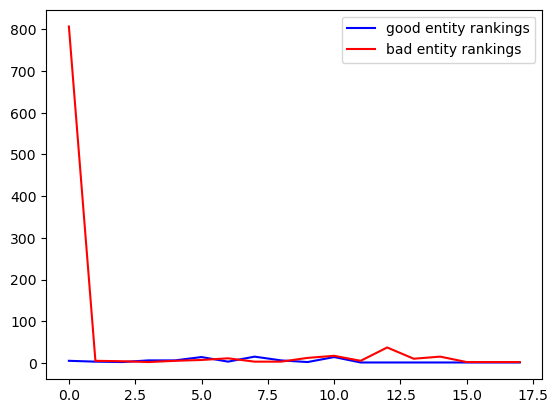

In [4]:
# tail prediction version of the experiment
%load_ext autoreload
%autoreload 2
from knowledge_graph_simulation_experiment import KnowledgeGraphMitigationExperiment
original_dataset_file_paths = ['Kelpie/data/FB15k-237/train.txt','Kelpie/data/FB15k-237/test.txt', 'Kelpie/data/FB15k-237/valid.txt']
fact_to_investigate = ["/m/0693l", "/film/director/film" ,"/m/0gwjw0c"]

kelpie_experiment_13 = KnowledgeGraphMitigationExperiment(
    experiment_name="experiment_13",
    dataset_name = "FB15k-237", 
    train_test_valid_paths = original_dataset_file_paths,
    size_of_original = 5, 
    fact_in_question = fact_to_investigate, 
    prediction_type="tail", 
    experiment_type = "kelpie" , 
    reduceOriginal = True, 
    getExplanationsFromOriginalDataset = True,
    originalDatasetTrainPaths = original_dataset_file_paths,
    originalDatasetModelPath = "./Kelpie/stored_models/ComplEx_FB15k-237.pt",
    mode = "necessary", 
)

kelpie_experiment_13.run_experiment("kelpie")

# Run necessary tail simulation for Quentin Tarantino /film/director/film Django Unchained

```
Quentin Tarantino /film/director/film Django Unchained
/m/0693l /film/director/film /m/0gwjw0c

```

**Dataset :** Randomly-chosen thriples of the FB15-237 dataset, about 5% of the original dataset.     
**Approach:** get the necessary explanations that support the tail prediction of the fact. Get the explanations from the full dataset. If there is overlap between both explanation sets, only add the fact once.  
**Attack strategy:** Round-Robin   
**Was the fact in question removed**? No  
**Fact in question:** Quentin Tarantino /film/director/film Django Unchained   
**Chosen Bad Entity:** From Dusk till Dawn (original rank 1)  
**Chosen Good entity:** Django Unchained(original rank 2) 
**Prediction Type**: Tail 

### Good entity explanations
```
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /film/director/film Inglourious Basterds
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
```

### Unique Good Entity explanations
It appears that there is an overlap between both explanation sets. I want to see the unique explanations that contributed to Django unchained being predicted as a :

```
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay
Django Unchained /film/film/written_by Quentin Tarantino
Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
```



### Bad entity explanations
```
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award_nominee Lawrence Bender
Quentin Tarantino /film/actor/film./film/performance/film Four Rooms
Quentin Tarantino /film/director/film Django Unchained
From Dusk till Dawn /film/film/executive_produced_by Quentin Tarantino
Quentin Tarantino /people/person/languages English
Lawrence Bender /award/award_nominee/award_nominations./award/award_nomination/award_nominee Quentin Tarantino
From Dusk till Dawn /film/film/written_by Quentin Tarantino
Quentin Tarantino /film/director/film Inglourious Basterds
Quentin Tarantino /people/person/profession film director
Quentin Tarantino /film/actor/film./film/performance/film Pulp Fiction
From Dusk till Dawn /film/film/produced_by Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Raspberry Award for Worst Supporting Actor
```

### Unique Bad Entity explanations
It appears that there is an overlap between both explanation sets. I want to see the unique explanations that contributed to quenting tarantion being predicted as a good explanation.
```
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award_nominee Lawrence Bender
Quentin Tarantino /film/actor/film./film/performance/film Four Rooms
From Dusk till Dawn /film/film/executive_produced_by Quentin Tarantino
Quentin Tarantino /people/person/languages English
Lawrence Bender /award/award_nominee/award_nominations./award/award_nomination/award_nominee Quentin Tarantino
From Dusk till Dawn /film/film/written_by Quentin Tarantino
Quentin Tarantino /people/person/profession film director
Quentin Tarantino /film/actor/film./film/performance/film Pulp Fiction
From Dusk till Dawn /film/film/produced_by Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Raspberry Award for Worst Supporting Actor
 ```
 
### Shared Explanations 
This the explanations shared by both groups
```
Quentin Tarantino /film/director/film Django Unchained
Quentin Tarantino /film/director/film Inglourious Basterds
```


**Number of rounds for this simulation:** 21

<img src="./results/experiment_13/rankings.png" />



Things to ensure (for later)

- when reducing the dataset, I keep the original fact, its explanations, and the neighbors of both (1 or 2 hops)


In [3]:
good_explanations = """Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /film/director/film Inglourious Basterds
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino""".split('\n')


bad_explanations ="""Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award_nominee Lawrence Bender
Quentin Tarantino /film/actor/film./film/performance/film Four Rooms
Quentin Tarantino /film/director/film Django Unchained
From Dusk till Dawn /film/film/executive_produced_by Quentin Tarantino
Quentin Tarantino /people/person/languages English
Lawrence Bender /award/award_nominee/award_nominations./award/award_nomination/award_nominee Quentin Tarantino
From Dusk till Dawn /film/film/written_by Quentin Tarantino
Quentin Tarantino /film/director/film Inglourious Basterds
Quentin Tarantino /people/person/profession film director
Quentin Tarantino /film/actor/film./film/performance/film Pulp Fiction
From Dusk till Dawn /film/film/produced_by Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Raspberry Award for Worst Supporting Actor""".split("\n")
print(good_explanations)
print("length of good explanations", len(good_explanations))
print(bad_explanations)
print("length of bad explanations", len(bad_explanations))
print()
print()

unique_good_explanations = [explanation for explanation in good_explanations if explanation not in bad_explanations]
unique_bad_explanations = [explanation for explanation in bad_explanations if explanation not in good_explanations]
shared_explanations = [explanation for explanation in good_explanations if explanation in bad_explanations]



print("unique good explanations length", len(unique_good_explanations))
for explanation in unique_good_explanations:
    print(explanation)
print()

print("unique bad explanations length", len(unique_bad_explanations))
for explanation in unique_bad_explanations:
    print(explanation)
print()

    
print("shared explanations length", len(shared_explanations))
for explanation in shared_explanations:
    print(explanation)
    

['Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained', 'Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay', 'Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction', 'Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay', 'Quentin Tarantino /film/director/film Django Unchained', 'Django Unchained /film/film/written_by Quentin Tarantino', 'Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino', 'Quentin Tarantino /film/director/film Inglourious Basterds', 'Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino']
length of good explanations 9
['Quentin Tarantino /awar

# Weekly Update July 28

Hi all,
There were several errors with my approach this past week, so I spent a considerable amount of time debugging to understand what was happening. If possible, please read this and let me know if my results are making more sense and if you have any comments on what I could work on to improve this. Perhaps there are other possible bugs I don't see 😅. I'm sharing this in anticipation of our meeting on the 15th. If this update is too long, I can also explain this during the meeting itself (I will probably explain all of this too, to Professor Azza next week in a meeting).


1. The first thing I debugged was why we were getting very short explanations. For instance, in the `Augustine of Hippo /people/person/gender male organism` example I talked about this week, I was getting the following necessary explanations:

```
Raza Murad /people/person/gender male organism     
Henri Matisse /people/person/gender male organism  
Samuel M. Comer /people/person/gender male organism  
Paul Soloway /people/person/gender male organism  
Lou Diamond Phillips /people/person/gender male organism  
Augustine of Hippo /people/person/gender male organism   
```

Although these explanations do satisfy the definition of a necessary explanation for the head prediction case (facts that mention the tail that enable the prediction), I agree with your comments that these explanations are A) too short and B) somewhat random. They don't intuitively say anything about Augustine. As such, I went through the exercise of examining the 4 different relation types (as supported by the datasets — both data and code — provided by the Kelpie authors) and extracted all possible explanations for that fact as permitted by Kelpie:

- Necessary explanations for the head prediction
- Necessary explanations for the tail prediction
- Sufficient explanations for the tail prediction


_*An important caveat here is that the sufficient explanations return a `NotImplementedError` as specified by the authors. I looked into it, and it seems that it's possible to extrapolate the sufficient-head explanation code implementation from the sufficient tail explanation implementation. However, I guess the authors didn't do this because their experimental setup in the paper focuses on tail explanations._

As I was conducting this exercise, I found a major bug in how I was reading the entire knowledge graph into the Dataset class in my code. This essentially meant that the explanations you see above are derived from a smaller subset of the knowledge graph (probably less than 5%), which is why they are so short and seemingly random. The exercise is outlined below, where I focused on four types of relations: 1-N, N-N, N-1, and 1-1.



# Relation Type: N to 1
```
# Augustine of Hippo /people/person/gender male organism
fact_to_try = ["/m/0w6w", "/people/person/gender", "/m/05zppz"]

```

## necessary - head  
```
Jean-Paul Sartre /people/person/gender male organism
Gottfried Wilhelm Leibniz /people/person/gender male organism
Thomas Aquinas /people/person/gender male organism
Jerry Seinfeld /people/person/gender male organism
John Locke /people/person/gender male organism
Ludwig Wittgenstein /people/person/gender male organism
Martin Donovan /people/person/gender male organism
Jack Kerouac /people/person/gender male organism
John McCain /people/person/gender male organism
Lars von Trier /people/person/gender male organism

```

## necessary-tail  

```
Thomas Aquinas /influence/influence_node/influenced_by Augustine of Hippo
Augustine of Hippo /people/person/religion Catholicism
Augustine of Hippo /organization/organization_founder/organizations_founded Catholic Church
Augustine of Hippo /influence/influence_node/influenced_by Plato
Augustine of Hippo /people/person/profession physician
Augustine of Hippo /influence/influence_node/influenced_by Jesus Christ
Augustine of Hippo /people/person/profession writer
Augustine of Hippo /people/person/nationality Algeria
Ludwig Wittgenstein /influence/influence_node/influenced_by Augustine of Hippo

```



## sufficient-tail 

```
Thomas Aquinas /influence/influence_node/influenced_by Augustine of Hippo
Augustine of Hippo /influence/influence_node/influenced_by Aristotle
Augustine of Hippo /people/person/religion Catholicism
Augustine of Hippo /influence/influence_node/influenced_by Plato
Augustine of Hippo /people/person/profession physician
Augustine of Hippo /influence/influence_node/influenced_by Jesus Christ
Augustine of Hippo /people/person/profession writer
Martin Heidegger /influence/influence_node/influenced_by Augustine of Hippo
Augustine of Hippo /people/person/nationality Algeria
Ludwig Wittgenstein /influence/influence_node/influenced_by Augustine of Hippo

```

# Relation Type: 1 to 1

```
Mary Steenburgen /people/person/spouse_s./people/marriage/spouse Malcolm McDowell
/m/014g22 /people/person/spouse_s./people/marriage/spouse /m/01c65z
```

## necessary - head  
```
Malcolm McDowell /film/actor/film./film/performance/film I Spy
Malcolm McDowell /people/person/languages English
Malcolm McDowell /film/actor/film./film/performance/film Fist of the North Star
Malcolm McDowell /people/person/profession film producer
Malcolm McDowell /people/person/places_lived./people/place_lived/location Leeds
London Academy of Music and Dramatic Art /education/educational_institution/students_graduates./education/education/student Malcolm McDowell
Malcolm McDowell /film/actor/film./film/performance/film Bolt
Malcolm McDowell /film/actor/film./film/performance/film The Book of Eli
Malcolm McDowell /award/award_nominee/award_nominations./award/award_nomination/award National Society of Film Critics Award for Best Actor
Malcolm McDowell /people/person/spouse_s./people/marriage/type_of_union marriage
Malcolm McDowell /people/person/nationality United Kingdom
Malcolm McDowell /base/schemastaging/person_extra/net_worth./measurement_unit/dated_money_value/currency United States dollar
Malcolm McDowell /film/actor/film./film/performance/film Halloween
Heroes /tv/tv_program/regular_cast./tv/regular_tv_appearance/actor Malcolm McDowell
Malcolm McDowell /award/award_nominee/award_nominations./award/award_nomination/nominated_for A Clockwork Orange
Malcolm McDowell /people/person/profession actor
Malcolm McDowell /film/actor/film./film/performance/film A Clockwork Orange

```

## necessary-tail  

```
Mary Steenburgen /people/person/spouse_s./people/marriage/spouse Ted Danson
Mary Steenburgen /film/actor/film./film/performance/film The Help
Powers Boothe /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen
Mary Steenburgen /film/actor/film./film/performance/film Gulliver's Travels
Mary Steenburgen /award/award_winner/awards_won./award/award_honor/award_winner Jessica Chastain
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/award_nominee Kevin Dunn
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/award_nominee Jessica Chastain
Mary Steenburgen /people/person/profession film producer
Mary Steenburgen /people/person/profession actor
Mary Steenburgen /award/award_winner/awards_won./award/award_honor/award_winner Octavia Spencer
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/award_nominee Joan Allen
Mary Steenburgen /people/person/spouse_s./people/marriage/type_of_union marriage
David Paymer /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen
Mary Steenburgen /film/actor/film./film/performance/film Philadelphia
Viola Davis /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen
E. G. Marshall /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/award_nominee Anthony Hopkins
James Woods /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/nominated_for The Help
Allison Janney /award/award_nominee/award_nominations./award/award_nomination/award_nominee Mary Steenburgen

```

## sufficient-tail 

```
Mary Steenburgen /people/person/spouse_s./people/marriage/spouse Ted Danson
Mary Steenburgen /film/actor/film./film/performance/film The Help
Mary Steenburgen /people/person/spouse_s./people/marriage/type_of_union marriage
Mary Steenburgen /film/actor/film./film/performance/film Gulliver's Travels
Mary Steenburgen /people/person/profession film producer
Mary Steenburgen /award/award_nominee/award_nominations./award/award_nomination/nominated_for The Help
Mary Steenburgen /people/person/profession actor
```

# Relation Type: N to N

```
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Notts County F.C.
/m/07h1h5 /soccer/football_player/current_team./sports/sports_team_roster/team /m/029q3k
```

## necessary - head  
```
Jonathan Forte /sports/pro_athlete/teams./sports/sports_team_roster/team Notts County F.C.
Felix Bastians /sports/pro_athlete/teams./sports/sports_team_roster/team Notts County F.C.
James Walker /soccer/football_player/current_team./sports/sports_team_roster/team Notts County F.C.
forward /sports/sports_position/players./sports/sports_team_roster/team Notts County F.C.
Notts County F.C. /soccer/football_team/current_roster./soccer/football_roster_position/position forward
Notts County F.C. /soccer/football_team/current_roster./soccer/football_roster_position/position goalkeeper
Jonathan Forte /soccer/football_player/current_team./sports/sports_team_roster/team Notts County F.C.
Notts County F.C. /soccer/football_team/current_roster./sports/sports_team_roster/position defender
goalkeeper /sports/sports_position/players./sports/sports_team_roster/team Notts County F.C.
Delroy Facey /sports/pro_athlete/teams./sports/sports_team_roster/team Notts County F.C.
midfielder /sports/sports_position/players./sports/sports_team_roster/team Notts County F.C.
Notts County F.C. /soccer/football_team/current_roster./soccer/football_roster_position/position defender
Notts County F.C. /soccer/football_team/current_roster./sports/sports_team_roster/position midfielder
Felix Bastians /soccer/football_player/current_team./sports/sports_team_roster/team Notts County F.C.
defender /sports/sports_position/players./sports/sports_team_roster/team Notts County F.C.
James Walker /sports/pro_athlete/teams./sports/sports_team_roster/team Notts County F.C.
Notts County F.C. /soccer/football_team/current_roster./sports/sports_team_roster/position goalkeeper
```

## necessary-tail  

```
Kasper Schmeichel /people/person/place_of_birth Copenhagen
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Coventry City F.C.
Kasper Schmeichel /people/person/places_lived./people/place_lived/location Copenhagen
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Bury F.C.
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Falkirk F.C.
association football /sports/sport/pro_athletes./sports/pro_sports_played/athlete Kasper Schmeichel
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Leicester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Leicester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Manchester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Darlington F.C.
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Denmark national football team
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Denmark national football team
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Leeds United A.F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Leeds United A.F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Coventry City F.C.
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Manchester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Cardiff City F.C.
```



## sufficient-tail 

```
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Coventry City F.C.
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Bury F.C.
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Falkirk F.C.
association football /sports/sport/pro_athletes./sports/pro_sports_played/athlete Kasper Schmeichel
Kasper Schmeichel /sports/pro_athlete/teams./sports/sports_team_roster/team Leicester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Leicester City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Darlington F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Coventry City F.C.
Kasper Schmeichel /soccer/football_player/current_team./sports/sports_team_roster/team Cardiff City F.C.
```

# Relation Type: 1 to N

```
Quentin Tarantino /film/director/film Django Unchained
/m/0693l /film/director/film /m/0gwjw0c

```

## necessary - head  
```
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Django Unchained /film/film/language English
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Golden Globe Award for Best Screenplay
Michael Minkler /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Christoph Waltz /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award Academy Award for Best Writing, Original Screenplay
Django Unchained /award/award_winning_work/awards_won./award/award_honor/award BAFTA Award for Best Original Screenplay
Academy Award for Best Writing, Original Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Don Johnson /film/actor/film./film/performance/film Django Unchained
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Golden Globe Award for Best Screenplay /award/award_category/nominees./award/award_nomination/nominated_for Django Unchained
Christoph Waltz /film/actor/film./film/performance/film Django Unchained


```

## necessary-tail  

```
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay
Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay
Quentin Tarantino /film/director/film Inglourious Basterds
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
```



## sufficient-tail 

```
Quentin Tarantino /base/popstra/celebrity/friendship./base/popstra/friendship/participant Courtney Love
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award_nominee Lawrence Bender
Lawrence Bender /award/award_nominee/award_nominations./award/award_nomination/award_nominee Quentin Tarantino
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Quentin Tarantino /film/director/film Inglourious Basterds
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Ali Larter /base/popstra/celebrity/dated./base/popstra/dated/participant Quentin Tarantino
Quentin Tarantino /film/actor/film./film/performance/film Pulp Fiction
```


# New simulation (1-to-N) Quentin Tarantino /film/director/film Django Unchained

After conducting the exercise above and fixing the bugs I found, I decided to conduct a brand new simulation focusing on the 1-N relationship type for two reasons:

- We all agreed that tail explanations are more logically intuitive
- 1-N allows for different tails being possibly true (e.g., Quentin Tarantino has directed many movies!), which we can argue is a scenario ripe for misinformation.

The explanations are obtained from the entirety of the dataset and are then added to a smaller version of the dataset in a round-robin fashion. Before starting the simulation, we ensure all the explanations are removed. As discussed, a natural next step would be to be more strategic in how the knowledge graph is reduced.



```
Quentin Tarantino /film/director/film Django Unchained
/m/0693l /film/director/film /m/0gwjw0c

```

**Dataset :** Randomly-chosen thriples of the FB15-237 dataset, about 5% of the original dataset.     
**Approach:** get the necessary explanations that support the tail prediction of the fact. Get the explanations from the full dataset. If there is overlap between both explanation sets, only add the fact once.  
**Attack strategy:** Round-Robin   
**Was the fact in question removed**? Yes  
**Fact in question:** Quentin Tarantino /film/director/film Django Unchained   
**Chosen Bad Entity:** From Dusk till Dawn (original rank 1)  
**Chosen Good entity:** Django Unchained(original rank 2) 
**Prediction Type**: Tail 

## Good entity explanations
```
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /film/director/film Inglourious Basterds
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
```


## Bad entity explanations
```
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award_nominee Lawrence Bender
Quentin Tarantino /film/actor/film./film/performance/film Four Rooms
Quentin Tarantino /film/director/film Django Unchained
From Dusk till Dawn /film/film/executive_produced_by Quentin Tarantino
Quentin Tarantino /people/person/languages English
Lawrence Bender /award/award_nominee/award_nominations./award/award_nomination/award_nominee Quentin Tarantino
From Dusk till Dawn /film/film/written_by Quentin Tarantino
Quentin Tarantino /film/director/film Inglourious Basterds
Quentin Tarantino /people/person/profession film director
Quentin Tarantino /film/actor/film./film/performance/film Pulp Fiction
From Dusk till Dawn /film/film/produced_by Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Raspberry Award for Worst Supporting Actor
```
 


**Number of rounds for this simulation:** 21

<img src="./results/experiment_13/rankings.png" />

### Important Notes

- Overlap amongst explanation sets
There is an overlap amongst the explanation sets. When I run the simulation, I only add a fact back into the dataset if it is not already present in the dataset. Below, you can see the unique good entity explanations, bad entity explanations, and the shared facts. Perhaps another next step would be to explore what this overlap means.




### Unique Good Entity explanations

```
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay
Django Unchained /film/film/written_by Quentin Tarantino
Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
```


### Unique Bad Entity explanations
```
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award_nominee Lawrence Bender
Quentin Tarantino /film/actor/film./film/performance/film Four Rooms
From Dusk till Dawn /film/film/executive_produced_by Quentin Tarantino
Quentin Tarantino /people/person/languages English
Lawrence Bender /award/award_nominee/award_nominations./award/award_nomination/award_nominee Quentin Tarantino
From Dusk till Dawn /film/film/written_by Quentin Tarantino
Quentin Tarantino /people/person/profession film director
Quentin Tarantino /film/actor/film./film/performance/film Pulp Fiction
From Dusk till Dawn /film/film/produced_by Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Raspberry Award for Worst Supporting Actor
 ```
 
 ### Shared Explanations 
This the explanations shared by both groups
```
Quentin Tarantino /film/director/film Django Unchained
Quentin Tarantino /film/director/film Inglourious Basterds
```

- Should we create a super set of all explanation types (necessary-head, necessary-tail, sufficient-head, and sufficient-tail), remove all duplicates, and use this as the budget we want to give the attacker and the disinformer?





# Miscellaneous 

One interesting thing I found is that these relation types are enforced by some heuristics that, I presume, are defined by the literature (I need to double-check this). For example, a question I had was why is `marriage` considered a 1-1 relationship. What if a person marries someone else? More specifically, this is how the Kelpie authors define what relation type is assigned to a relation:

```python
for relation in relation_2_heads_nums:
    average_heads_per_tail = numpy.average(relation_2_heads_nums[relation])
    average_tails_per_head = numpy.average(relation_2_tails_nums[relation])

    if average_heads_per_tail > 1.2 and average_tails_per_head > 1.2:
        self.relation_2_type[relation] = MANY_TO_MANY
    elif average_heads_per_tail > 1.2 and average_tails_per_head <= 1.2:
        self.relation_2_type[relation] = MANY_TO_ONE
    elif average_heads_per_tail <= 1.2 and average_tails_per_head > 1.2:
        self.relation_2_type[relation] = ONE_TO_MANY
    else:
        self.relation_2_type[relation] = ONE_TO_ONE
```
It seems that the average number of heads and tails per relation in the training dataset is calculated, and 1.2 is used as the threshold to determine whether something transitions from being a 1-X to an N-X relationship (the same applies for the tail). Perhaps corrupting this relation is something worth exploring in our simulations, similar to what's done already in [this study](https://aclanthology.org/2021.acl-long.147).








# Strategies conversation with miro

August 3rd, 2023

Link Prediction Model (ComplEx): QT,DIRECTED,?

1. Dusk till Dawn 
2. Django Unchaine
...
200. Finding Nemo




Kelpie: pls explain this QT,DIRECTED,Dusk till Dawn 
Explanation types: 
necessary-tail
necessary-head

necessary tells you why the prediction happened


sufficient-tail
sufficient-head

sufficient tells you how to confuse model to predict something else


CristopherNolan, directed, DuskTilDawn
sufficient explanations : 

```
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay
Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay
Quentin Tarantino /film/director/film Inglourious Basterds
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
....
```
 => (you change the mention of QT to CN)
 
 ```
 Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner CristopherNolan
CristopherNolan /film/director/film Django Unchained
...
 ```
 
 then you add to the dataset and train again

LP: CristopherNolan, directed,?

1.Dusk Till Dawn





Tail prediction of QT,DIRECTED,Dusk till Dawn 
Why was Dusk till Dawn predicted as the filmed directed by QT?
```
Golden Globe Award for Best Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /film/director/film Django Unchained
Django Unchained /film/film/written_by Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award BAFTA Award for Best Direction
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Golden Globe Award for Best Screenplay
Academy Award for Best Writing, Original Screenplay /award/award_category/winners./award/award_honor/award_winner Quentin Tarantino
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/award Academy Award for Best Writing, Original Screenplay
Quentin Tarantino /film/director/film Inglourious Basterds
Quentin Tarantino /award/award_nominee/award_nominations./award/award_nomination/nominated_for Django Unchained
```


1o explanations given from kelpie



Shared explanations are bad, just remove them 
remove explanations, then ask
you need to compare against random as a baseline
no definition of budget or cost
how do we structure so that it is opposing facts?? Django directed Cristopher Nolan

budget random additions of explanations, and then fifo
fifo vs random
limit the number of moves/steps

when i add bad entity explanations, good entity should go down

just do one plot, if its the same as before with the two, then they are not affecting each other. 





August 8 Meeting

- Things to discuss
    - Choosing a better counter-fact, miro doesnt like the shared explanations
    - how do we define budget? if we receive 10 explanations, is the budget 5?
 - Things i am working on
     - FIFO strategy implementation? compare it to random?
     - Determine the importance of a fact? Can we extend the number of kelpie explanations?

# Playing with different strategies



In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
print("hii")

hii


In [9]:
from Kelpie.dataset import Dataset
import numpy as np
import pandas as pd
from helpers.helpers import print_fact, extract_subgraph_of_kg, print_entity
import json

In [10]:
fb15k237_path = 'Kelpie_package/Kelpie/data/FB15k-237'
train_path = fb15k237_path + '/train.txt'
test_path = fb15k237_path + '/test.txt'
valid_path = fb15k237_path + '/valid.txt'
fact_to_investigate = ("/m/0693l", "/film/director/film" ,"/m/0gwjw0c")
fb15k237_dataset = Dataset(name="FB15k-237", load=True, train_path=train_path, test_path=test_path, valid_path=valid_path)
sample_to_investigate = fb15k237_dataset.fact_to_sample(fact_to_investigate)

label_map_path = 'bin/entity2wikidata.json'
label_map = json.load(open(label_map_path))

In [ ]:
# i will keep test and valid sets the same for now and then ask reem how did she do it. 
new_kg = extract_subgraph_of_kg(fb15k237_dataset, sample_to_investigate, percentage_to_keep= 10, save_path='mitigating_data_void_strategies/data/reduced_training_kg.txt')

Reducing the dataset size from 272115 to 27211
Generated 1 entries.
Generated 177 entries.
Generated 249 entries.
Generated 275 entries.
Generated 364 entries.
Generated 381 entries.
Generated 470 entries.
Generated 560 entries.
Generated 614 entries.
Generated 614 entries.
Generated 705 entries.
Generated 794 entries.
Generated 877 entries.
Generated 928 entries.
Generated 949 entries.
Generated 1038 entries.
Generated 1038 entries.
Generated 1126 entries.
Generated 1145 entries.
Generated 1232 entries.
Generated 1323 entries.
Generated 1413 entries.
Generated 1413 entries.
Generated 1446 entries.
Generated 1501 entries.
Generated 1516 entries.
Generated 1604 entries.
Generated 1668 entries.
Generated 1668 entries.
Generated 1670 entries.
Generated 1684 entries.
Generated 1713 entries.
Generated 1802 entries.
Generated 1894 entries.
Generated 1982 entries.
Generated 2012 entries.
Generated 2099 entries.
Generated 2099 entries.
Generated 2188 entries.
Generated 2224 entries.
Generated 